# Проект. Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

## Шаг 1. Загрузка данных

In [ ]:
!pip install optuna -q
!pip install optuna-integration -q
!pip install catboost -q
!pip install torchmetrics -q
!pip install phik -q
!pip install shap -q

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import phik
from sqlalchemy import create_engine
import pickle
import random
import requests
import shap
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import (GroupShuffleSplit, train_test_split,
                                     RandomizedSearchCV, cross_val_score)
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler,
                                   MinMaxScaler)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
from torchmetrics import MeanSquaredError


import optuna
from optuna import trial
from optuna import distributions
from optuna.integration import OptunaSearchCV

from catboost import CatBoostRegressor

RANDOM_STATE = 171224

import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

Зафиксируем случайность

In [ ]:
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

def set_seed(seed: int = RANDOM_STATE) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

подключение к базе данных:

In [ ]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db

path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

--2024-12-21 00:46:50--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.2’

ds-plus-final.db.2  100%[===================>]   3.42M  1.71MB/s    in 2.0s    

2024-12-21 00:46:53 (1.71 MB/s) - ‘ds-plus-final.db.2’ saved [3588096/3588096]



In [ ]:
import sqlite3

conn = sqlite3.connect('ds-plus-final.db')
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [row for row in cursor.fetchall()]
print(tables)

conn.close()

[('data_arc',), ('data_bulk',), ('data_bulk_time',), ('data_wire_time',), ('contract',), ('personal',), ('phone',), ('internet',), ('data_gas',), ('data_temp',), ('data_wire',)]


Сохраним и выведем первичную информацию о таблицах:

In [ ]:
tables = ['data_arc', 'data_bulk', 'data_bulk_time',
          'data_gas', 'data_temp', 'data_wire',
          'data_wire_time']

df = {}

for table in tables:
    df1 = pd.read_sql_table(table, engine)
    df[table] = df1

for table, df1 in df.items():
    print(f"Таблица: {table}")
    print(df1.head())
    print("\n")

Таблица: data_arc
   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  


Таблица: data_bulk
   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
0    1     NaN     NaN     NaN    43.0   None   None   None   None   None   
1    2     NaN     NaN     NaN    73.0   None   None   None   None   None   
2    3     NaN     NaN     NaN    34.0   None   None   None   None   None   
3    4     NaN     NaN     NaN    81.0   None   None   None   None   None   

## Шаг 2. Исследовательский анализ и предобработка данных

### Предобработка

Переименуем колонки в змеинный регистр:

In [ ]:
for data in tables:
    df[data].columns = df[data].columns.str.lower().str.replace(' ', '_')

#### data_arc

In [ ]:
df['data_arc'].head()

key начало_нагрева_дугой  конец_нагрева_дугой  активная_мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   реактивная_мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

In [ ]:
df['data_arc'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   начало_нагрева_дугой  14876 non-null  object 
 2   конец_нагрева_дугой   14876 non-null  object 
 3   активная_мощность     14876 non-null  float64
 4   реактивная_мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Таблица data_arc - это данные об электродах, которая содержит 5 колонок: 2 типа object, 2 типа float и колонку key c информацией номера партии представленную в int. 14876 строк

Начало и конец нагрева переведены в корректный тип данных соответствующий времени datetime64

In [ ]:
df['data_arc']['начало_нагрева_дугой'] = pd.to_datetime(df['data_arc']['начало_нагрева_дугой'], format='%Y-%m-%d %H:%M:%S')
df['data_arc']['конец_нагрева_дугой'] = pd.to_datetime(df['data_arc']['конец_нагрева_дугой'], format='%Y-%m-%d %H:%M:%S')
df['data_arc'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [ ]:
df['data_arc'].isna().mean()

key                     0.0
начало_нагрева_дугой    0.0
конец_нагрева_дугой     0.0
активная_мощность       0.0
реактивная_мощность     0.0
dtype: float64

In [ ]:
df['data_arc'].duplicated().sum()

0

Пропусков и дуюликатов не наблюдаем

In [ ]:
len(df['data_arc']['key'].unique())

3214

In [ ]:
df['data_arc']['key'].unique().max()

3241

Наблюдаем что кол-во уникальных значений номера партий не бьется с максимальным значением, что нам говорит о пропущенных значениях номера партий и что они не идут по порядку

#### data_bulk

In [ ]:
df['data_bulk'].head()

key  bulk_1  bulk_2  bulk_3  bulk_4 bulk_5 bulk_6 bulk_7 bulk_8 bulk_9  \
0    1     NaN     NaN     NaN    43.0   None   None   None   None   None   
1    2     NaN     NaN     NaN    73.0   None   None   None   None   None   
2    3     NaN     NaN     NaN    34.0   None   None   None   None   None   
3    4     NaN     NaN     NaN    81.0   None   None   None   None   None   
4    5     NaN     NaN     NaN    78.0   None   None   None   None   None   

  bulk_10 bulk_11 bulk_12 bulk_13 bulk_14 bulk_15  
0    None    None   206.0    None   150.0   154.0  
1    None    None   206.0    None   149.0   154.0  
2    None    None   205.0    None   152.0   153.0  
3    None    None   207.0    None   153.0   154.0  
4    None    None   203.0    None   151.0   152.0

In [ ]:
df['data_bulk'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     object 
 6   bulk_6   576 non-null    object 
 7   bulk_7   25 non-null     object 
 8   bulk_8   1 non-null      object 
 9   bulk_9   19 non-null     object 
 10  bulk_10  176 non-null    object 
 11  bulk_11  177 non-null    object 
 12  bulk_12  2450 non-null   object 
 13  bulk_13  18 non-null     object 
 14  bulk_14  2806 non-null   object 
 15  bulk_15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


Таблица data_bulk - представляет данные об объёме сыпучих материалов. Не вооруженным взглядом наблюдаем большое кол-во пропусков, заказчик пояснил что это означает отсутствие материала (заменим на 0). Колонки имеют 4 тип float64, 11 object и key представленна в типе int. 3129 строк

In [ ]:
df['data_bulk']['key'].max()

3241

In [ ]:
df['data_bulk'].isna().mean()

key        0.000000
bulk_1     0.919463
bulk_2     0.992969
bulk_3     0.585171
bulk_4     0.675935
bulk_5     0.975391
bulk_6     0.815916
bulk_7     0.992010
bulk_8     0.999680
bulk_9     0.993928
bulk_10    0.943752
bulk_11    0.943432
bulk_12    0.217002
bulk_13    0.994247
bulk_14    0.103228
bulk_15    0.281560
dtype: float64

Заменим пропуски на 0:

In [ ]:
df['data_bulk'] = df['data_bulk'].fillna(0)
df['data_bulk'].isna().mean()

key        0.0
bulk_1     0.0
bulk_2     0.0
bulk_3     0.0
bulk_4     0.0
bulk_5     0.0
bulk_6     0.0
bulk_7     0.0
bulk_8     0.0
bulk_9     0.0
bulk_10    0.0
bulk_11    0.0
bulk_12    0.0
bulk_13    0.0
bulk_14    0.0
bulk_15    0.0
dtype: float64

In [ ]:
df['data_bulk'].head()

key  bulk_1  bulk_2  bulk_3  bulk_4 bulk_5 bulk_6 bulk_7 bulk_8 bulk_9  \
0    1     0.0     0.0     0.0    43.0      0      0      0      0      0   
1    2     0.0     0.0     0.0    73.0      0      0      0      0      0   
2    3     0.0     0.0     0.0    34.0      0      0      0      0      0   
3    4     0.0     0.0     0.0    81.0      0      0      0      0      0   
4    5     0.0     0.0     0.0    78.0      0      0      0      0      0   

  bulk_10 bulk_11 bulk_12 bulk_13 bulk_14 bulk_15  
0       0       0   206.0       0   150.0   154.0  
1       0       0   206.0       0   149.0   154.0  
2       0       0   205.0       0   152.0   153.0  
3       0       0   207.0       0   153.0   154.0  
4       0       0   203.0       0   151.0   152.0

Поправим тип данных:

In [ ]:
df['data_bulk'] = df['data_bulk'].astype(float)
df['data_bulk'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   float64
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(16)
memory usage: 391.2 KB


In [ ]:
df['data_bulk'].duplicated().sum()

0

#### data_bulk_time

In [ ]:
df['data_bulk_time'].head()

key bulk_1 bulk_2 bulk_3               bulk_4 bulk_5 bulk_6 bulk_7 bulk_8  \
0    1   None   None   None  2019-05-03 11:28:48   None   None   None   None   
1    2   None   None   None  2019-05-03 11:36:50   None   None   None   None   
2    3   None   None   None  2019-05-03 12:32:39   None   None   None   None   
3    4   None   None   None  2019-05-03 12:43:22   None   None   None   None   
4    5   None   None   None  2019-05-03 13:30:47   None   None   None   None   

  bulk_9 bulk_10 bulk_11              bulk_12 bulk_13              bulk_14  \
0   None    None    None  2019-05-03 11:24:31    None  2019-05-03 11:14:50   
1   None    None    None  2019-05-03 11:53:30    None  2019-05-03 11:48:37   
2   None    None    None  2019-05-03 12:27:13    None  2019-05-03 12:21:01   
3   None    None    None  2019-05-03 12:58:00    None  2019-05-03 12:51:11   
4   None    None    None  2019-05-03 13:30:47    None  2019-05-03 13:34:12   

               bulk_15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

Таблица data_bulk_time - данные о времени подачи сыпучих материалов. Сразу заменим тип данных на корректный:

In [ ]:
for col in df['data_bulk_time'].columns:
    if col != 'key':
        df['data_bulk_time'][col] = pd.to_datetime(df['data_bulk_time'][col], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [ ]:
df['data_bulk_time'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


Данные data_bulk_time приведены в 15 колонок datetime64 и key оставленный в int формате. 3129 строк

In [ ]:
df['data_bulk_time'].isna().mean()

key        0.000000
bulk_1     0.919463
bulk_2     0.992969
bulk_3     0.585171
bulk_4     0.675935
bulk_5     0.975391
bulk_6     0.815916
bulk_7     0.992010
bulk_8     0.999680
bulk_9     0.993928
bulk_10    0.943752
bulk_11    0.943432
bulk_12    0.217002
bulk_13    0.994247
bulk_14    0.103228
bulk_15    0.281560
dtype: float64

In [ ]:
df['data_bulk_time'].head()

key bulk_1 bulk_2 bulk_3              bulk_4 bulk_5 bulk_6 bulk_7 bulk_8  \
0    1    NaT    NaT    NaT 2019-05-03 11:28:48    NaT    NaT    NaT    NaT   
1    2    NaT    NaT    NaT 2019-05-03 11:36:50    NaT    NaT    NaT    NaT   
2    3    NaT    NaT    NaT 2019-05-03 12:32:39    NaT    NaT    NaT    NaT   
3    4    NaT    NaT    NaT 2019-05-03 12:43:22    NaT    NaT    NaT    NaT   
4    5    NaT    NaT    NaT 2019-05-03 13:30:47    NaT    NaT    NaT    NaT   

  bulk_9 bulk_10 bulk_11             bulk_12 bulk_13             bulk_14  \
0    NaT     NaT     NaT 2019-05-03 11:24:31     NaT 2019-05-03 11:14:50   
1    NaT     NaT     NaT 2019-05-03 11:53:30     NaT 2019-05-03 11:48:37   
2    NaT     NaT     NaT 2019-05-03 12:27:13     NaT 2019-05-03 12:21:01   
3    NaT     NaT     NaT 2019-05-03 12:58:00     NaT 2019-05-03 12:51:11   
4    NaT     NaT     NaT 2019-05-03 13:30:47     NaT 2019-05-03 13:34:12   

              bulk_15  
0 2019-05-03 11:10:43  
1 2019-05-03 11:44:39  
2 2019-05-03 12:16:16  
3 2019-05-03 12:46:36  
4 2019-05-03 13:30:47

In [ ]:
df['data_bulk_time'].duplicated().sum()

0

#### data_gas

In [ ]:
df['data_gas'].head()

key      газ_1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

In [ ]:
df['data_gas'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


data_gas - данные о продувке сплава газом состоят из float64 колонки с инф-ей о газе и key в типе int. 3239 строк

In [ ]:
df['data_gas'].isna().mean()

key      0.0
газ_1    0.0
dtype: float64

In [ ]:
df['data_gas'].duplicated().sum()

0

#### data_temp

In [ ]:
df['data_temp'].head()

key         время_замера температура
0    1  2019-05-03 11:02:04      1571.0
1    1  2019-05-03 11:07:18      1604.0
2    1  2019-05-03 11:11:34      1618.0
3    1  2019-05-03 11:18:04      1601.0
4    1  2019-05-03 11:25:59      1606.0

In [ ]:
df['data_temp'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   время_замера  18092 non-null  object
 2   температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


In [ ]:
df['data_temp']['время_замера'] = pd.to_datetime(df['data_temp']['время_замера'], format='%Y-%m-%d %H:%M:%S')
df['data_temp']['температура'] = df['data_temp']['температура'].astype(float)
df['data_temp'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   время_замера  18092 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Таблица data_temp - данные об измерениях температуры. Содержит целевой признак, приведена в формат: 1 колонка datetime64, 1 float и key в int формате. 18092 строки

In [ ]:
df['data_temp'].isna().mean()

key             0.000000
время_замера    0.000000
температура     0.189421
dtype: float64

In [ ]:
df['data_temp'][df['data_temp']['температура'] < 1500]

key        время_замера  температура
4883    867 2019-06-06 08:03:39       1191.0
6784   1214 2019-06-18 08:01:03       1208.0
9050   1619 2019-07-03 02:34:41       1218.0
11495  2052 2019-07-25 08:49:15       1227.0
14283  2561 2019-08-12 18:49:29       1204.0

Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные. Избавимся от них

In [ ]:
df['data_temp'] = df['data_temp'][df['data_temp']['температура'] > 1500]

In [ ]:
df['data_temp'].duplicated().sum()

0

#### data_wire

In [ ]:
df['data_wire'].head()

key     wire_1   wire_2 wire_3 wire_4 wire_5 wire_6 wire_7 wire_8 wire_9
0    1  60.059998     None   None   None   None   None   None   None   None
1    2  96.052315     None   None   None   None   None   None   None   None
2    3  91.160157     None   None   None   None   None   None   None   None
3    4  89.063515     None   None   None   None   None   None   None   None
4    5  89.238236  9.11456   None   None   None   None   None   None   None

In [ ]:
df['data_wire'] = df['data_wire'].fillna(0)
df['data_wire'] = df['data_wire'].astype(float)
df['data_wire'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   float64
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(10)
memory usage: 240.8 KB


data_wire - данные об объёме проволочных материалов. 9 колонок приведены в формат float + колонка key. Пропуски заменены на 0, 3081 строка

In [ ]:
df['data_wire'].isna().mean()

key       0.0
wire_1    0.0
wire_2    0.0
wire_3    0.0
wire_4    0.0
wire_5    0.0
wire_6    0.0
wire_7    0.0
wire_8    0.0
wire_9    0.0
dtype: float64

In [ ]:
df['data_wire'].head()

key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0  1.0  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1  2.0  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2  3.0  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3  4.0  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4  5.0  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   wire_9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

In [ ]:
df['data_wire'].duplicated().sum()

0

#### data_wire_time

In [ ]:
df['data_wire_time'].head()

key               wire_1               wire_2 wire_3 wire_4 wire_5 wire_6  \
0    1  2019-05-03 11:06:19                 None   None   None   None   None   
1    2  2019-05-03 11:36:50                 None   None   None   None   None   
2    3  2019-05-03 12:11:46                 None   None   None   None   None   
3    4  2019-05-03 12:43:22                 None   None   None   None   None   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34   None   None   None   None   

  wire_7 wire_8 wire_9  
0   None   None   None  
1   None   None   None  
2   None   None   None  
3   None   None   None  
4   None   None   None

In [ ]:
for col in df['data_wire_time'].columns:
    if col != 'key':
        df['data_wire_time'][col] = pd.to_datetime(df['data_wire_time'][col], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [ ]:
df['data_wire_time'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


data_wire_time - данные о времени подачи проволочных материалов. Приведена в формат 9 колонок datetime64 и key(int)

In [ ]:
df['data_wire_time'].isna().mean()

key       0.000000
wire_1    0.008439
wire_2    0.649789
wire_3    0.979552
wire_4    0.995456
wire_5    0.999675
wire_6    0.976306
wire_7    0.996430
wire_8    0.993833
wire_9    0.990587
dtype: float64

In [ ]:
df['data_wire_time'].head()

key              wire_1              wire_2 wire_3 wire_4 wire_5 wire_6  \
0    1 2019-05-03 11:06:19                 NaT    NaT    NaT    NaT    NaT   
1    2 2019-05-03 11:36:50                 NaT    NaT    NaT    NaT    NaT   
2    3 2019-05-03 12:11:46                 NaT    NaT    NaT    NaT    NaT   
3    4 2019-05-03 12:43:22                 NaT    NaT    NaT    NaT    NaT   
4    5 2019-05-03 13:20:44 2019-05-03 13:15:34    NaT    NaT    NaT    NaT   

  wire_7 wire_8 wire_9  
0    NaT    NaT    NaT  
1    NaT    NaT    NaT  
2    NaT    NaT    NaT  
3    NaT    NaT    NaT  
4    NaT    NaT    NaT

In [ ]:
df['data_wire_time'].duplicated().sum()

0

### EDA

#### data_arc

In [ ]:
df['data_arc'].head()

key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   реактивная_мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

активная_мощность
count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: активная_мощность, dtype: float64


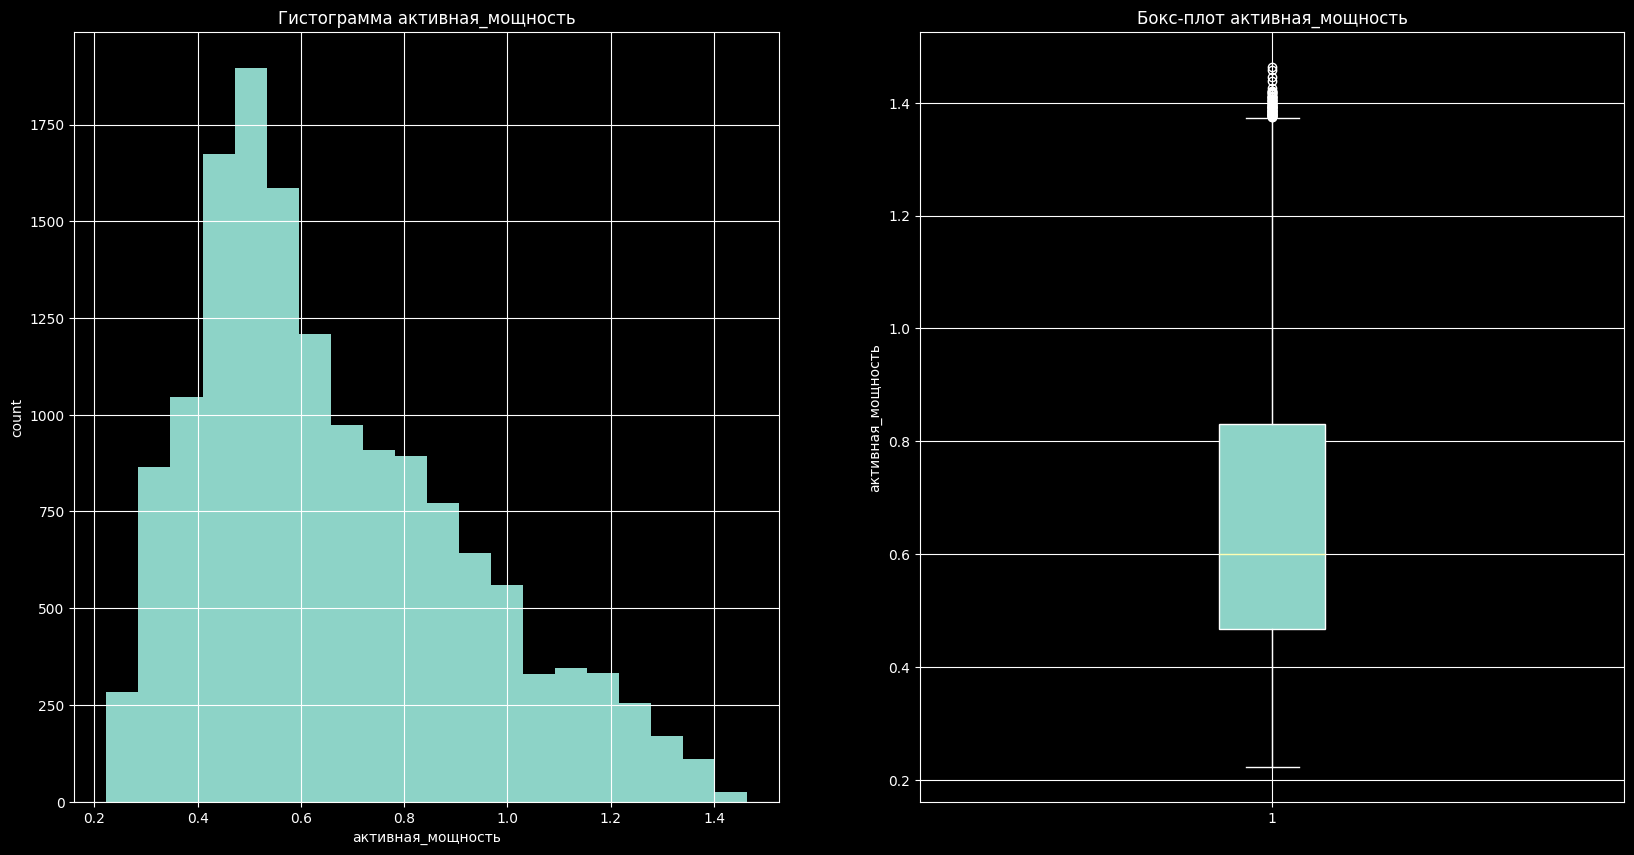


реактивная_мощность
count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: реактивная_мощность, dtype: float64


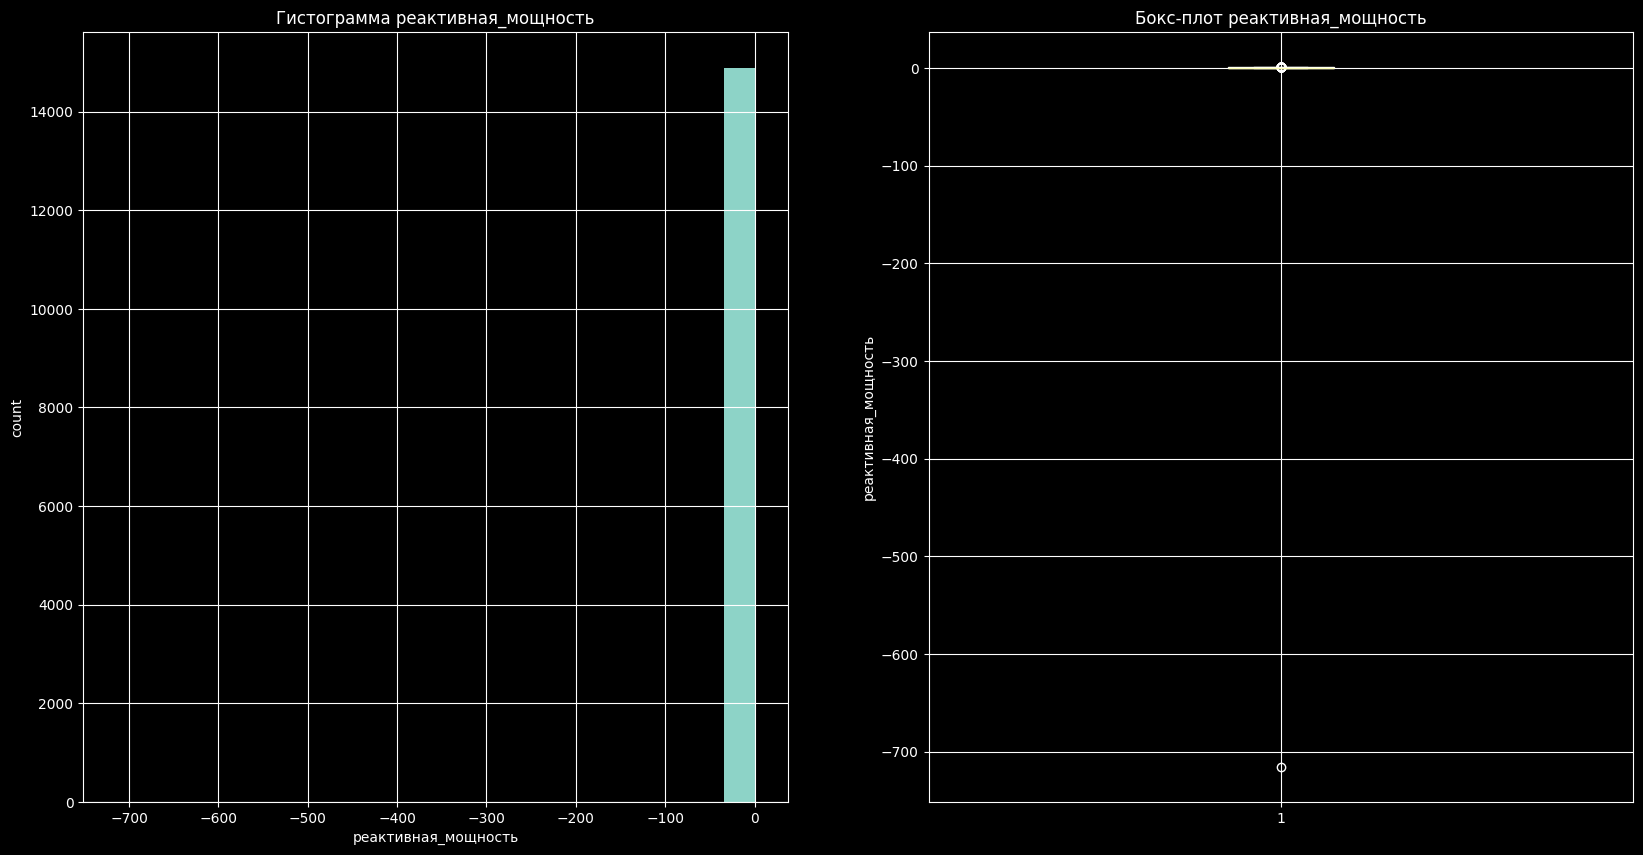

In [ ]:
for colum in ['активная_мощность', 'реактивная_мощность']:
    print(colum)
    print(df['data_arc'][colum].describe())
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    ax[0].hist(df['data_arc'][colum], bins=20)
    ax[0].set_title('Гистограмма ' + colum)
    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].grid(True)

    if df['data_arc'][colum].isna().sum() != 0:
        ax[1].boxplot(df['data_arc'][colum].fillna(df[colum].mean()), patch_artist=True)

    else:
        ax[1].boxplot(df['data_arc'][colum], patch_artist=True)

    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()
    print()

-**'активная_мощность'** напоминает нормальное распределение смещенное к левому краю, разброс варьируется от 0.22 до 1.46, в среднем 0.66

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'реактивная_мощность'** наблюдаем крайне аномальное отрицателное значение

In [ ]:
df['data_arc'][df['data_arc']['реактивная_мощность'] < 0]

key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
9780  2116  2019-07-28 02:22:08 2019-07-28 02:23:57           0.705344   

      реактивная_мощность  
9780          -715.479924

Заменим отрицаетельное значения исходя из среднего отношения от активной мощности:

In [ ]:
df['data_arc']['реактивная_мощность'].iloc[9780] = df['data_arc']['активная_мощность'].iloc[9780]*(
    df['data_arc'][df['data_arc'].index != 9780]['реактивная_мощность']/df['data_arc'][df['data_arc'].index != 9780]['активная_мощность']).mean()

In [ ]:
df['data_arc'].iloc[9780]

key                                    2116
начало_нагрева_дугой    2019-07-28 02:22:08
конец_нагрева_дугой     2019-07-28 02:23:57
активная_мощность                  0.705344
реактивная_мощность                0.518374
Name: 9780, dtype: object

реактивная_мощность
count    14876.000000
mean         0.487118
std          0.197606
min          0.153777
25%          0.337192
50%          0.441667
75%          0.608201
max          1.270284
Name: реактивная_мощность, dtype: float64


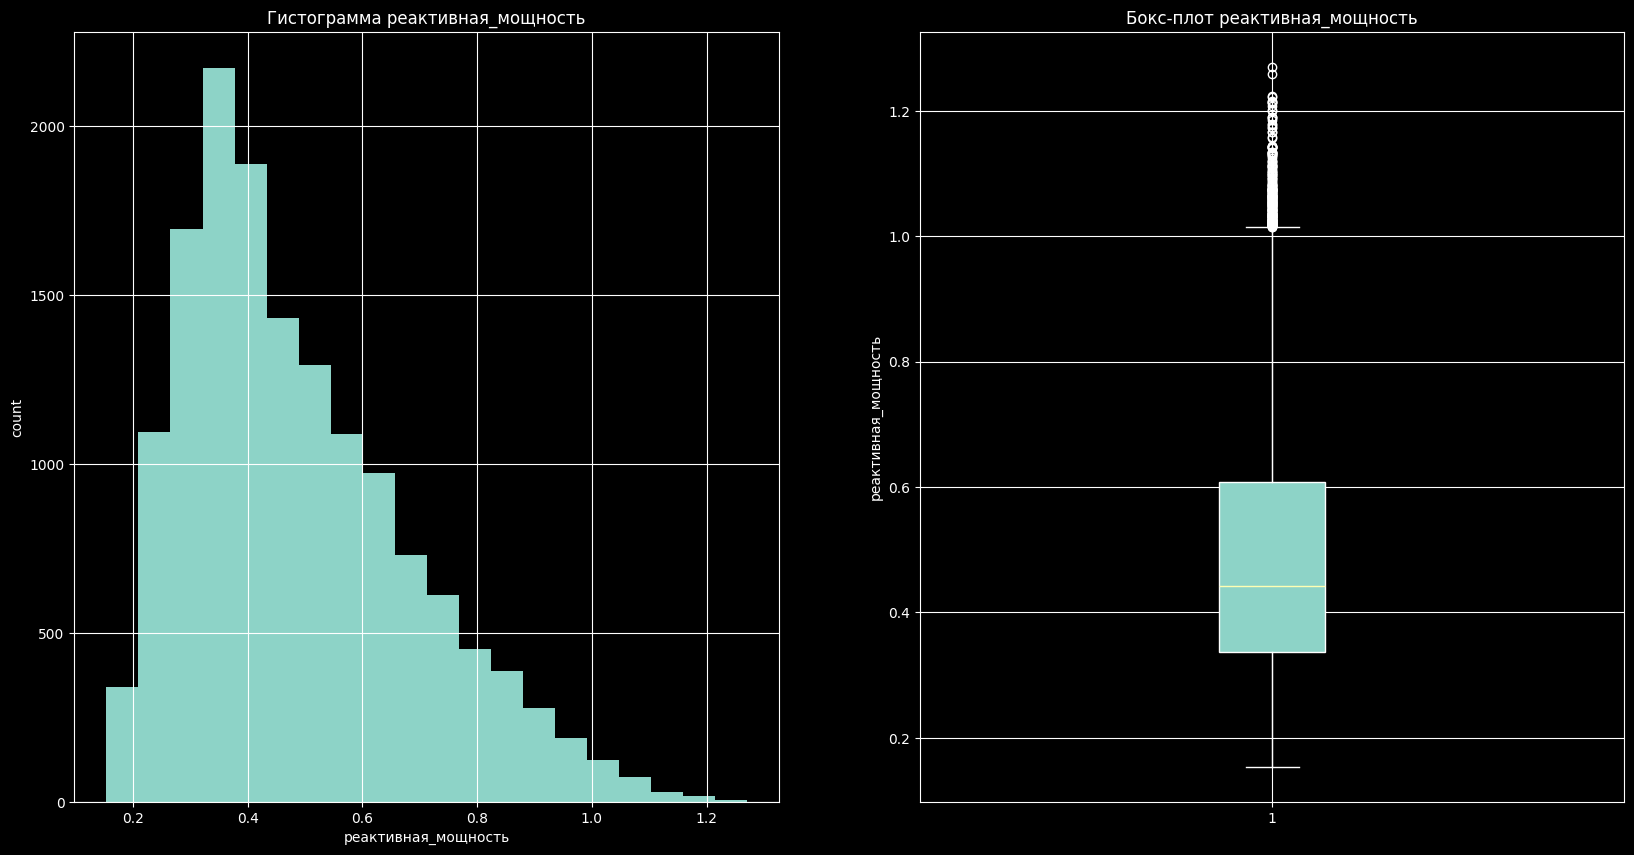

In [ ]:
colum = 'реактивная_мощность'
print(colum)
print(df['data_arc'][colum].describe())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].hist(df['data_arc'][colum], bins=20)
ax[0].set_title('Гистограмма ' + colum)
ax[0].set_xlabel(colum)
ax[0].set_ylabel('count')
ax[0].grid(True)

ax[1].boxplot(df['data_arc'][colum], patch_artist=True)
ax[1].set_ylabel(colum)
ax[1].set_title('Бокс-плот ' + colum)
ax[1].grid(True)
plt.show()
print()

-**'реактивная_мощность'** напоминает нормальное распределение смещенное к левому краю, разброс варьируется от 0.15 до 1.27, в среднем 0.48

Присутсвуют слегка выбивающиеся значения по правому краю распределения


#### data_bulk

In [ ]:
df['data_bulk']

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0        1.0     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1        2.0     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2        3.0     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3        4.0     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4        5.0     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
3124  3237.0     0.0     0.0   170.0     0.0     0.0     0.0     0.0     0.0   
3125  3238.0     0.0     0.0   126.0     0.0     0.0     0.0     0.0     0.0   
3126  3239.0     0.0     0.0     0.0     0.0     0.0   114.0     0.0     0.0   
3127  3240.0     0.0     0.0     0.0     0.0     0.0    26.0     0.0     0.0   
3128  3241.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0        0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1        0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2        0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3        0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4        0.0      0.0      0.0    203.0      0.0    151.0    152.0  
...      ...      ...      ...      ...      ...      ...      ...  
3124     0.0      0.0      0.0    252.0      0.0    130.0    206.0  
3125     0.0      0.0      0.0    254.0      0.0    108.0    106.0  
3126     0.0      0.0      0.0    158.0      0.0    270.0     88.0  
3127     0.0      0.0      0.0      0.0      0.0    192.0     54.0  
3128     0.0      0.0      0.0      0.0      0.0    180.0     52.0  

[3129 rows x 16 columns]

bulk_1
count    3129.000000
mean        3.160435
std        11.869164
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       185.000000
Name: bulk_1, dtype: float64


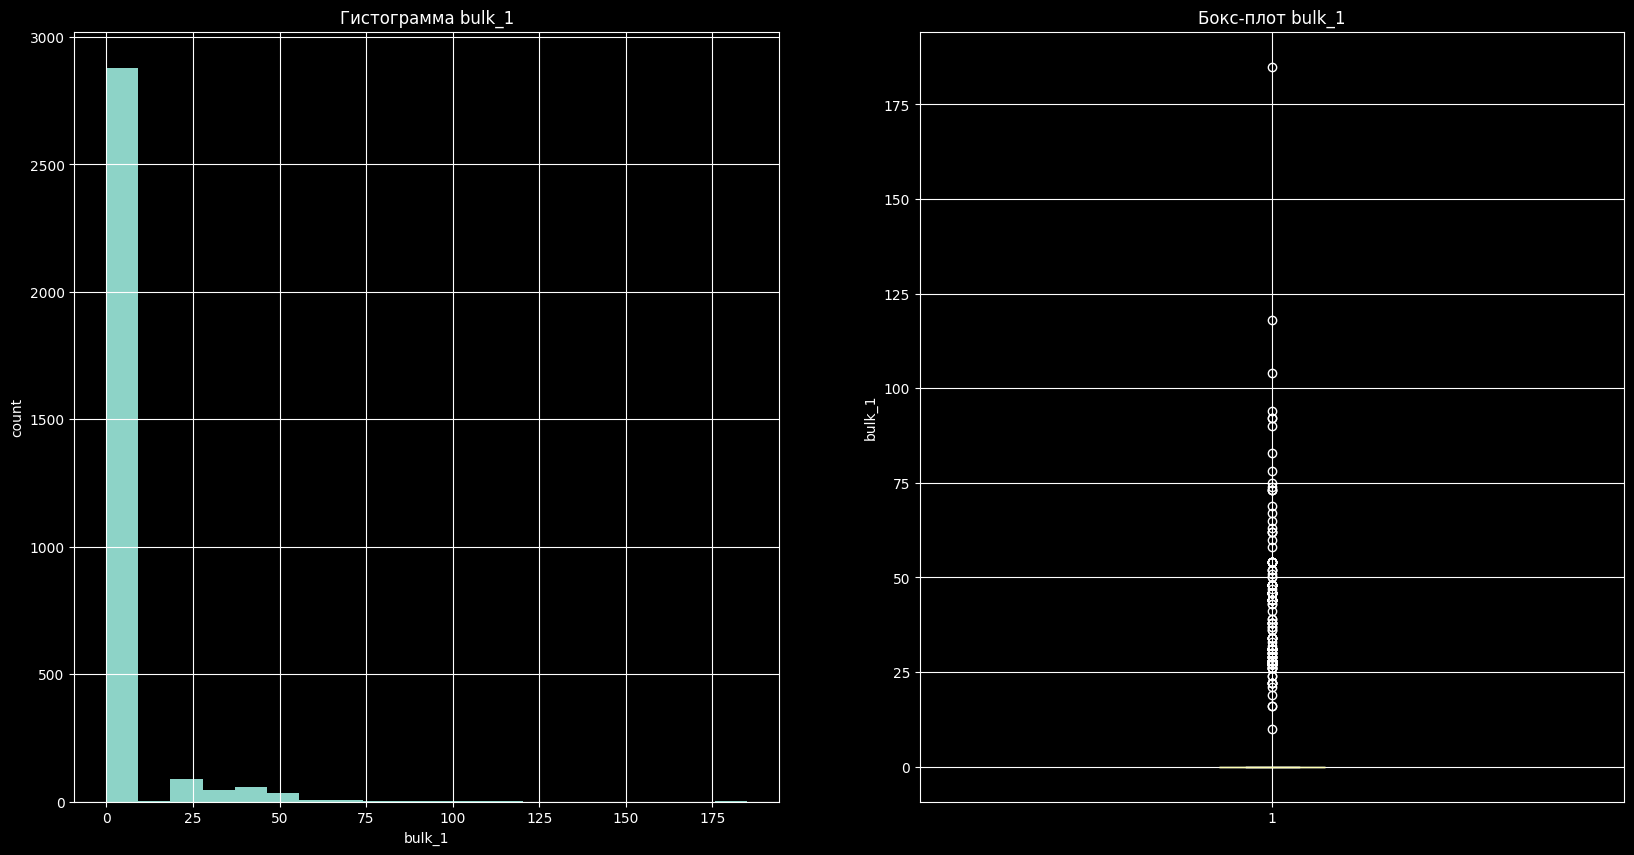


bulk_2
count    3129.000000
mean        1.779163
std        21.217878
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       325.000000
Name: bulk_2, dtype: float64


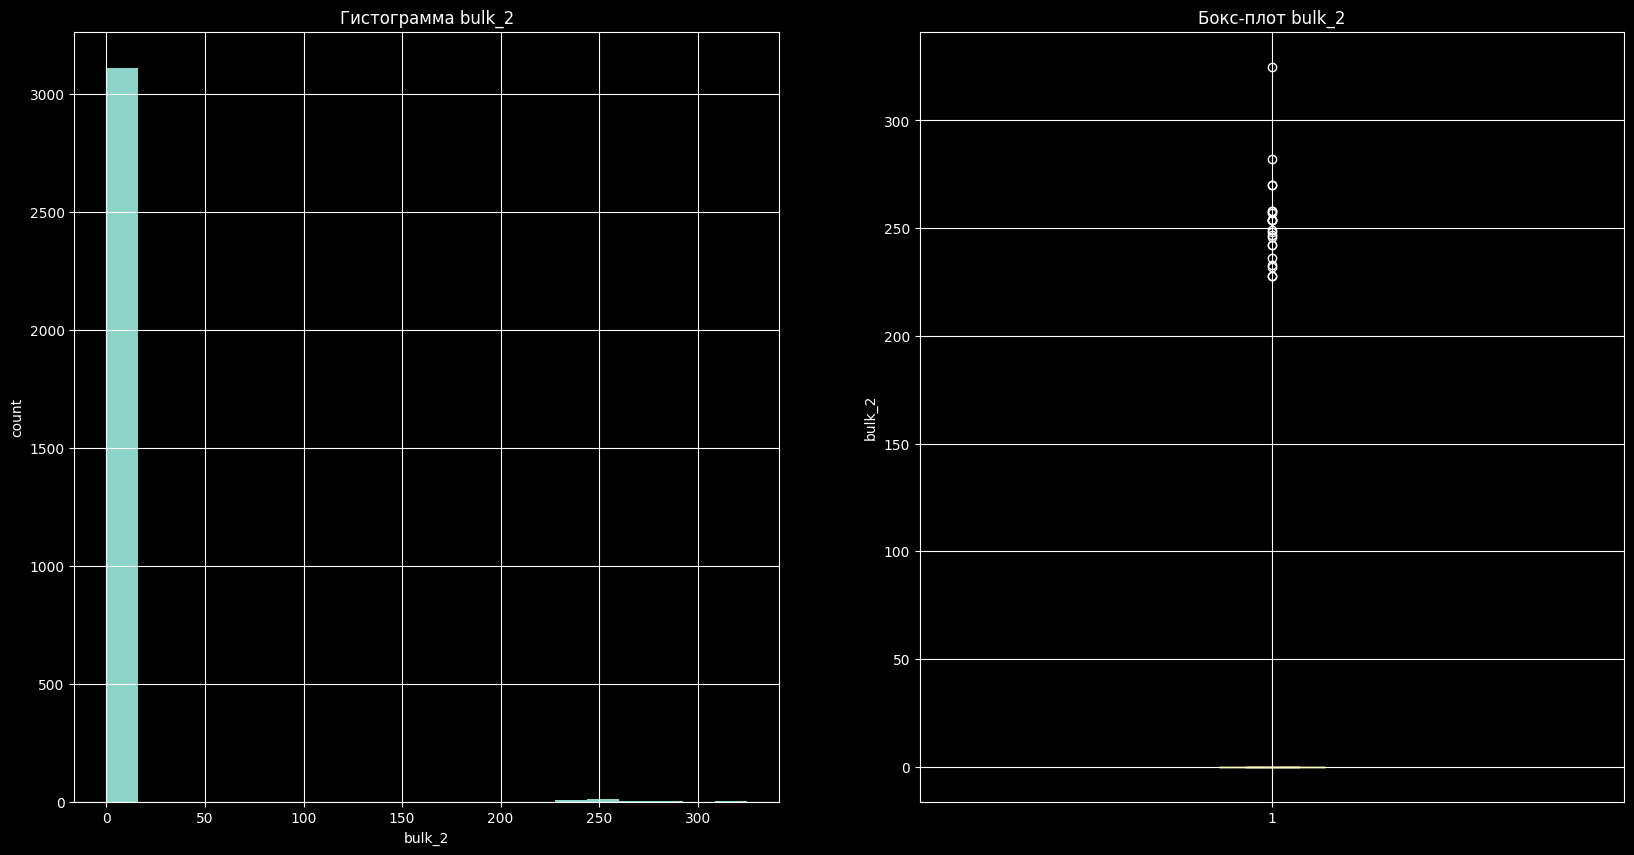


bulk_3
count    3129.000000
mean       47.240332
std        74.239954
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: bulk_3, dtype: float64


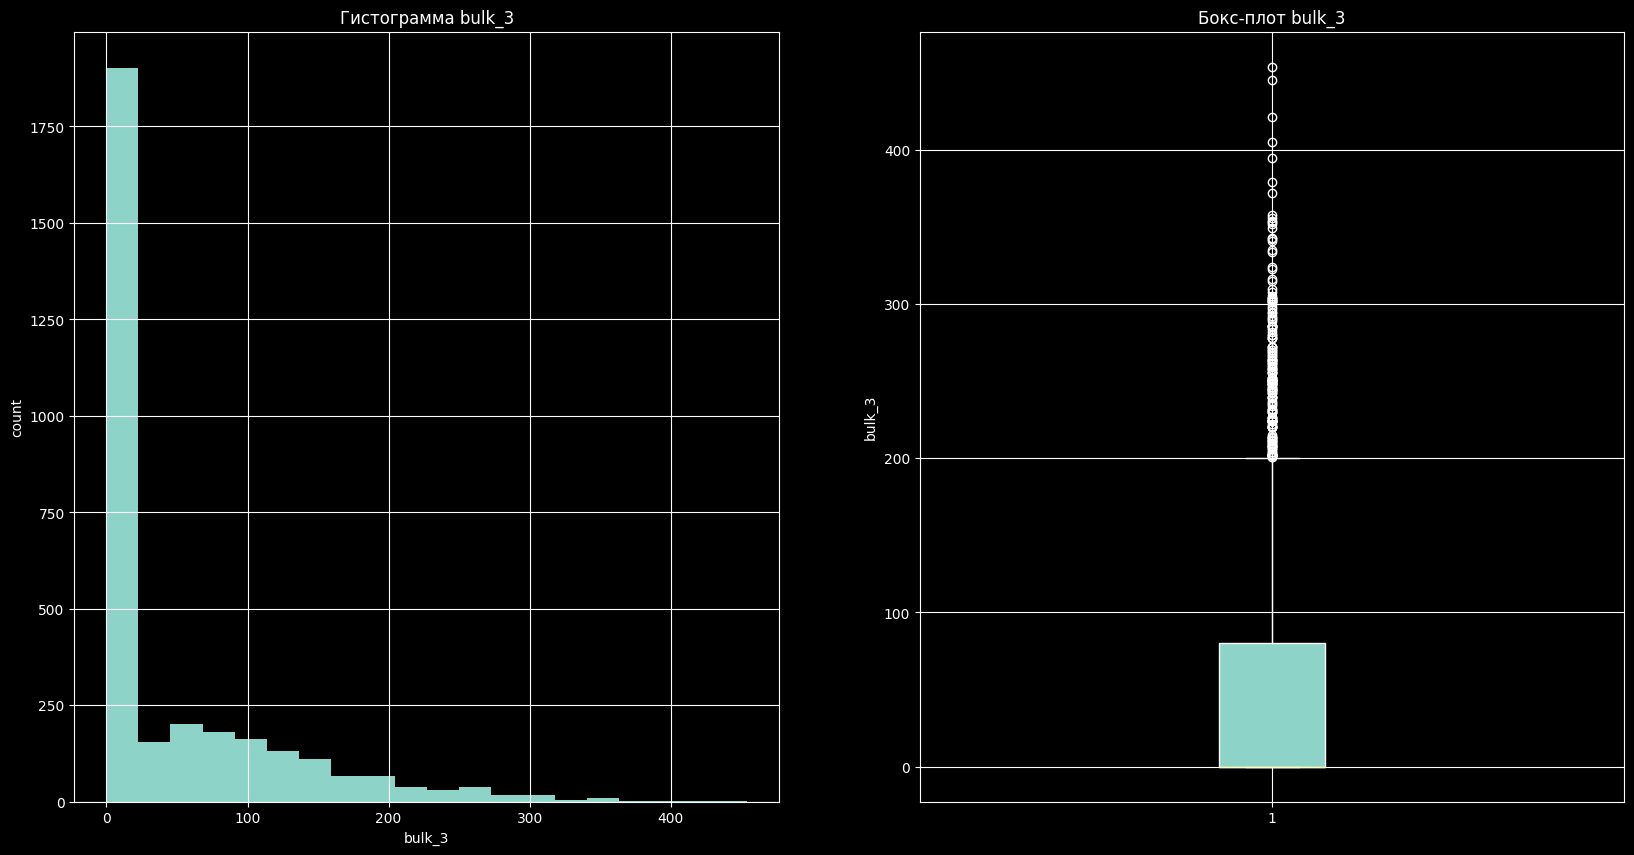


bulk_4
count    3129.000000
mean       33.830617
std        56.034505
min         0.000000
25%         0.000000
50%         0.000000
75%        68.000000
max       281.000000
Name: bulk_4, dtype: float64


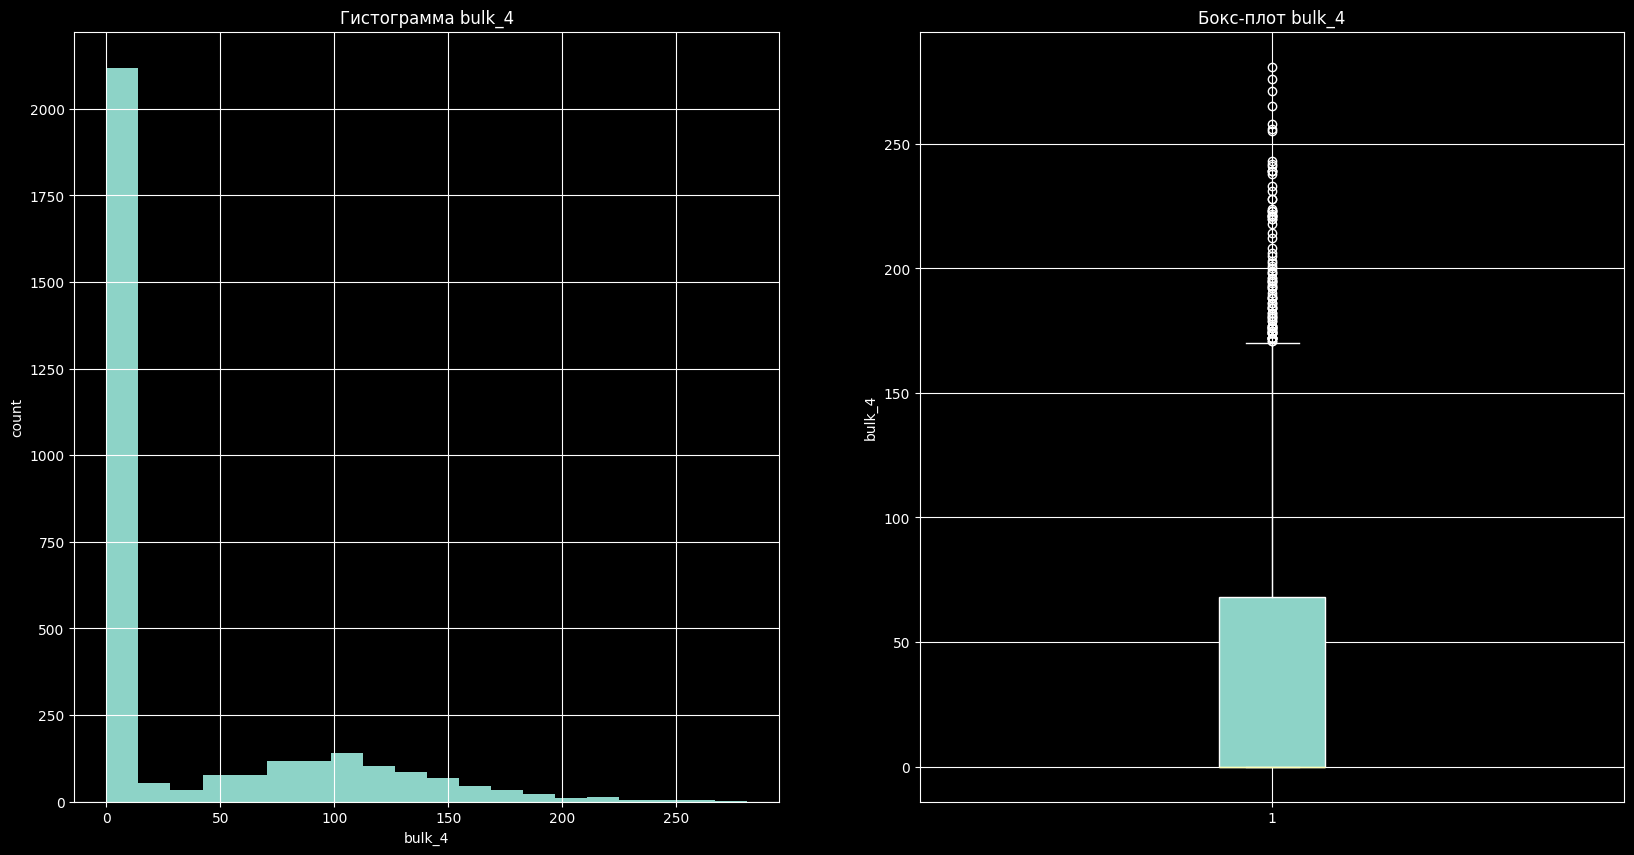


bulk_5
count    3129.000000
mean        2.633749
std        20.918138
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       603.000000
Name: bulk_5, dtype: float64


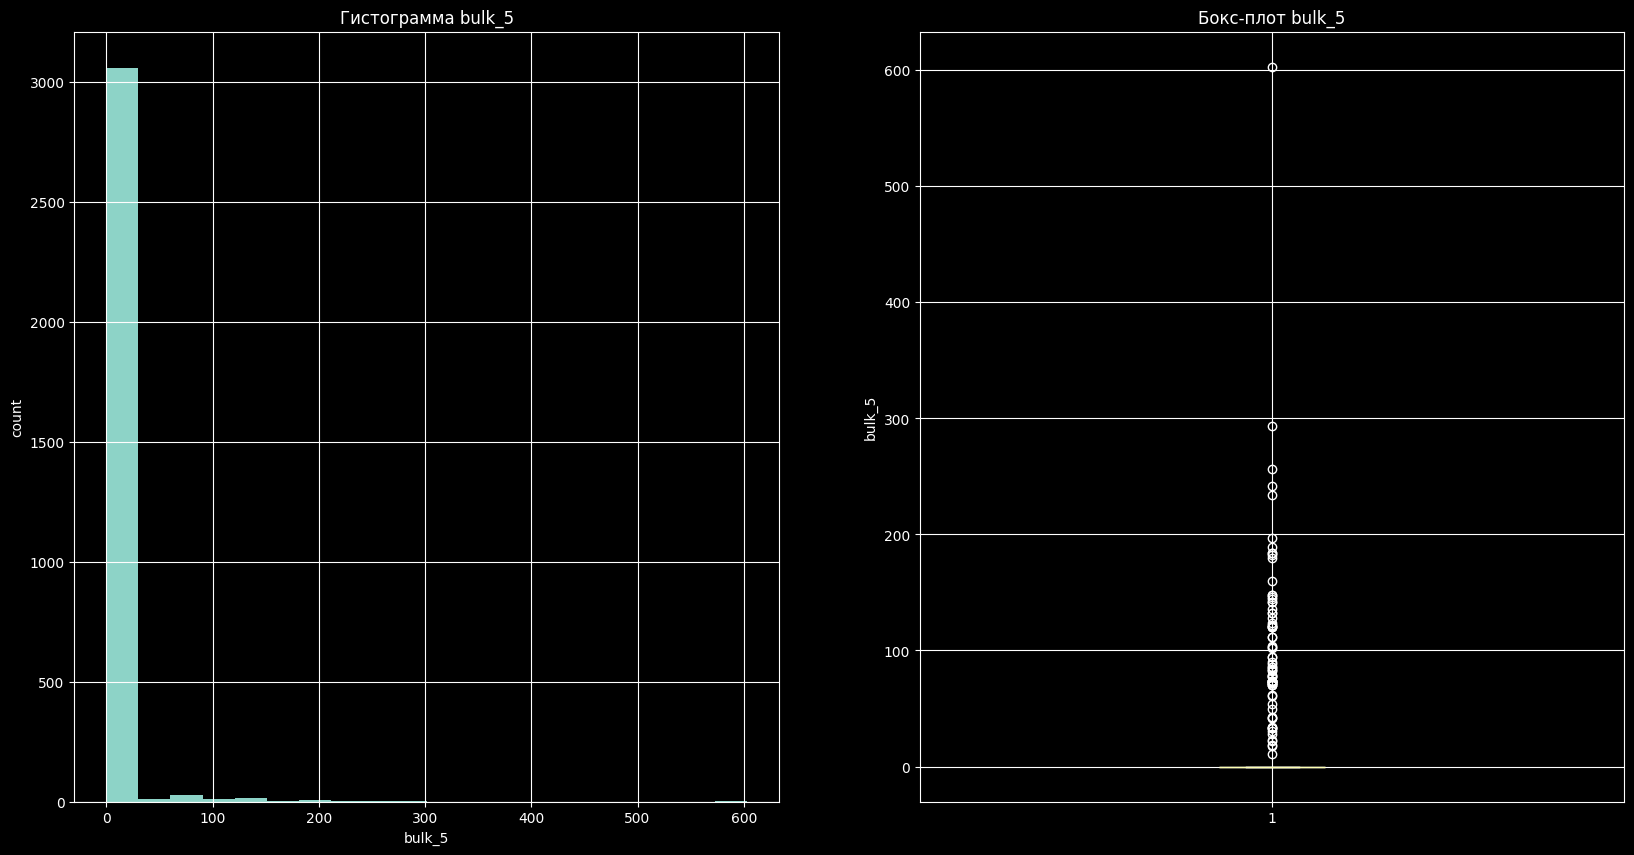


bulk_6
count    3129.000000
mean       21.892298
std        55.492582
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       503.000000
Name: bulk_6, dtype: float64


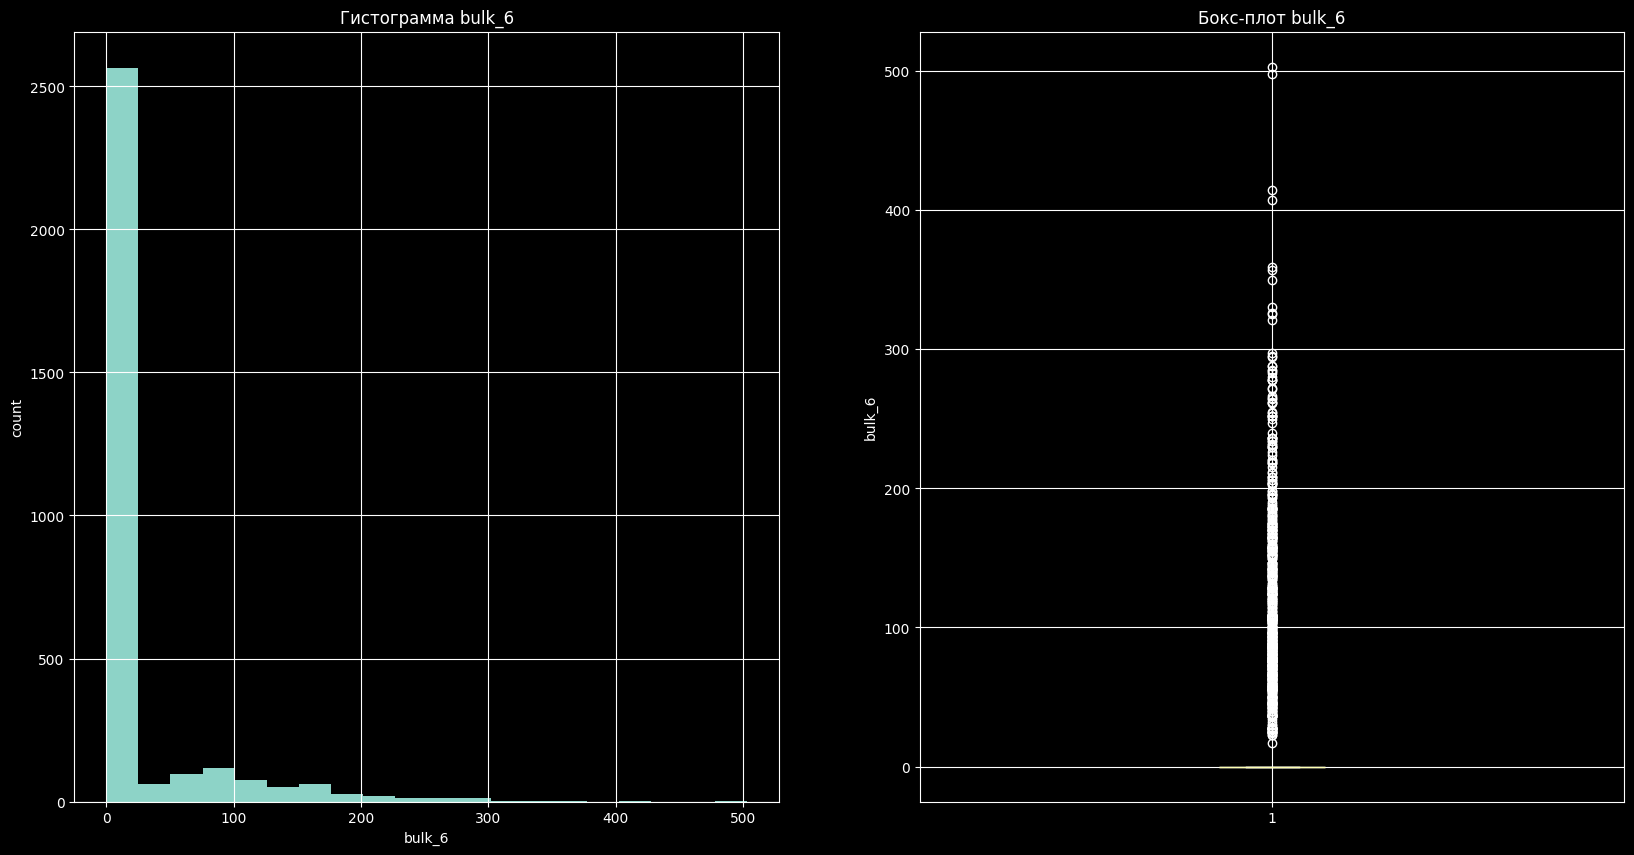


bulk_7
count    3129.000000
mean        2.441675
std        31.944063
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       772.000000
Name: bulk_7, dtype: float64


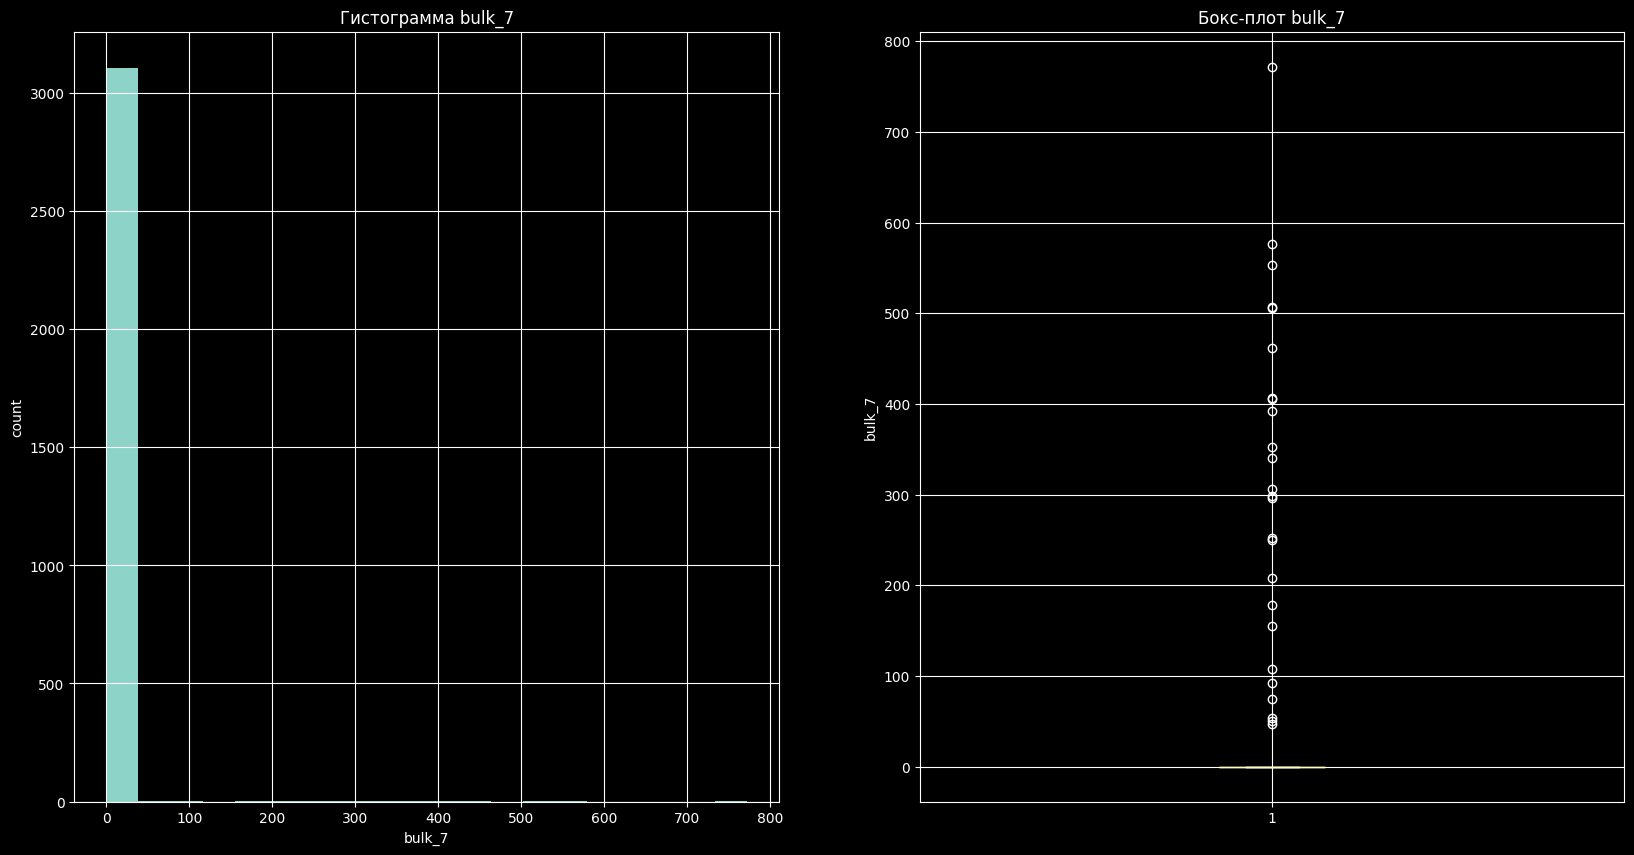


bulk_8
count    3129.000000
mean        0.015660
std         0.875978
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        49.000000
Name: bulk_8, dtype: float64


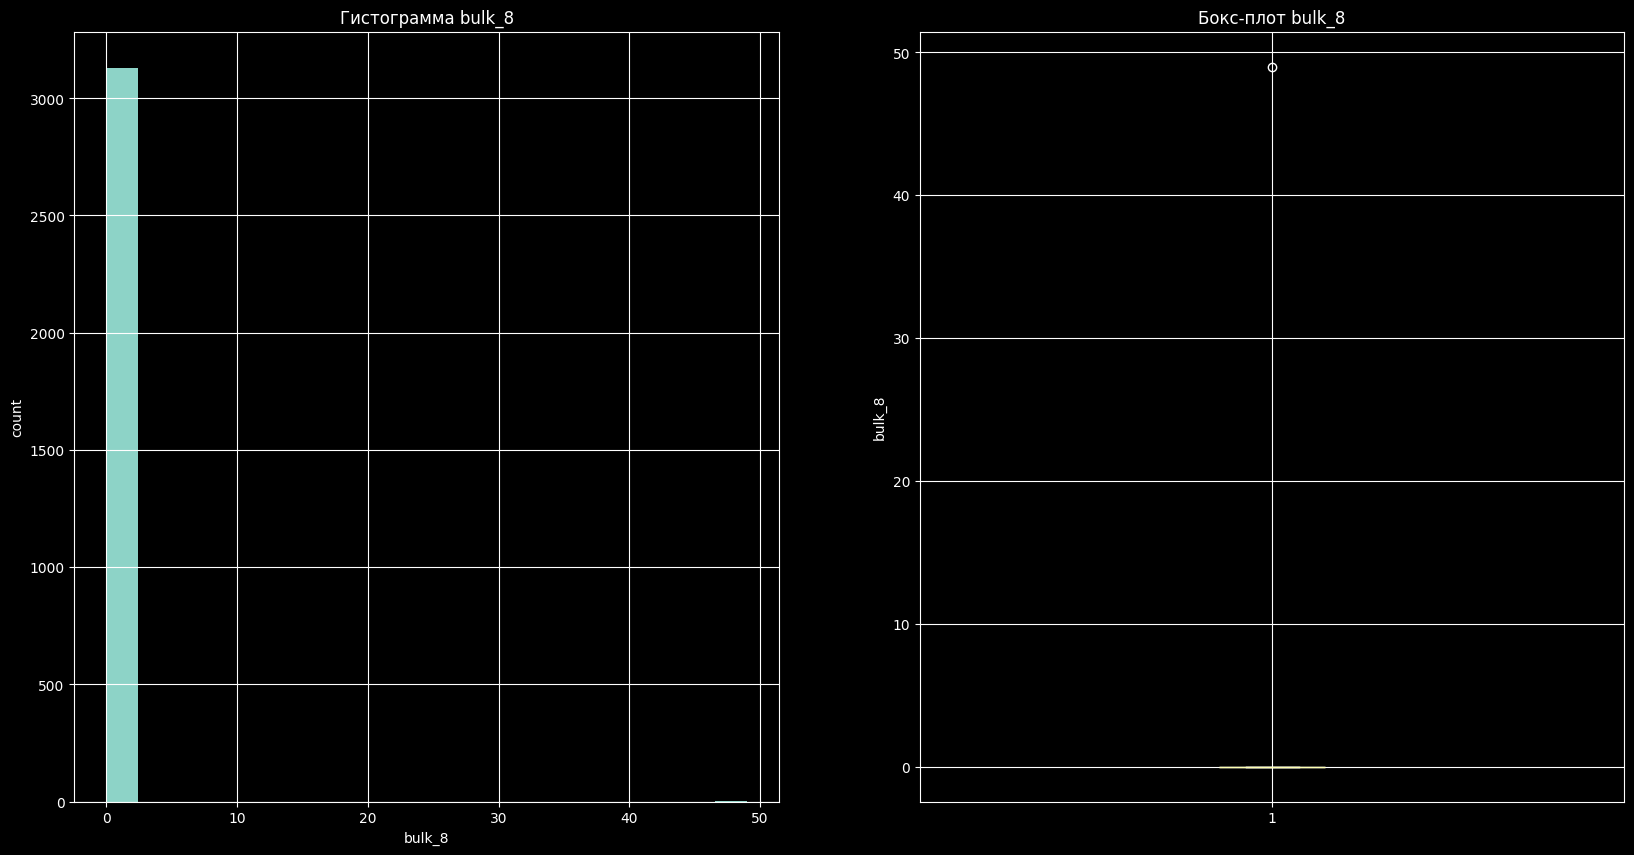


bulk_9
count    3129.000000
mean        0.463407
std         6.154398
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       147.000000
Name: bulk_9, dtype: float64


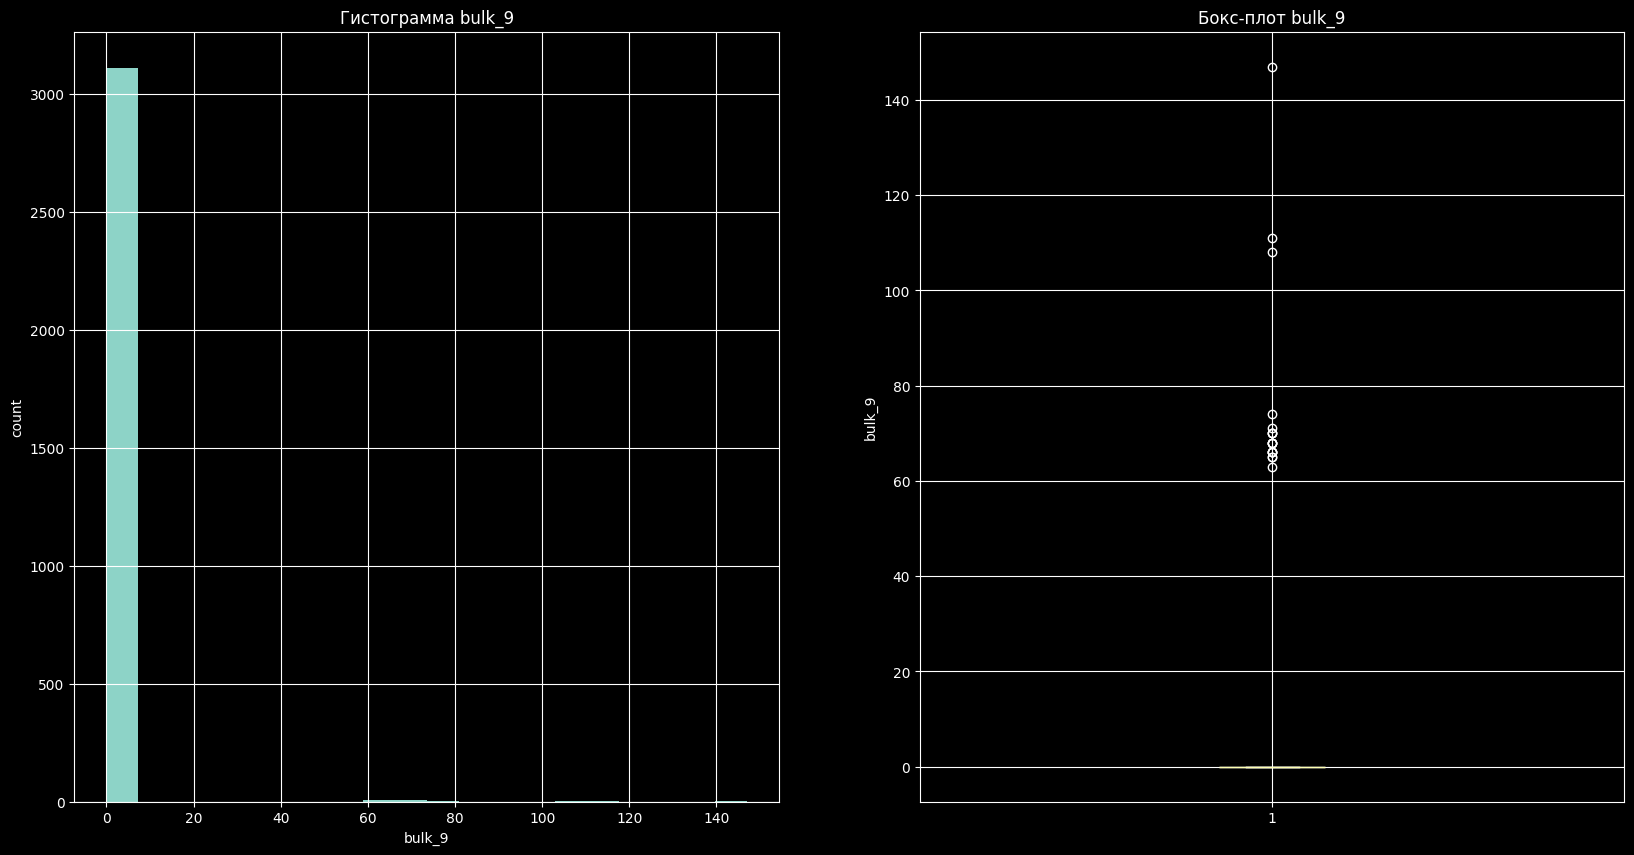


bulk_10
count    3129.000000
mean        4.684564
std        20.157323
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       159.000000
Name: bulk_10, dtype: float64


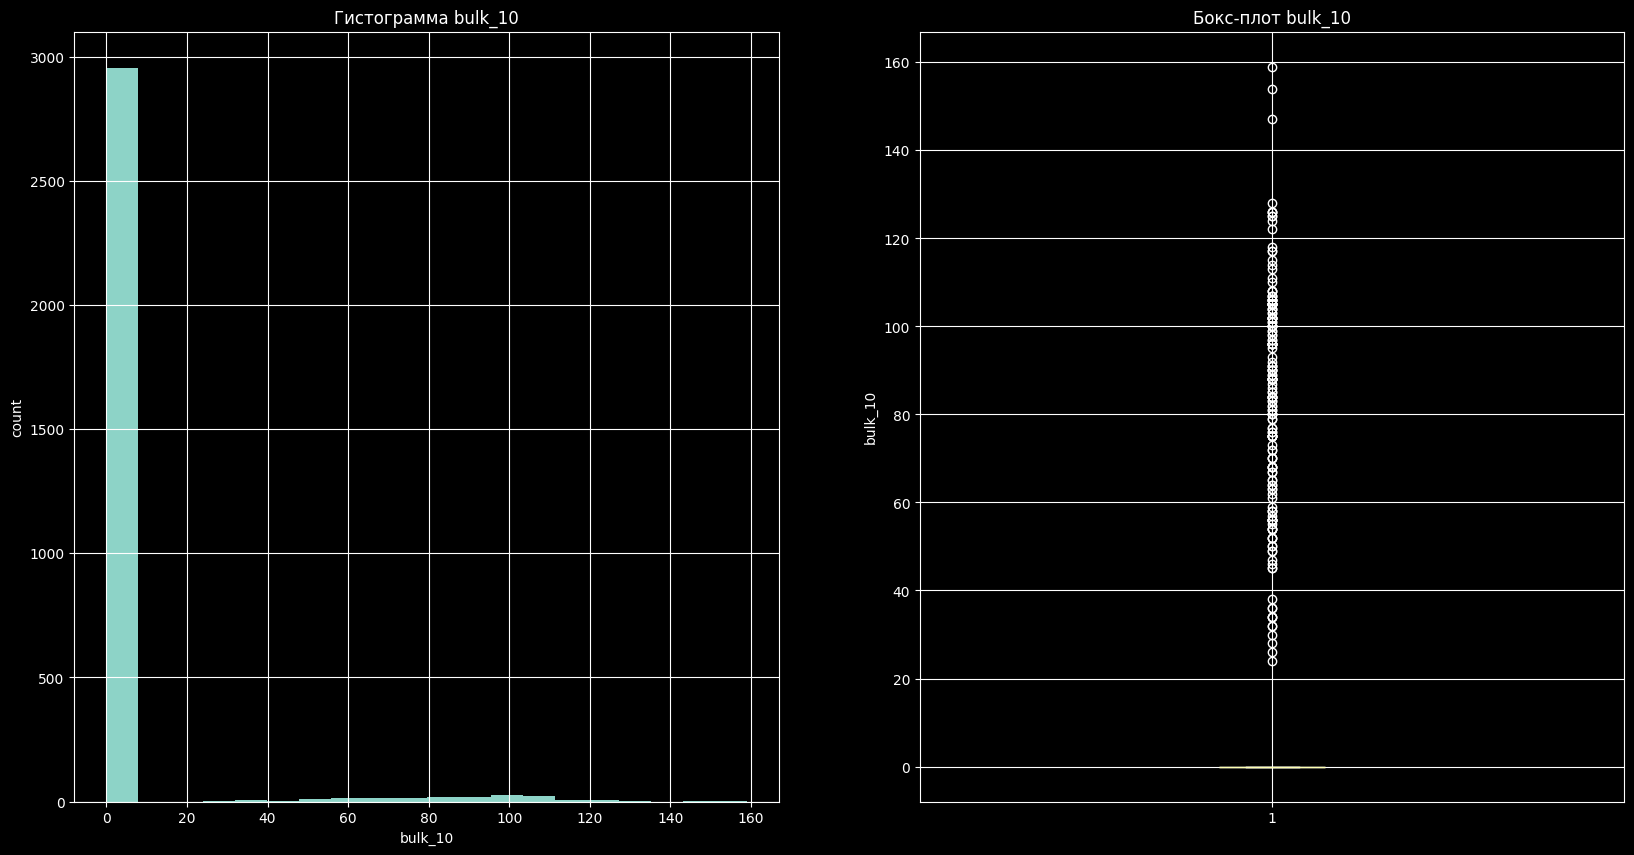


bulk_11
count    3129.000000
mean        4.345478
std        22.699580
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       313.000000
Name: bulk_11, dtype: float64


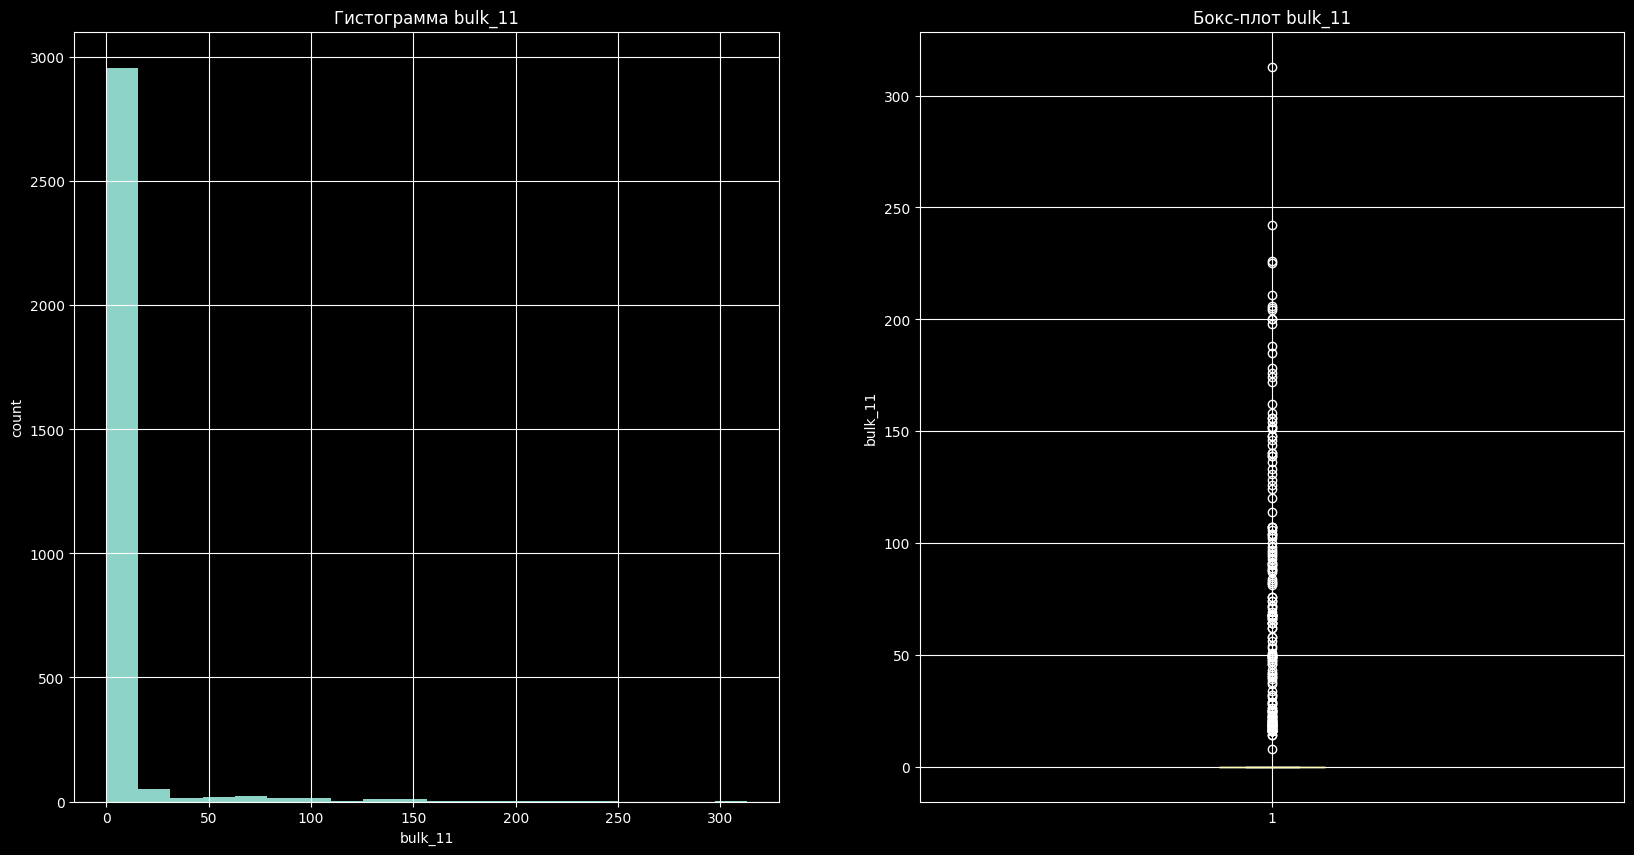


bulk_12
count    3129.000000
mean      203.948226
std       151.419639
min         0.000000
25%       105.000000
50%       206.000000
75%       263.000000
max      1849.000000
Name: bulk_12, dtype: float64


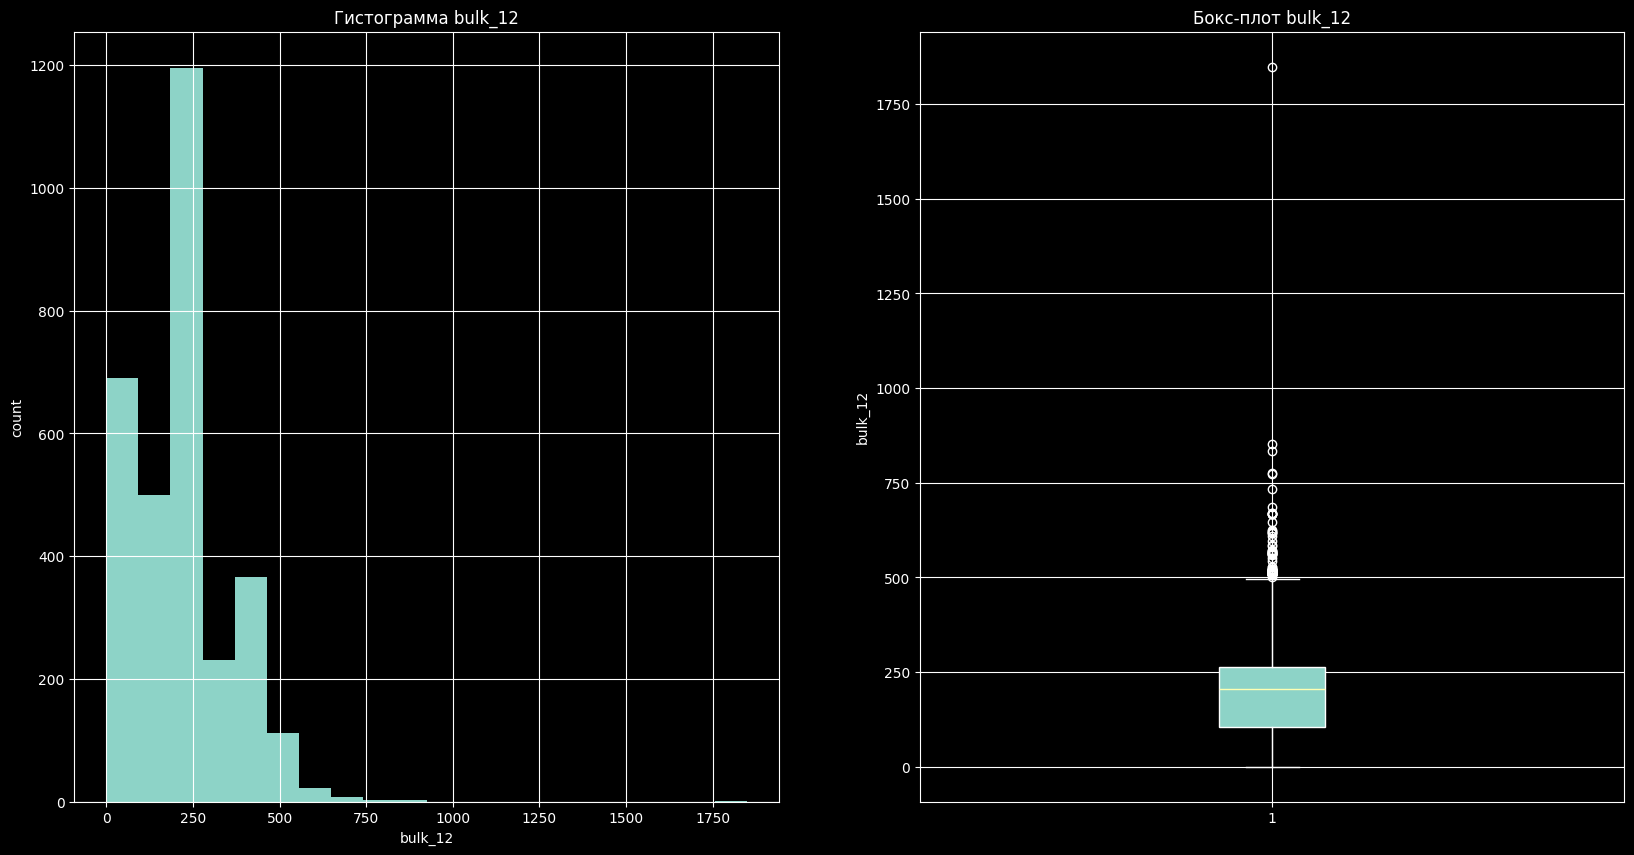


bulk_13
count    3129.000000
mean        1.041866
std        14.114252
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       305.000000
Name: bulk_13, dtype: float64


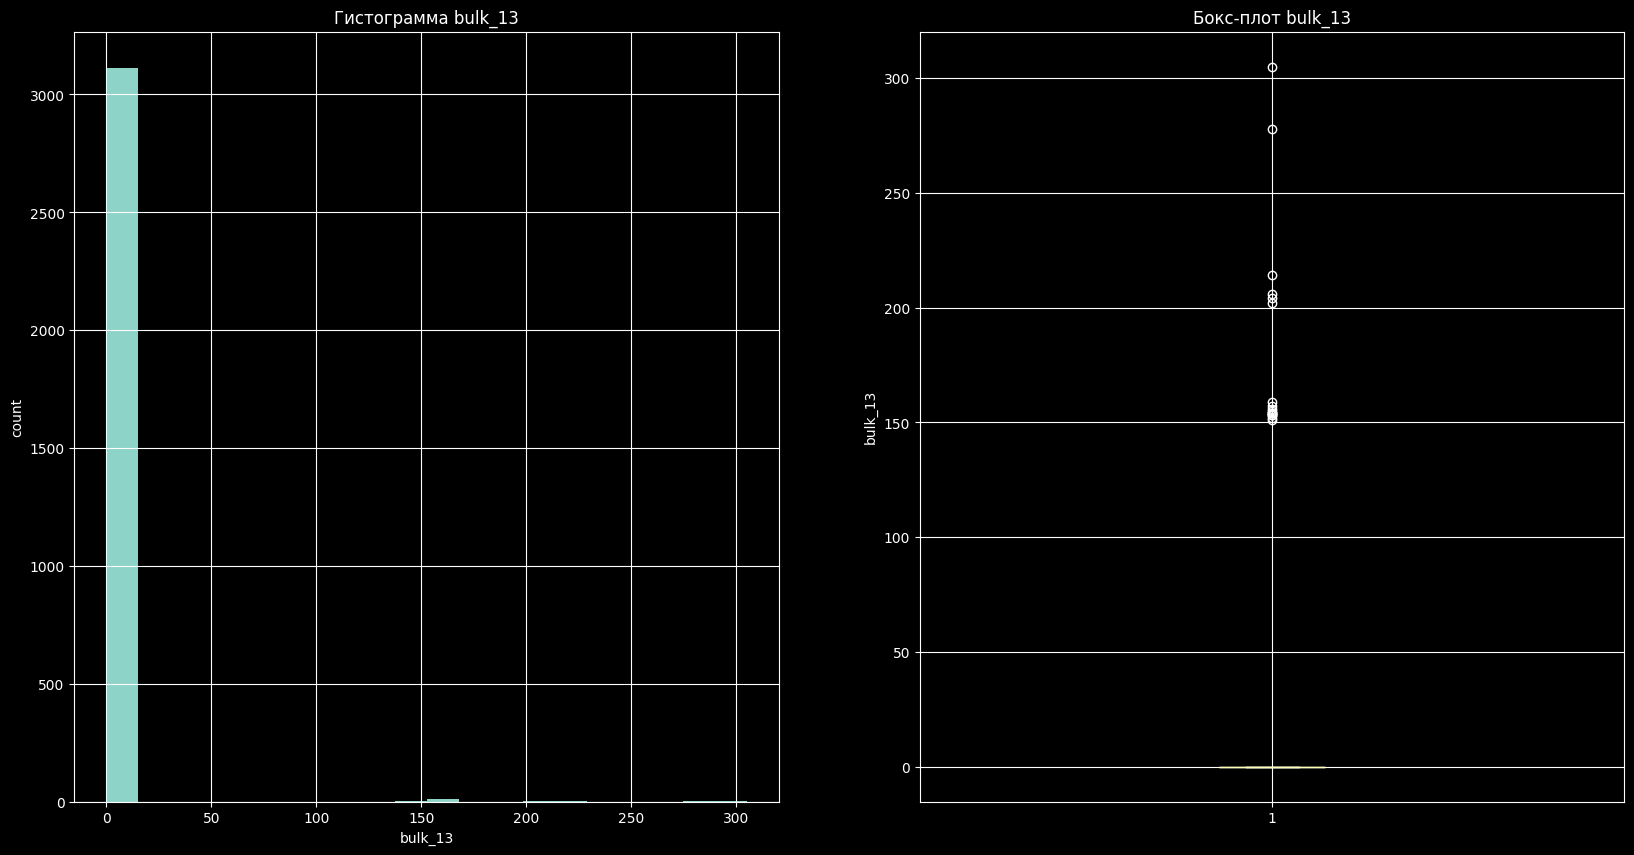


bulk_14
count    3129.000000
mean      152.706616
std        81.091421
min         0.000000
25%       104.000000
50%       148.000000
75%       202.000000
max       636.000000
Name: bulk_14, dtype: float64


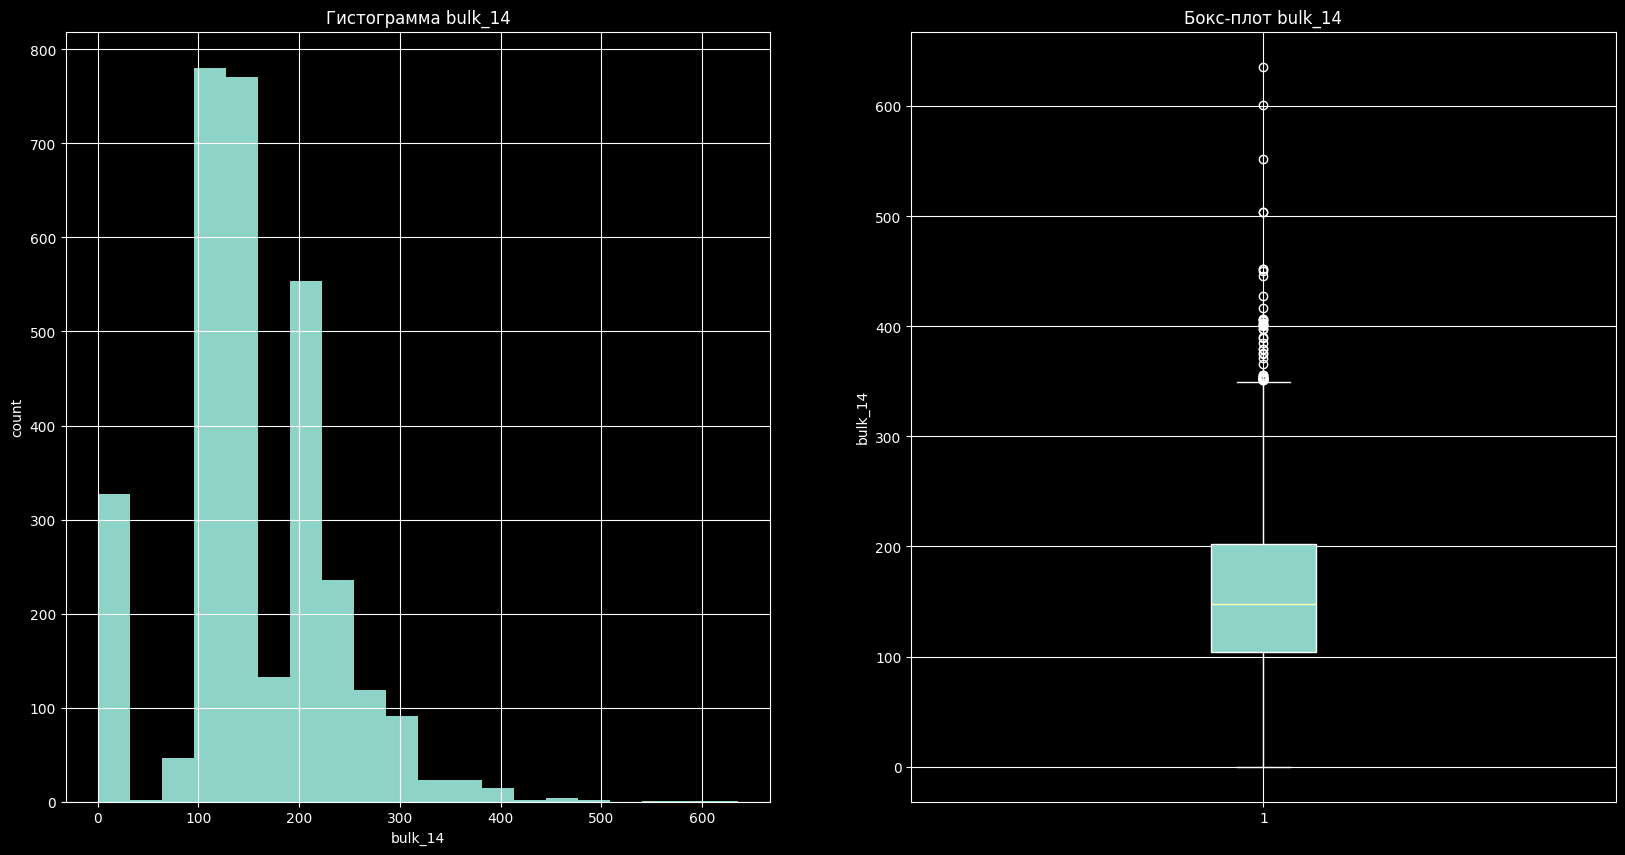


bulk_15
count    3129.000000
mean      115.319271
std        84.488698
min         0.000000
25%         0.000000
50%       106.000000
75%       204.000000
max       405.000000
Name: bulk_15, dtype: float64


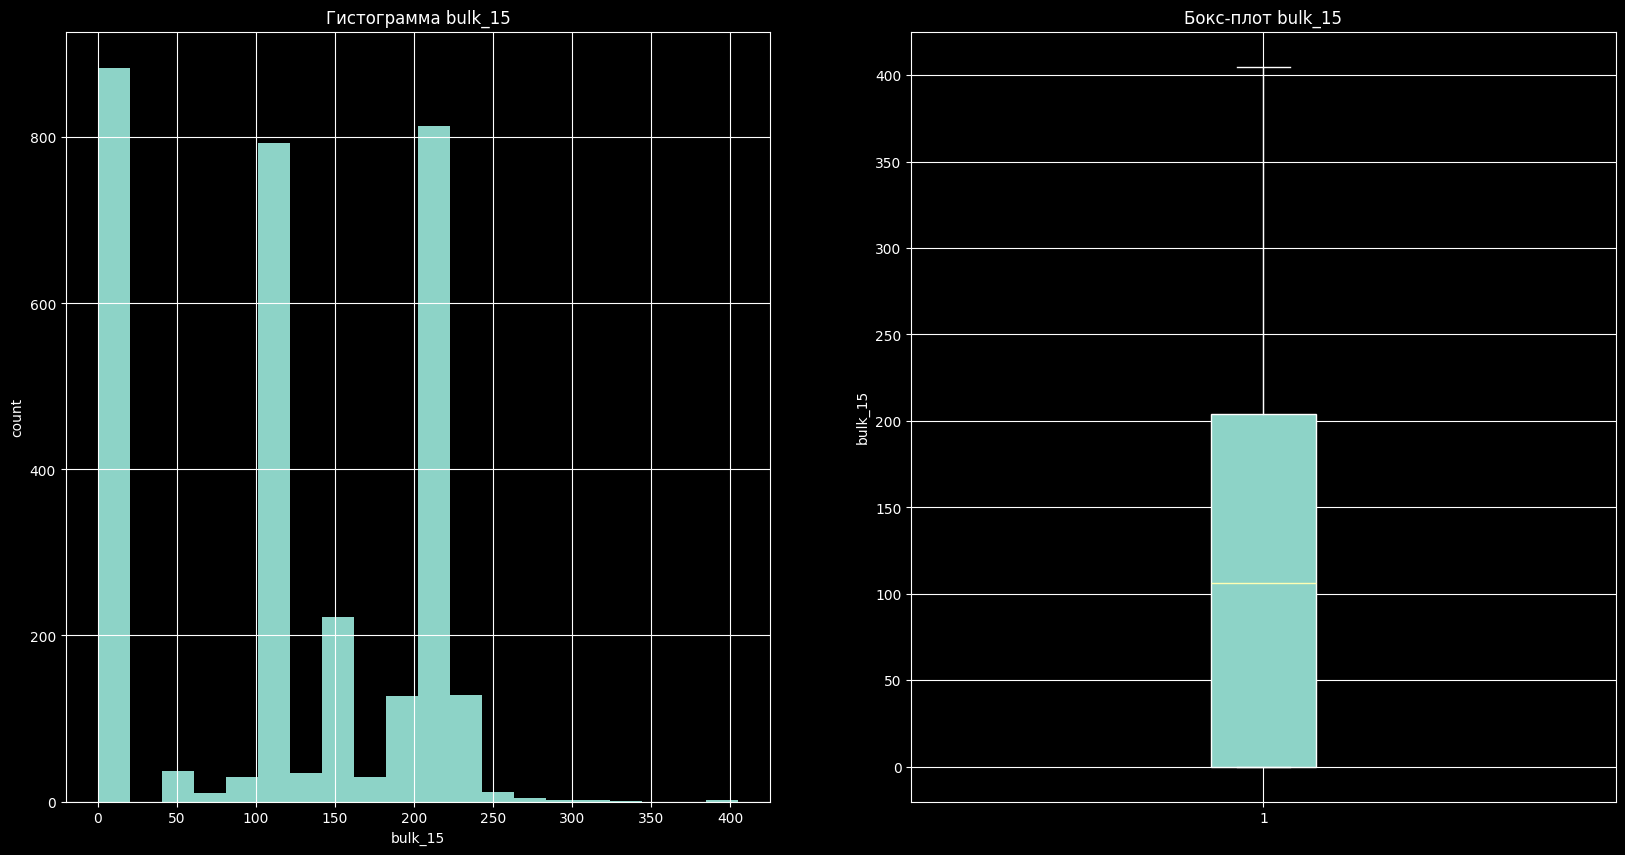

In [ ]:
for colum in df['data_bulk'].columns:
    if colum != 'key':
        print(colum)
        print(df['data_bulk'][colum].describe())
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

        ax[0].hist(df['data_bulk'][colum], bins=20)
        ax[0].set_title('Гистограмма ' + colum)
        ax[0].set_xlabel(colum)
        ax[0].set_ylabel('count')
        ax[0].grid(True)

        ax[1].boxplot(df['data_bulk'][colum], patch_artist=True)
        ax[1].set_ylabel(colum)
        ax[1].set_title('Бокс-плот ' + colum)
        ax[1].grid(True)
        plt.show()
        print()

В большинстве колонок bulk наблюдаем сильно смещенную гистограмму к левому краю из за большого наличия 0-ых значений, максимальные значения ~500.

Везде наблюдаем аномальные значения по правому краю распределения кроме bulk_15

#### data_gas

In [ ]:
df['data_gas'].head()

key      газ_1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

газ_1
count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: газ_1, dtype: float64


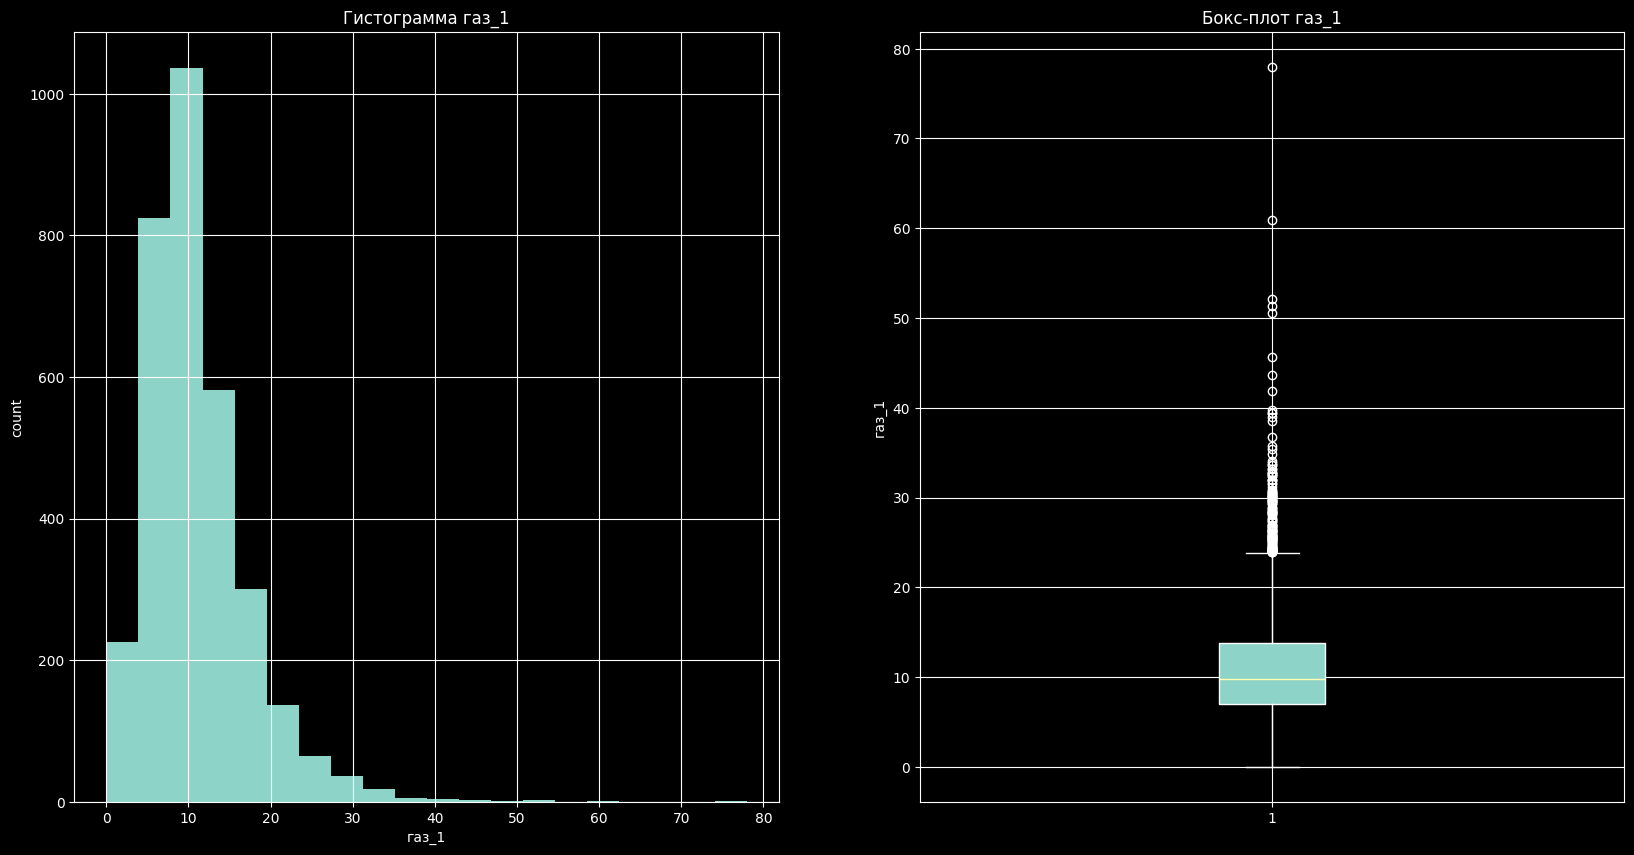

In [ ]:
colum = 'газ_1'
print(colum)
print(df['data_gas'][colum].describe())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].hist(df['data_gas'][colum], bins=20)
ax[0].set_title('Гистограмма ' + colum)
ax[0].set_xlabel(colum)
ax[0].set_ylabel('count')
ax[0].grid(True)

ax[1].boxplot(df['data_gas'][colum], patch_artist=True)
ax[1].set_ylabel(colum)
ax[1].set_title('Бокс-плот ' + colum)
ax[1].grid(True)
plt.show()
print()

-**'газ_1'** напоминает нормальное распределение смещенное к левому краю, разброс варьируется от 0.01 до 78, в среднем 11

Присутсвуют слегка выбивающиеся значения по правому краю распределения

#### data_temp

In [ ]:
df['data_temp'].head()

key        время_замера  температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0

In [ ]:
df['data_temp']['температура']

0        1571.0
1        1604.0
2        1618.0
3        1601.0
4        1606.0
          ...  
18061    1569.0
18067    1584.0
18071    1598.0
18080    1617.0
18086    1586.0
Name: температура, Length: 14660, dtype: float64

температура
count    14660.000000
mean      1590.852729
std         19.143141
min       1515.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: температура, dtype: float64


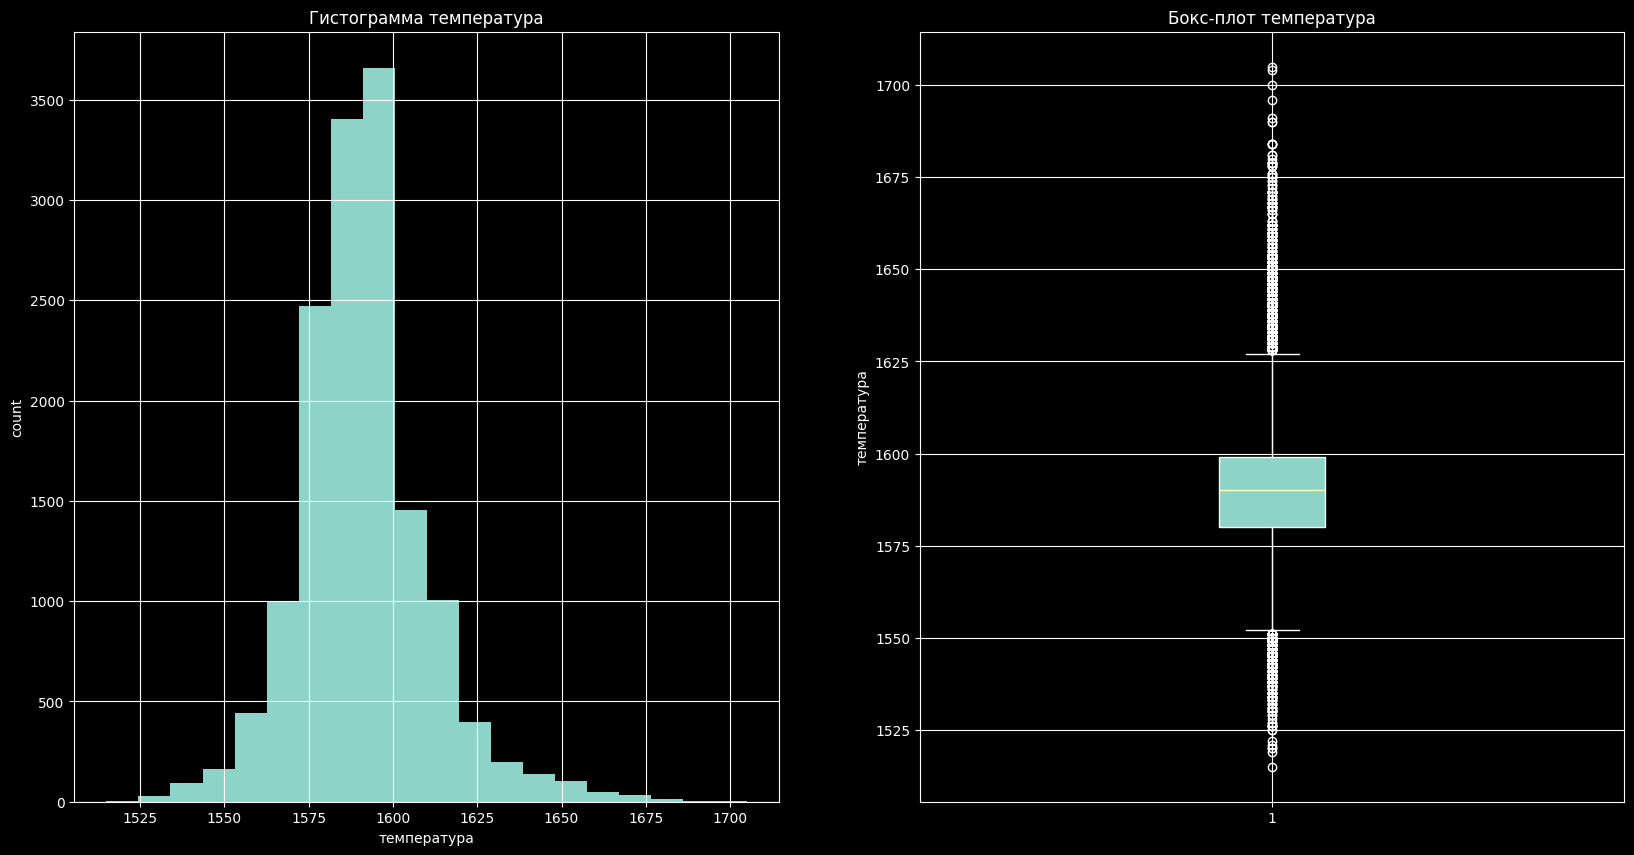

In [ ]:
colum = 'температура'
print(colum)
print(df['data_temp'][colum].describe())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].hist(df['data_temp'][colum], bins=20)
ax[0].set_title('Гистограмма ' + colum)
ax[0].set_xlabel(colum)
ax[0].set_ylabel('count')
ax[0].grid(True)

ax[1].boxplot(df['data_temp'][colum], patch_artist=True)
ax[1].set_ylabel(colum)
ax[1].set_title('Бокс-плот ' + colum)
ax[1].grid(True)
plt.show()
print()

-**'температура'** напоминает нормальное распределение значения которого смещенны к центру распределения, разброс варьируется от 1515 до 1705, в среднем 1590

Присутсвуют слегка выбивающиеся значения по краям распределения

#### data_wire

In [ ]:
df['data_wire'].head()

key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0  1.0  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1  2.0  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2  3.0  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3  4.0  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4  5.0  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   wire_9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

wire_1
count    3081.000000
mean      100.044411
std        42.841120
min         0.000000
25%        70.281120
50%       100.114563
75%       125.798405
max       330.314424
Name: wire_1, dtype: float64


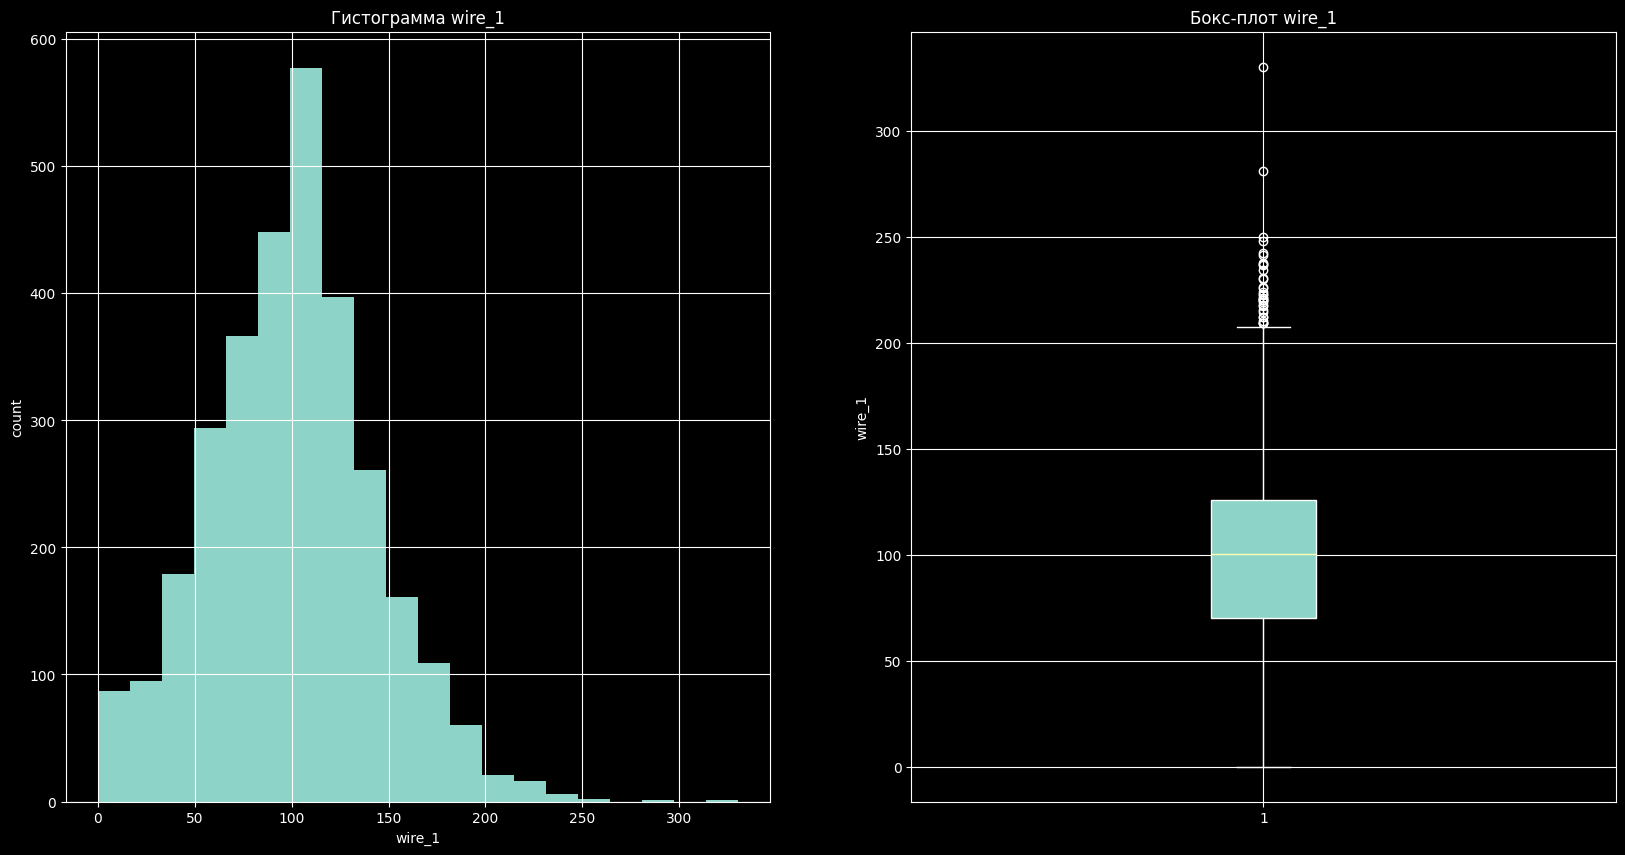


wire_2
count    3081.000000
mean       17.712733
std        33.517734
min         0.000000
25%         0.000000
50%         0.000000
75%        23.162880
max       282.780152
Name: wire_2, dtype: float64


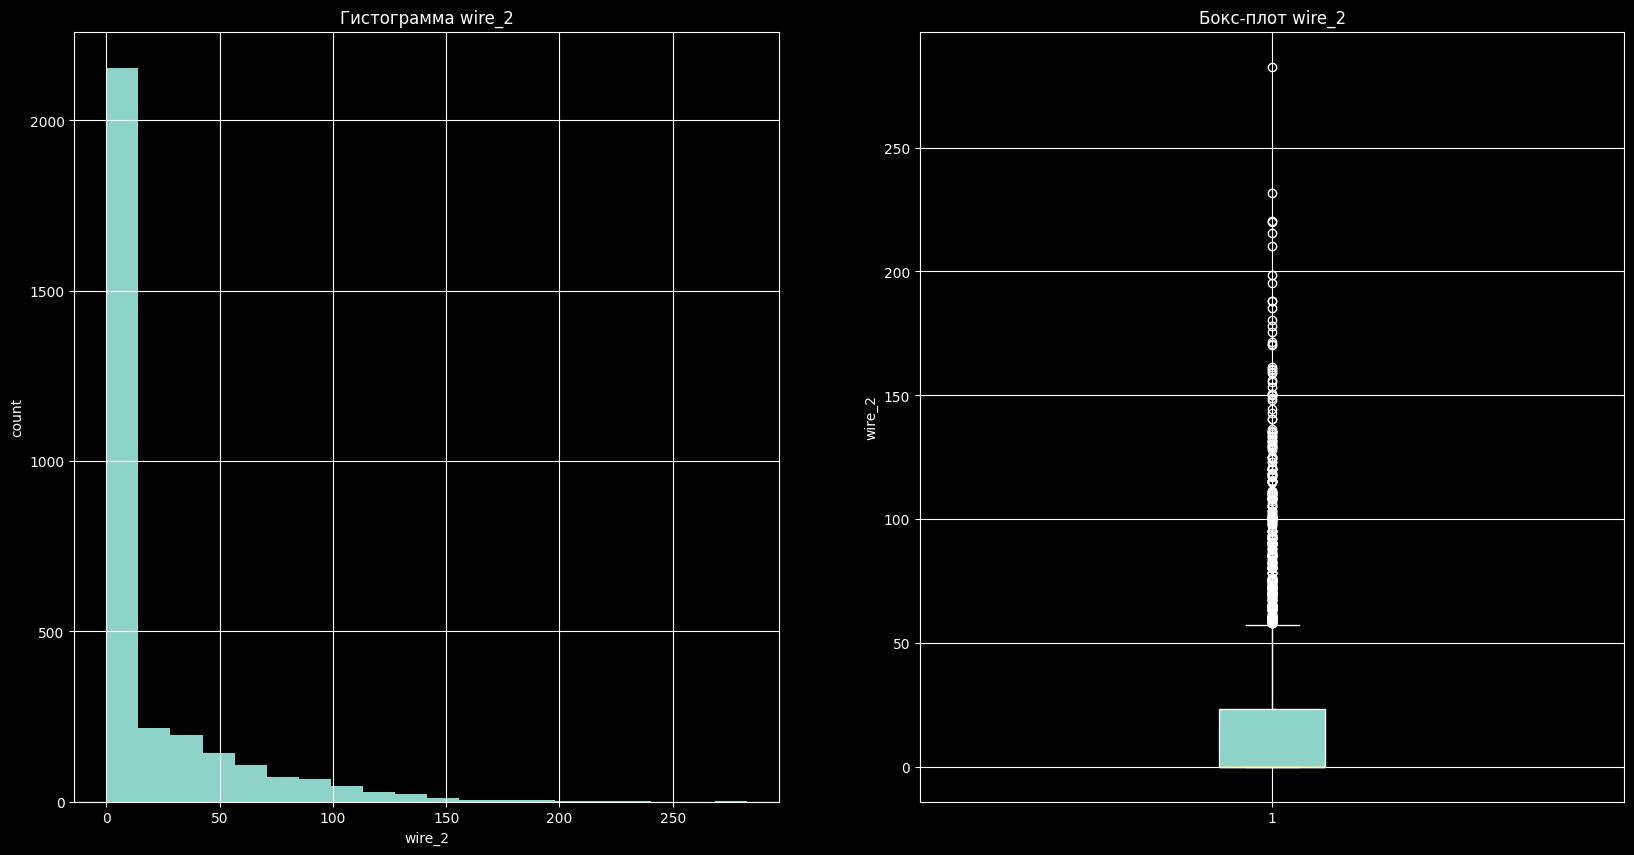


wire_3
count    3081.000000
mean        3.874524
std        30.310417
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       385.008668
Name: wire_3, dtype: float64


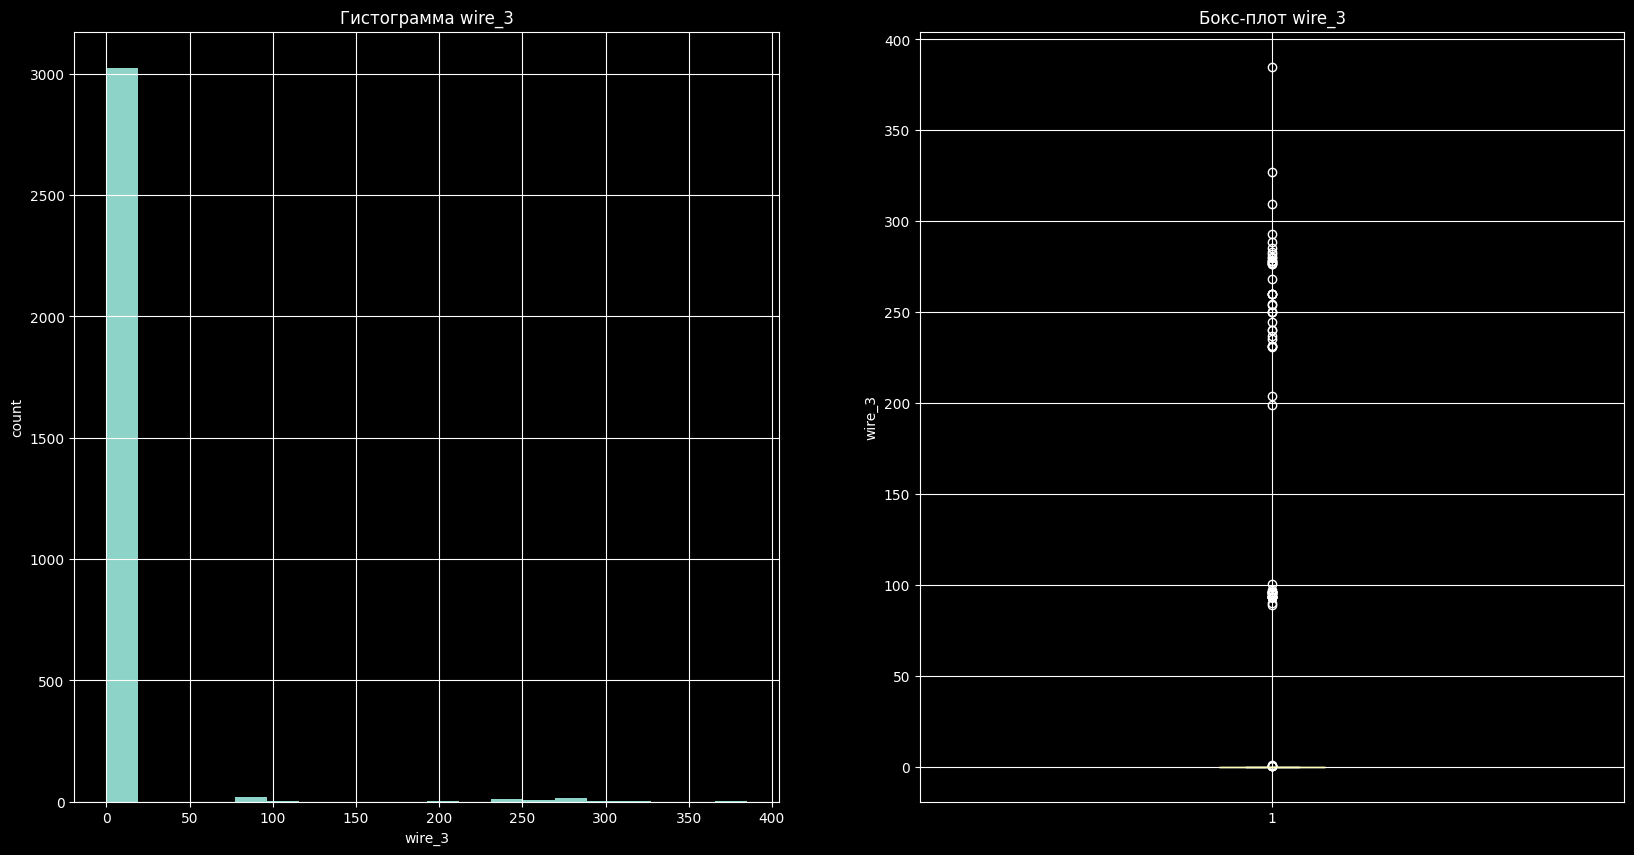


wire_4
count    3081.000000
mean        0.261019
std         4.293865
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       113.231044
Name: wire_4, dtype: float64


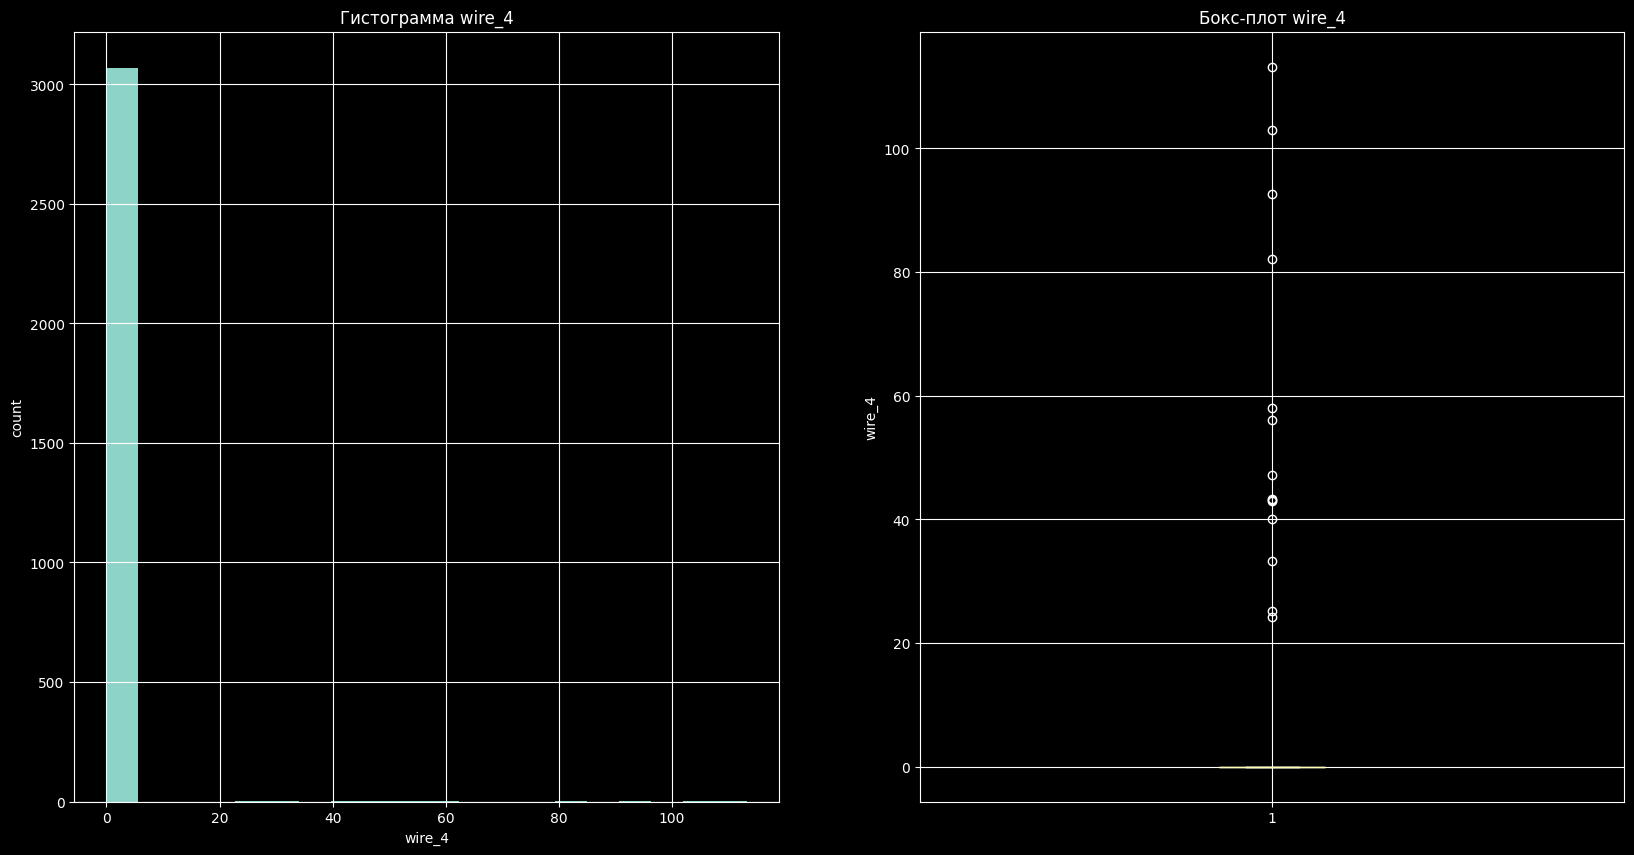


wire_5
count    3081.000000
mean        0.004911
std         0.272615
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        15.132000
Name: wire_5, dtype: float64


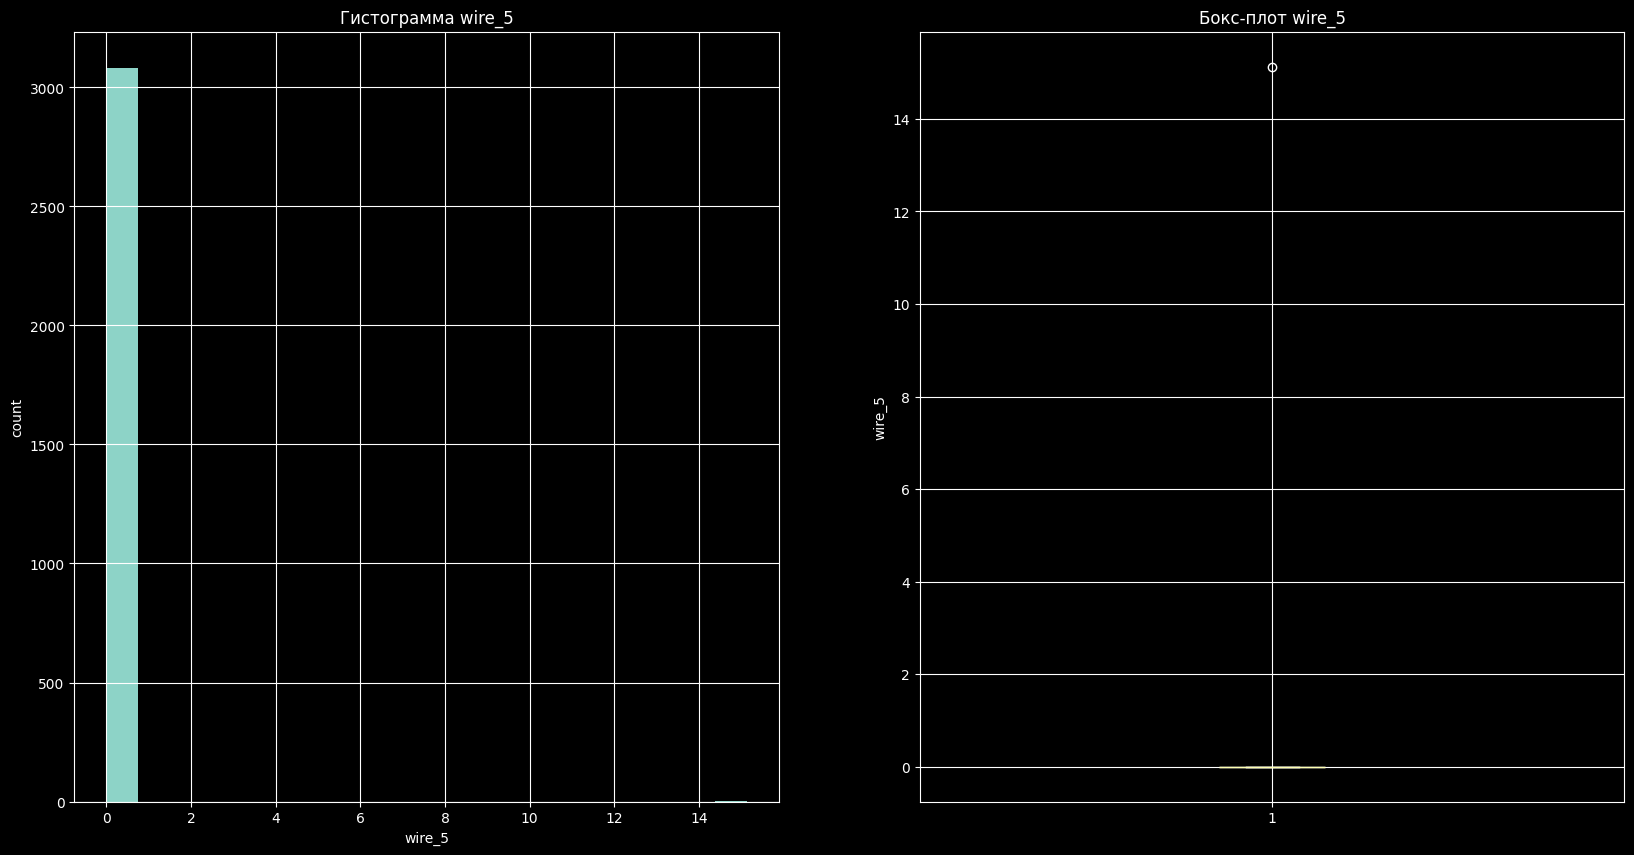


wire_6
count    3081.000000
mean        1.137695
std         8.958111
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       180.454575
Name: wire_6, dtype: float64


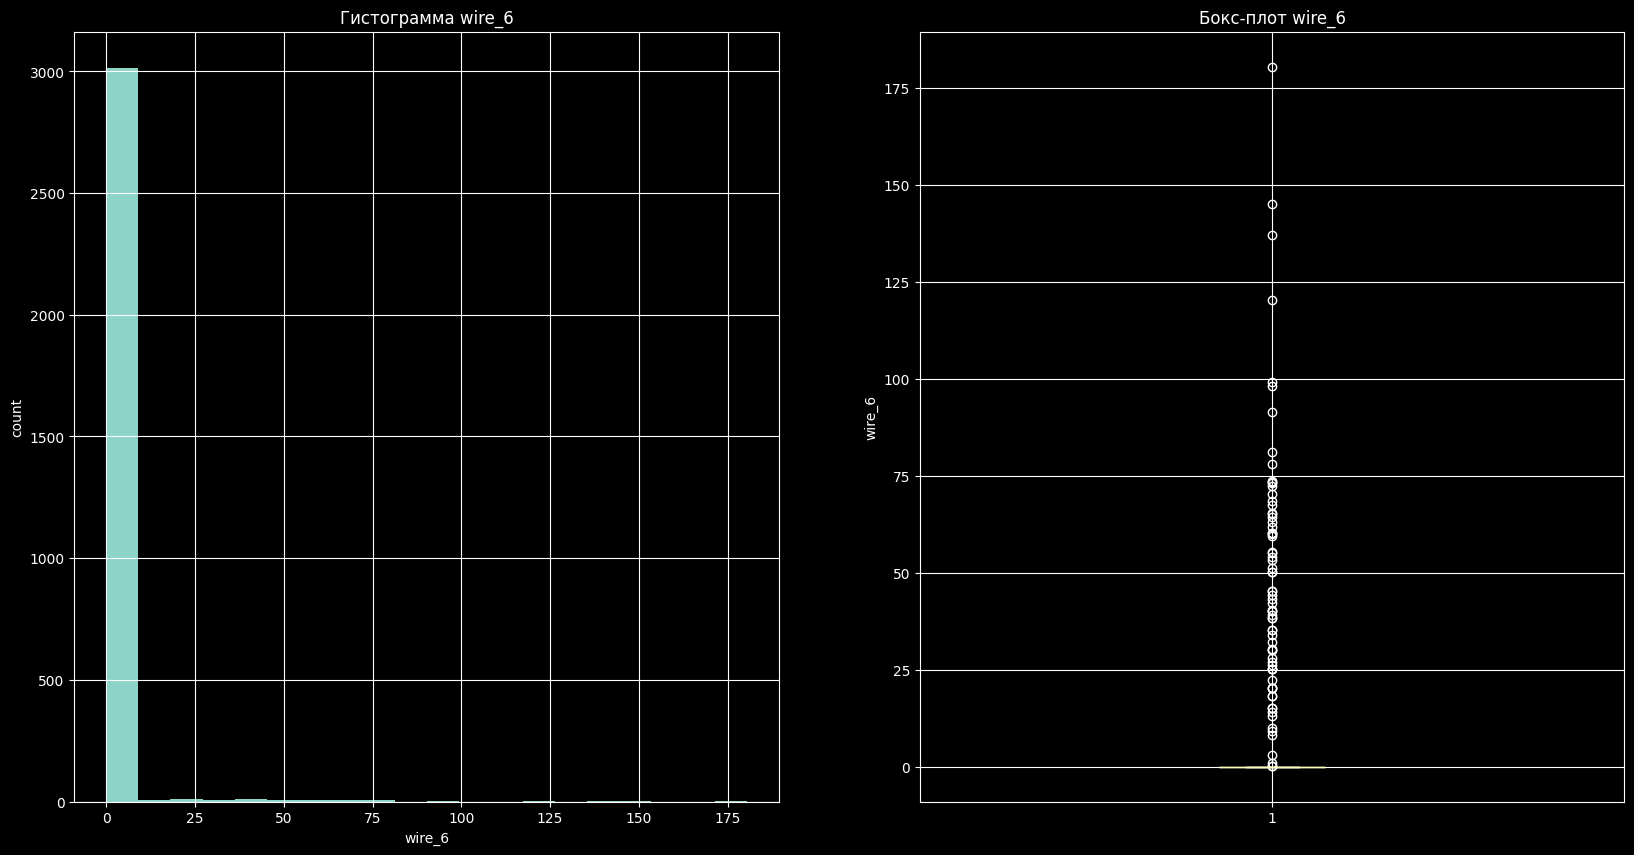


wire_7
count    3081.000000
mean        0.035842
std         0.774190
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        32.847674
Name: wire_7, dtype: float64


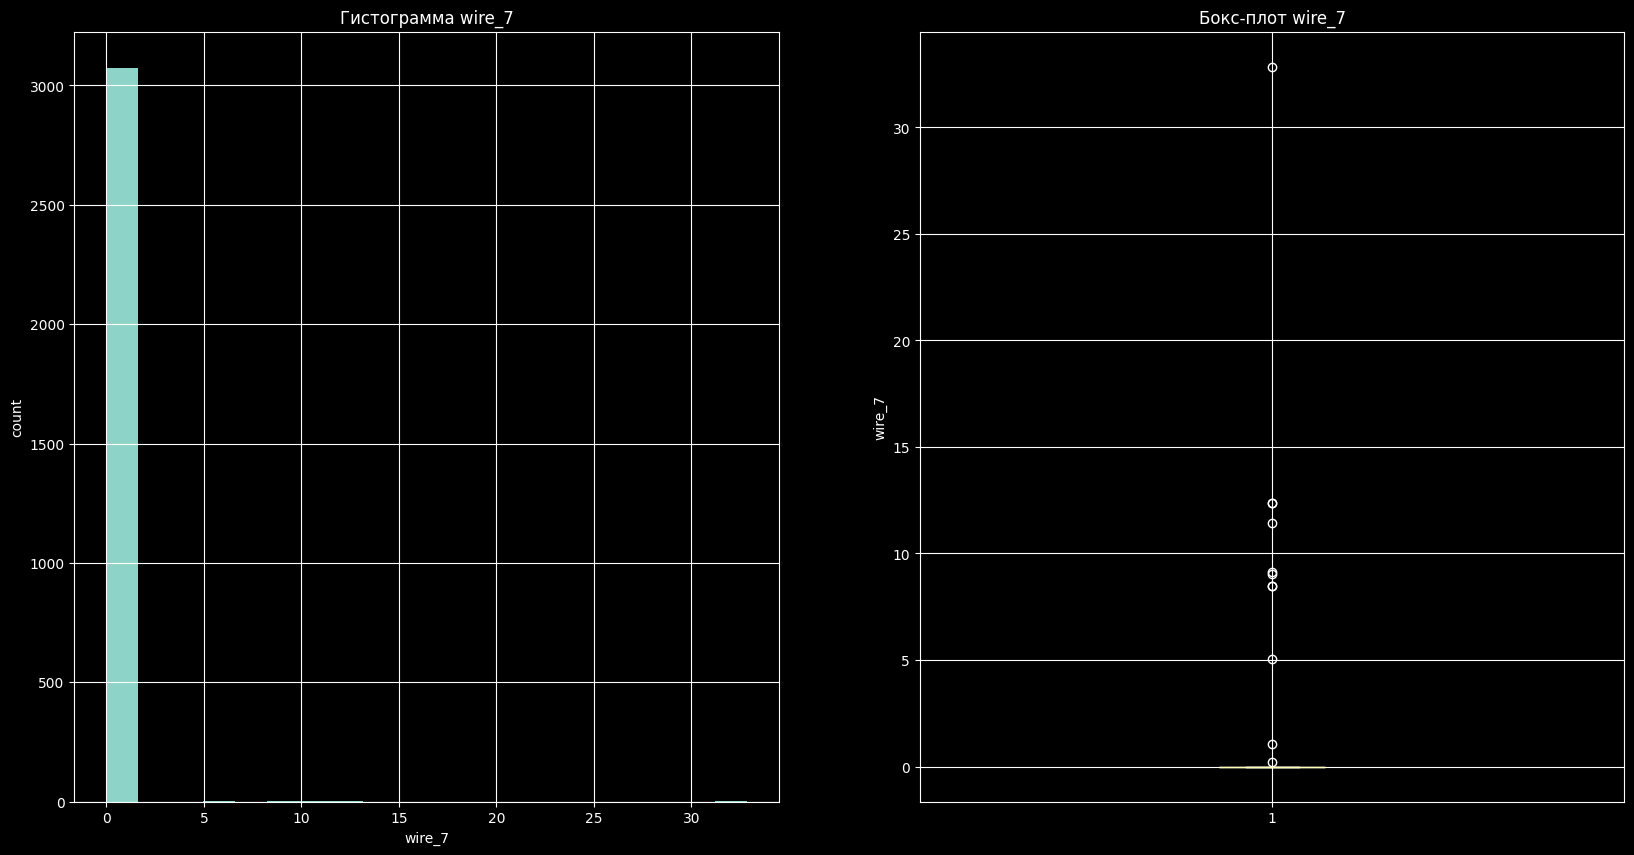


wire_8
count    3081.000000
mean        0.330697
std         4.392677
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       102.762401
Name: wire_8, dtype: float64


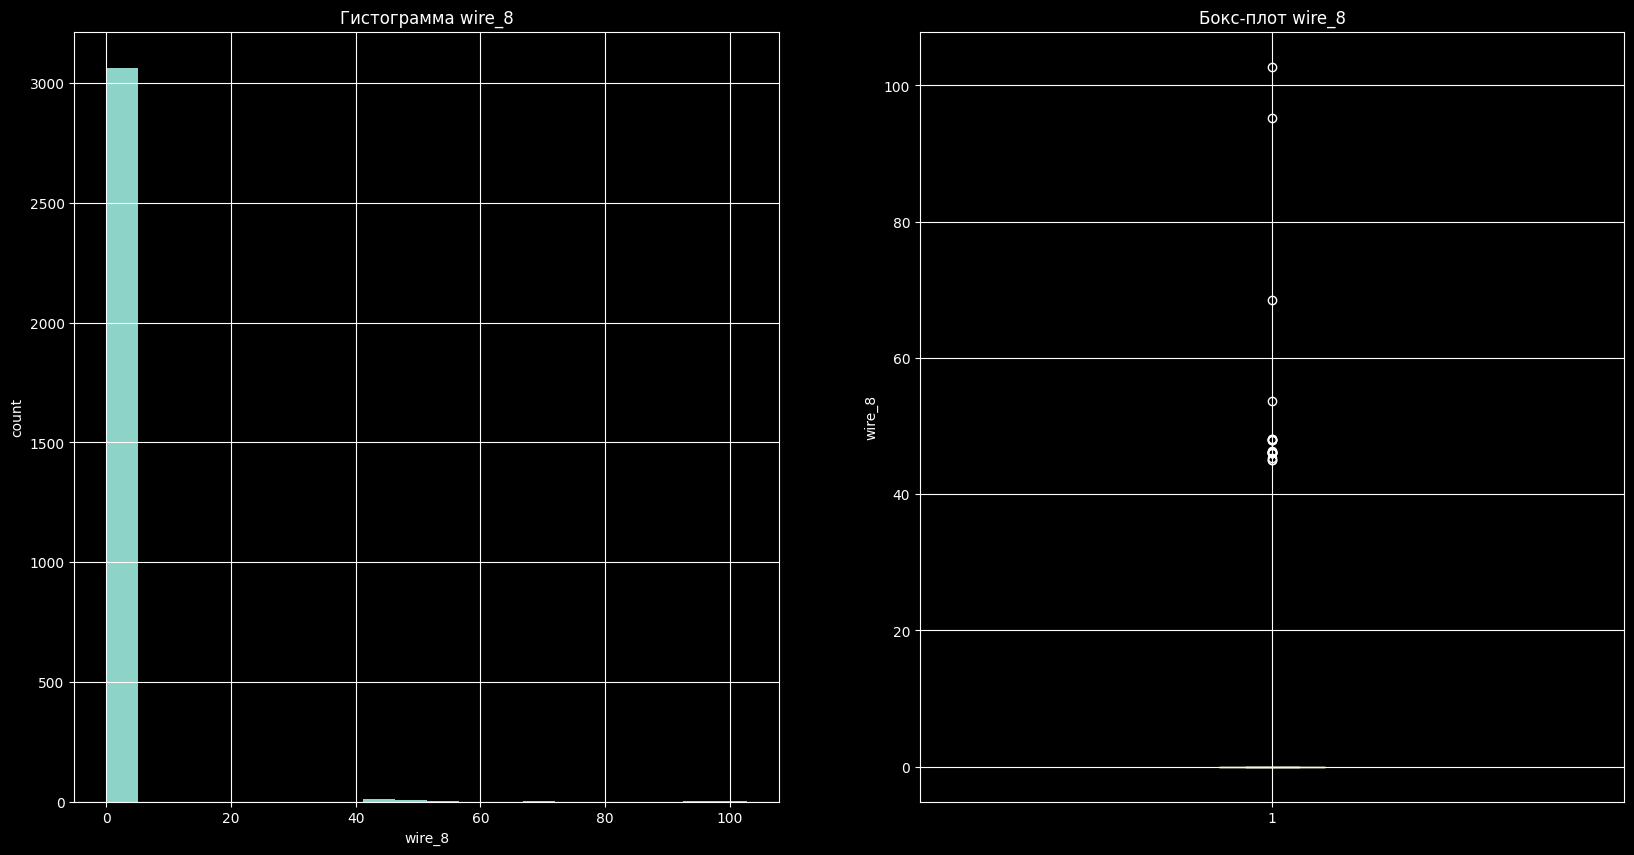


wire_9
count    3081.000000
mean        0.321492
std         3.806904
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        90.053604
Name: wire_9, dtype: float64


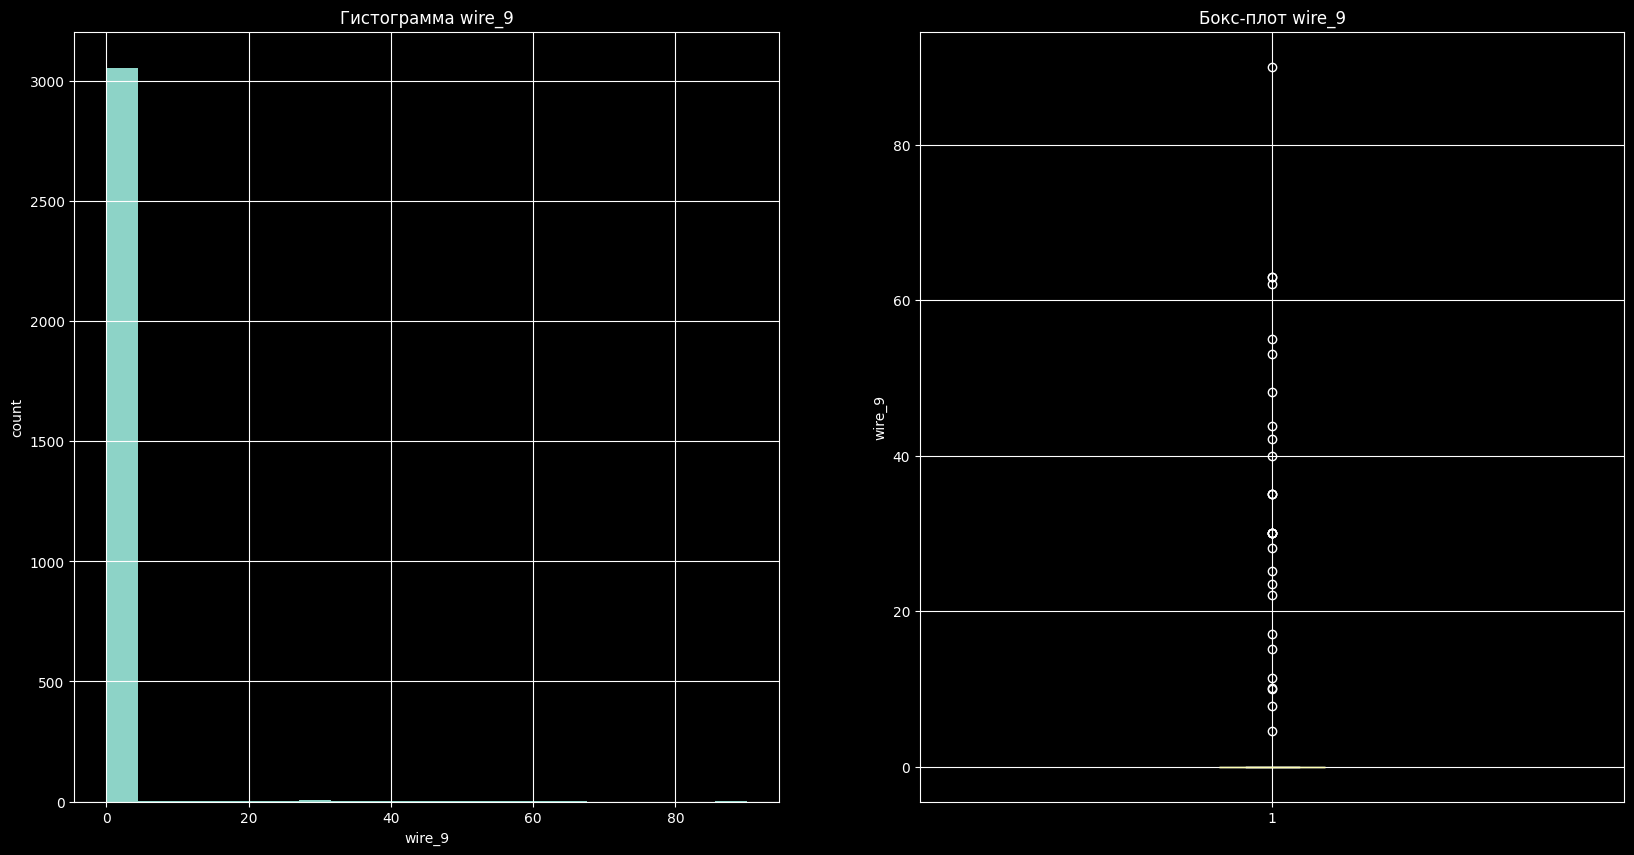

In [ ]:
for colum in df['data_wire'].columns:
    if colum != 'key':
        print(colum)
        print(df['data_wire'][colum].describe())
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

        ax[0].hist(df['data_wire'][colum], bins=20)
        ax[0].set_title('Гистограмма ' + colum)
        ax[0].set_xlabel(colum)
        ax[0].set_ylabel('count')
        ax[0].grid(True)

        ax[1].boxplot(df['data_wire'][colum], patch_artist=True)
        ax[1].set_ylabel(colum)
        ax[1].set_title('Бокс-плот ' + colum)
        ax[1].grid(True)
        plt.show()
        print()

В большинстве колонок wire наблюдаем сильно смещенную гистограмму к левому краю из за большого наличия 0-ых значений, максимальные значения ~200.

Везде наблюдаем аномальные значения по правому краю распределения кроме wire_1 (выглядит как нормальное распределение)

### Объединение таблиц

In [ ]:
df['data_arc'].head()

key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   реактивная_мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

Синтезируем новые признаки: длительность нагрева, общую мощность, соотношение активной мощности к реактивной

In [ ]:
df['data_arc']['длительность_нагрева'] = (df['data_arc']['конец_нагрева_дугой'] - df['data_arc']['начало_нагрева_дугой']).apply(lambda x: x.total_seconds())
df['data_arc']['полная_мощность'] = np.sqrt(df['data_arc']['активная_мощность']**2 + df['data_arc']['реактивная_мощность']**2)
df['data_arc']['акт/реакт_мощность'] = df['data_arc']['активная_мощность'] / df['data_arc']['реактивная_мощность']
df['data_arc'].head()

key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   реактивная_мощность  длительность_нагрева  полная_мощность  \
0             0.211253                 228.0         0.371123   
1             0.477438                 185.0         0.902319   
2             0.430460                 172.0         0.722536   
3             0.379979                 365.0         0.642824   
4             0.643691                 148.0         1.079934   

   акт/реакт_мощность  
0            1.444382  
1            1.603680  
2            1.348123  
3            1.364539  
4            1.347126

при агрегировании добавим: количество запусков

In [ ]:
agg_func_ = {
    'активная_мощность': ['count', 'sum'],
    'реактивная_мощность': 'sum',
    'длительность_нагрева': 'sum',
    'полная_мощность': 'sum',
    'акт/реакт_мощность': 'sum'
}

In [ ]:
df_arc = df['data_arc'][[col for col in df['data_arc'].columns if col not in ['начало_нагрева_дугой', 'конец_нагрева_дугой']]].groupby('key').agg(agg_func_)
df_arc.columns = ['_'.join(col).strip() for col in df_arc.columns.values]
df_arc.rename(columns={'активная_мощность_count': 'количество_запуска_нагрева_электродами'}, inplace=True)
df_arc.head()

количество_запуска_нагрева_электродами  активная_мощность_sum  \
key                                                                  
1                                         5               3.036730   
2                                         4               2.139408   
3                                         5               4.063641   
4                                         4               2.706489   
5                                         4               2.252950   

     реактивная_мощность_sum  длительность_нагрева_sum  полная_мощность_sum  \
key                                                                           
1                   2.142821                    1098.0             3.718736   
2                   1.453357                     811.0             2.588349   
3                   2.937457                     655.0             5.019223   
4                   2.056992                     741.0             3.400038   
5                   1.687991                     869.0             2.816980   

     акт/реакт_мощность_sum  
key                          
1                  7.107850  
2                  5.916805  
3                  6.980344  
4                  5.229785  
5                  5.315577

In [ ]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3214 entries, 1 to 3241
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   количество_запуска_нагрева_электродами  3214 non-null   int64  
 1   активная_мощность_sum                   3214 non-null   float64
 2   реактивная_мощность_sum                 3214 non-null   float64
 3   длительность_нагрева_sum                3214 non-null   float64
 4   полная_мощность_sum                     3214 non-null   float64
 5   акт/реакт_мощность_sum                  3214 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 175.8 KB


In [ ]:
# f = 0
# break_id = []
# for _ in range(len(df_arc)):
#     f += 1
#     if f != df_arc.index[_]:
#         print(df_arc.index[_])
#         f = df_arc.index[_]
#         break_id.append(_)

In [ ]:
df_arc = df_arc.reset_index()
df_arc.head()

key  количество_запуска_нагрева_электродами  активная_мощность_sum  \
0    1                                       5               3.036730   
1    2                                       4               2.139408   
2    3                                       5               4.063641   
3    4                                       4               2.706489   
4    5                                       4               2.252950   

   реактивная_мощность_sum  длительность_нагрева_sum  полная_мощность_sum  \
0                 2.142821                    1098.0             3.718736   
1                 1.453357                     811.0             2.588349   
2                 2.937457                     655.0             5.019223   
3                 2.056992                     741.0             3.400038   
4                 1.687991                     869.0             2.816980   

   акт/реакт_мощность_sum  
0                7.107850  
1                5.916805  
2                6.980344  
3                5.229785  
4                5.315577

Собираем проволочные, сыпучие материалы, данные по газу:

In [ ]:
df_sub = df_arc.merge(df['data_bulk'],on='key', how='left').merge(
    df['data_wire'],on='key', how='left').merge(df['data_gas'],on='key', how='left')
df_sub.head()

key  количество_запуска_нагрева_электродами  активная_мощность_sum  \
0    1                                       5               3.036730   
1    2                                       4               2.139408   
2    3                                       5               4.063641   
3    4                                       4               2.706489   
4    5                                       4               2.252950   

   реактивная_мощность_sum  длительность_нагрева_sum  полная_мощность_sum  \
0                 2.142821                    1098.0             3.718736   
1                 1.453357                     811.0             2.588349   
2                 2.937457                     655.0             5.019223   
3                 2.056992                     741.0             3.400038   
4                 1.687991                     869.0             2.816980   

   акт/реакт_мощность_sum  bulk_1  bulk_2  bulk_3  ...     wire_1   wire_2  \
0                7.107850     0.0     0.0     0.0  ...  60.059998  0.00000   
1                5.916805     0.0     0.0     0.0  ...  96.052315  0.00000   
2                6.980344     0.0     0.0     0.0  ...  91.160157  0.00000   
3                5.229785     0.0     0.0     0.0  ...  89.063515  0.00000   
4                5.315577     0.0     0.0     0.0  ...  89.238236  9.11456   

   wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  wire_9      газ_1  
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  29.749986  
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0  12.555561  
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0  28.554793  
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0  18.841219  
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0   5.413692  

[5 rows x 32 columns]

Выделяем из таблицы с температурой: начальную температуру, последнюю температуру, количество замеров



In [ ]:
df_temp = df['data_temp'].groupby('key').apply(lambda x: pd.Series({
    'начальная_температура': x.loc[x['время_замера'].idxmin()]['температура'],
    'последняя_температура': x.loc[x['время_замера'].idxmax()]['температура'],
    'количество_замеров': len(x)
}))
df_temp = df_temp.reset_index()
df_temp

key  начальная_температура  последняя_температура  количество_замеров
0        1                 1571.0                 1613.0                 6.0
1        2                 1581.0                 1602.0                 5.0
2        3                 1596.0                 1599.0                 6.0
3        4                 1601.0                 1625.0                 5.0
4        5                 1576.0                 1602.0                 5.0
...    ...                    ...                    ...                 ...
3210  3237                 1569.0                 1569.0                 1.0
3211  3238                 1584.0                 1584.0                 1.0
3212  3239                 1598.0                 1598.0                 1.0
3213  3240                 1617.0                 1617.0                 1.0
3214  3241                 1586.0                 1586.0                 1.0

[3215 rows x 4 columns]

In [ ]:
len(df_temp[df_temp['количество_замеров'] == 1])

740

Значения с одним замером удаляем ибо он будет считатся как начальной так и последней температурой, что не будет иметь смысла

In [ ]:
df_temp = df_temp[df_temp['количество_замеров'] > 1][['key', 'начальная_температура', 'последняя_температура']]
df_temp

key  начальная_температура  последняя_температура
0        1                 1571.0                 1613.0
1        2                 1581.0                 1602.0
2        3                 1596.0                 1599.0
3        4                 1601.0                 1625.0
4        5                 1576.0                 1602.0
...    ...                    ...                    ...
2472  2495                 1570.0                 1591.0
2473  2496                 1554.0                 1591.0
2474  2497                 1571.0                 1589.0
2475  2498                 1591.0                 1594.0
2476  2499                 1569.0                 1603.0

[2475 rows x 3 columns]

Собираем итоговую таблицу:

In [ ]:
df_full = df_temp.merge(df_sub,on='key', how='left')
df_full.head()

key  начальная_температура  последняя_температура  \
0    1                 1571.0                 1613.0   
1    2                 1581.0                 1602.0   
2    3                 1596.0                 1599.0   
3    4                 1601.0                 1625.0   
4    5                 1576.0                 1602.0   

   количество_запуска_нагрева_электродами  активная_мощность_sum  \
0                                       5               3.036730   
1                                       4               2.139408   
2                                       5               4.063641   
3                                       4               2.706489   
4                                       4               2.252950   

   реактивная_мощность_sum  длительность_нагрева_sum  полная_мощность_sum  \
0                 2.142821                    1098.0             3.718736   
1                 1.453357                     811.0             2.588349   
2                 2.937457                     655.0             5.019223   
3                 2.056992                     741.0             3.400038   
4                 1.687991                     869.0             2.816980   

   акт/реакт_мощность_sum  bulk_1  ...     wire_1   wire_2  wire_3  wire_4  \
0                7.107850     0.0  ...  60.059998  0.00000     0.0     0.0   
1                5.916805     0.0  ...  96.052315  0.00000     0.0     0.0   
2                6.980344     0.0  ...  91.160157  0.00000     0.0     0.0   
3                5.229785     0.0  ...  89.063515  0.00000     0.0     0.0   
4                5.315577     0.0  ...  89.238236  9.11456     0.0     0.0   

   wire_5  wire_6  wire_7  wire_8  wire_9      газ_1  
0     0.0     0.0     0.0     0.0     0.0  29.749986  
1     0.0     0.0     0.0     0.0     0.0  12.555561  
2     0.0     0.0     0.0     0.0     0.0  28.554793  
3     0.0     0.0     0.0     0.0     0.0  18.841219  
4     0.0     0.0     0.0     0.0     0.0   5.413692  

[5 rows x 34 columns]

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   key                                     2475 non-null   int64  
 1   начальная_температура                   2475 non-null   float64
 2   последняя_температура                   2475 non-null   float64
 3   количество_запуска_нагрева_электродами  2475 non-null   int64  
 4   активная_мощность_sum                   2475 non-null   float64
 5   реактивная_мощность_sum                 2475 non-null   float64
 6   длительность_нагрева_sum                2475 non-null   float64
 7   полная_мощность_sum                     2475 non-null   float64
 8   акт/реакт_мощность_sum                  2475 non-null   float64
 9   bulk_1                                  2407 non-null   float64
 10  bulk_2                                  2407 non-null   floa

In [ ]:
df_full.isna().mean()

key                                       0.000000
начальная_температура                     0.000000
последняя_температура                     0.000000
количество_запуска_нагрева_электродами    0.000000
активная_мощность_sum                     0.000000
реактивная_мощность_sum                   0.000000
длительность_нагрева_sum                  0.000000
полная_мощность_sum                       0.000000
акт/реакт_мощность_sum                    0.000000
bulk_1                                    0.027475
bulk_2                                    0.027475
bulk_3                                    0.027475
bulk_4                                    0.027475
bulk_5                                    0.027475
bulk_6                                    0.027475
bulk_7                                    0.027475
bulk_8                                    0.027475
bulk_9                                    0.027475
bulk_10                                   0.027475
bulk_11                                   0.027475
bulk_12                                   0.027475
bulk_13                                   0.027475
bulk_14                                   0.027475
bulk_15                                   0.027475
wire_1                                    0.041616
wire_2                                    0.041616
wire_3                                    0.041616
wire_4                                    0.041616
wire_5                                    0.041616
wire_6                                    0.041616
wire_7                                    0.041616
wire_8                                    0.041616
wire_9                                    0.041616
газ_1                                     0.000808
dtype: float64

От пропусков избавимся:

In [ ]:
df_full = df_full.dropna()
df_full.isna().mean()

key                                       0.0
начальная_температура                     0.0
последняя_температура                     0.0
количество_запуска_нагрева_электродами    0.0
активная_мощность_sum                     0.0
реактивная_мощность_sum                   0.0
длительность_нагрева_sum                  0.0
полная_мощность_sum                       0.0
акт/реакт_мощность_sum                    0.0
bulk_1                                    0.0
bulk_2                                    0.0
bulk_3                                    0.0
bulk_4                                    0.0
bulk_5                                    0.0
bulk_6                                    0.0
bulk_7                                    0.0
bulk_8                                    0.0
bulk_9                                    0.0
bulk_10                                   0.0
bulk_11                                   0.0
bulk_12                                   0.0
bulk_13                                   0.0
bulk_14                                   0.0
bulk_15                                   0.0
wire_1                                    0.0
wire_2                                    0.0
wire_3                                    0.0
wire_4                                    0.0
wire_5                                    0.0
wire_6                                    0.0
wire_7                                    0.0
wire_8                                    0.0
wire_9                                    0.0
газ_1                                     0.0
dtype: float64

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2329 entries, 0 to 2474
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   key                                     2329 non-null   int64  
 1   начальная_температура                   2329 non-null   float64
 2   последняя_температура                   2329 non-null   float64
 3   количество_запуска_нагрева_электродами  2329 non-null   int64  
 4   активная_мощность_sum                   2329 non-null   float64
 5   реактивная_мощность_sum                 2329 non-null   float64
 6   длительность_нагрева_sum                2329 non-null   float64
 7   полная_мощность_sum                     2329 non-null   float64
 8   акт/реакт_мощность_sum                  2329 non-null   float64
 9   bulk_1                                  2329 non-null   float64
 10  bulk_2                                  2329 non-null   float64
 

В сводной таблице: 32 колонки типа float64 и 2 колонки int. 2329 строк

#### EDA итоговой таблицы

начальная_температура
count    2329.000000
mean     1587.386003
std        23.619841
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: начальная_температура, dtype: float64


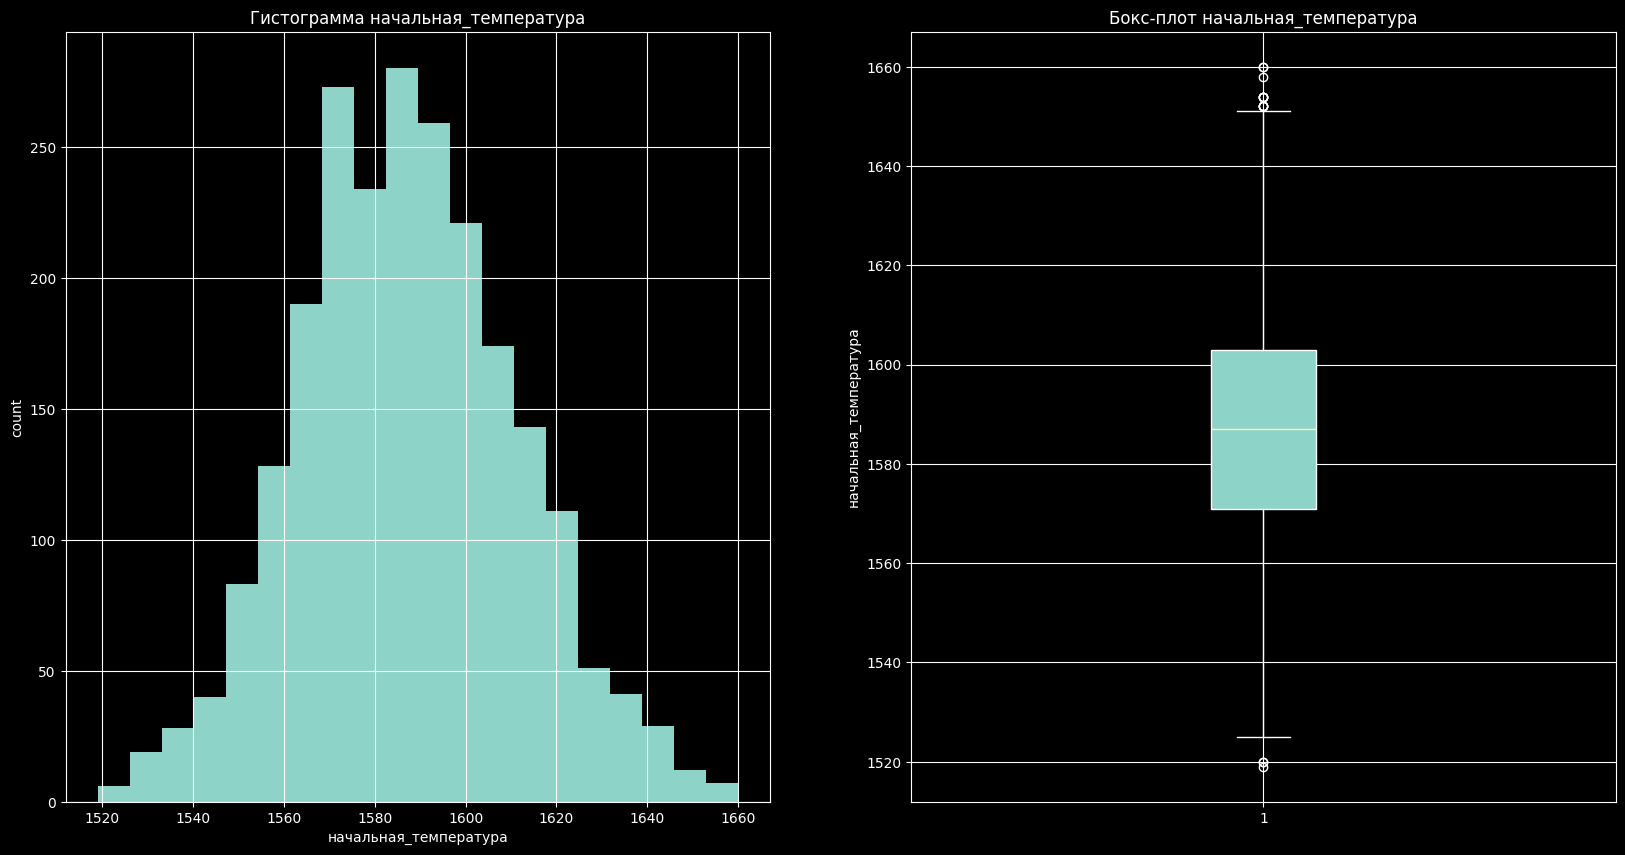


последняя_температура
count    2329.000000
mean     1593.365393
std        11.200915
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: последняя_температура, dtype: float64


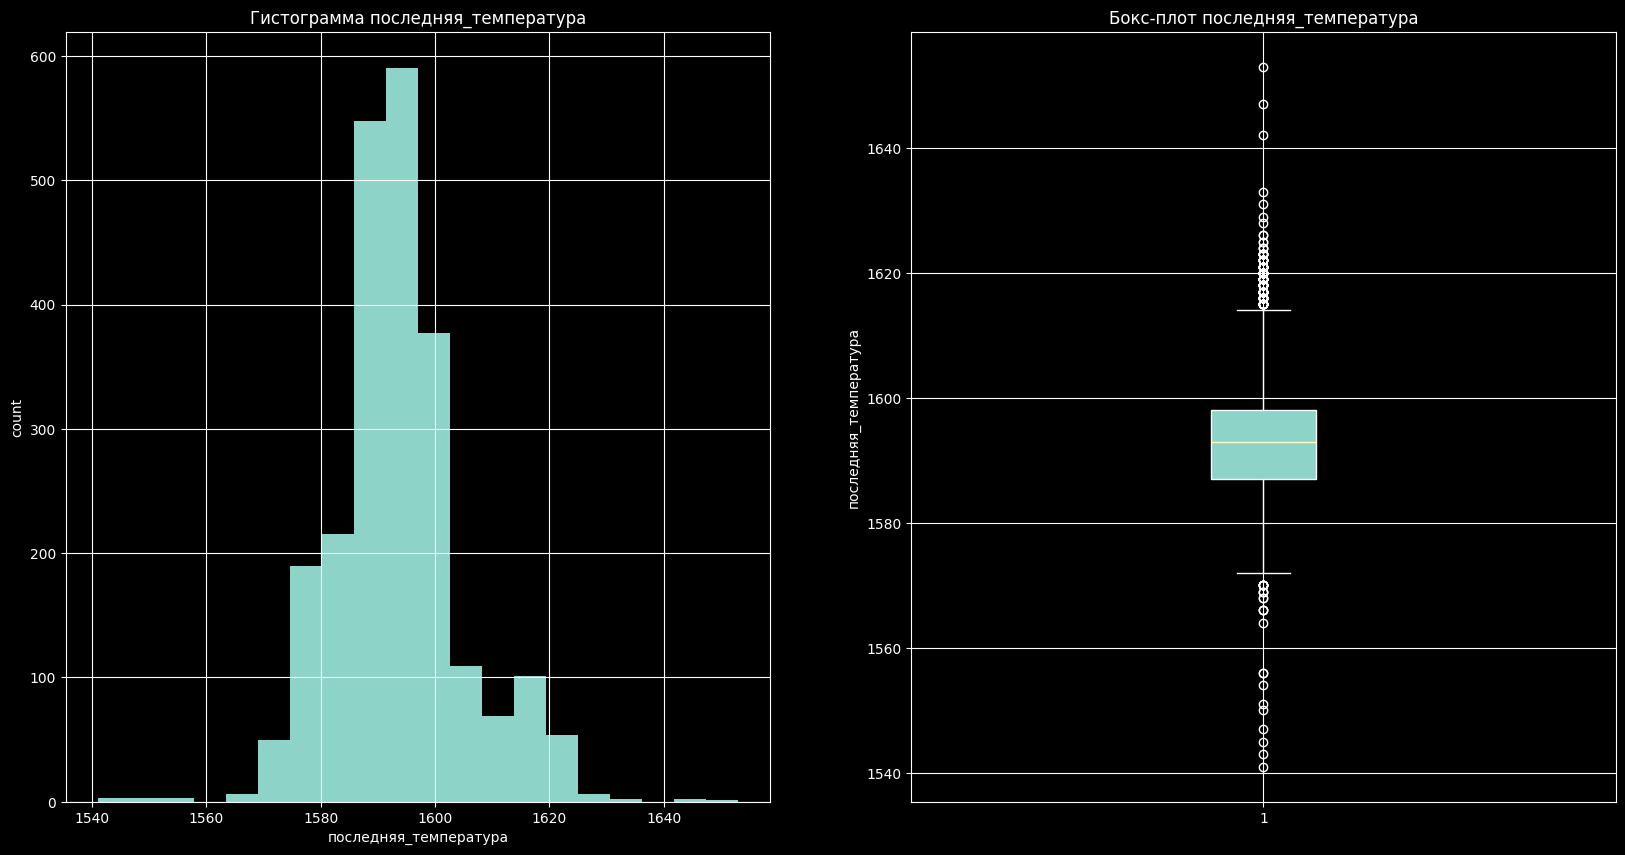


количество_запуска_нагрева_электродами
count    2329.000000
mean        4.695578
std         1.606629
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        16.000000
Name: количество_запуска_нагрева_электродами, dtype: float64


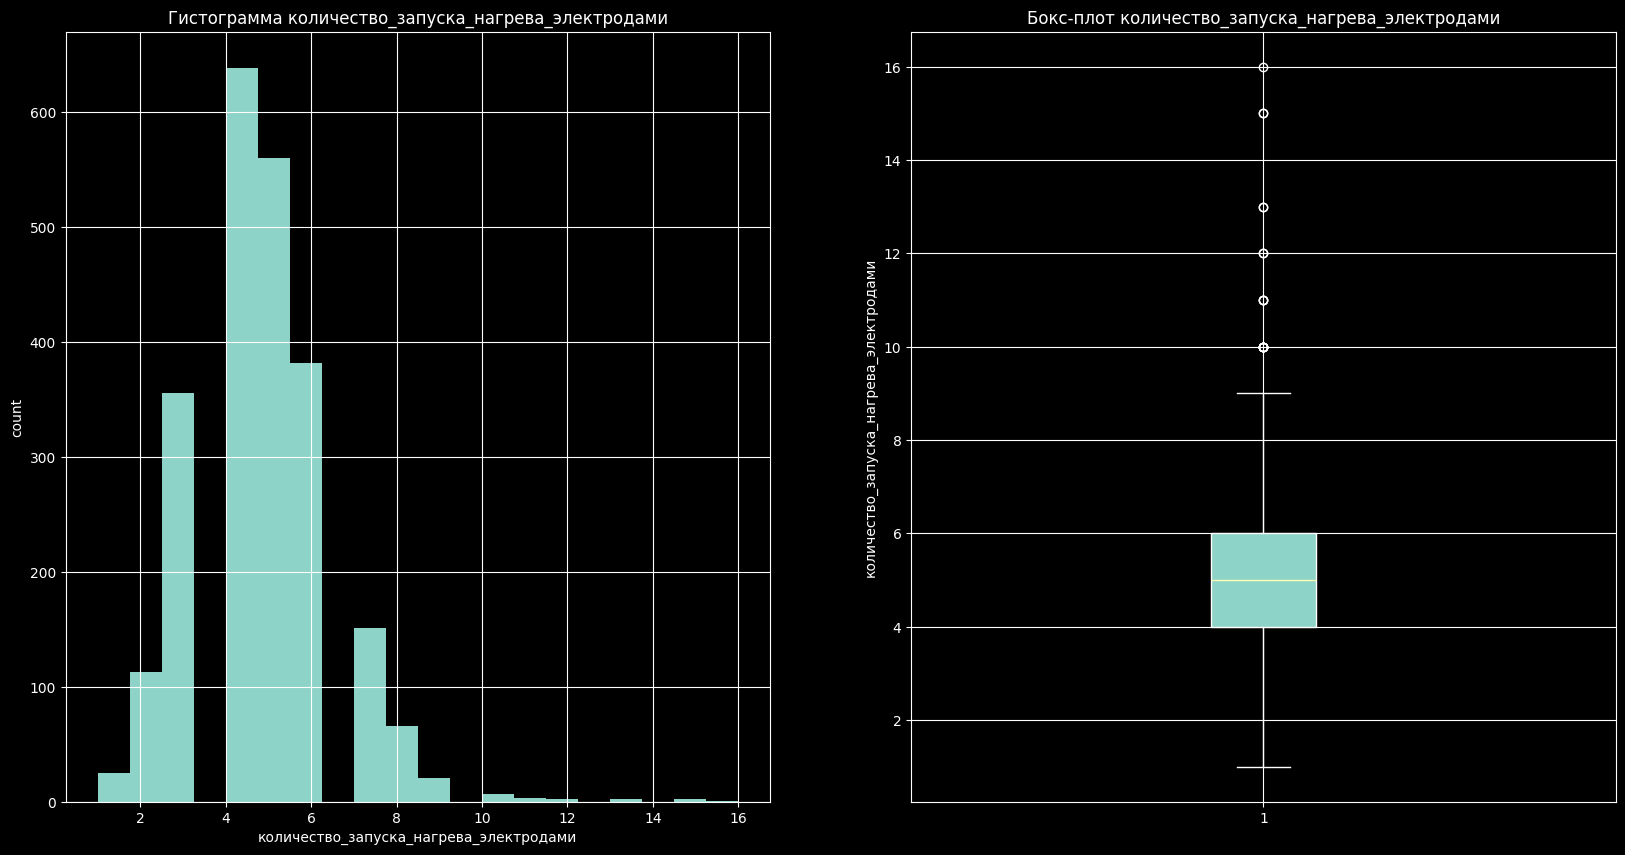


активная_мощность_sum
count    2329.000000
mean        3.125336
std         1.220799
min         0.267676
25%         2.295820
50%         3.035365
75%         3.834300
max        12.375636
Name: активная_мощность_sum, dtype: float64


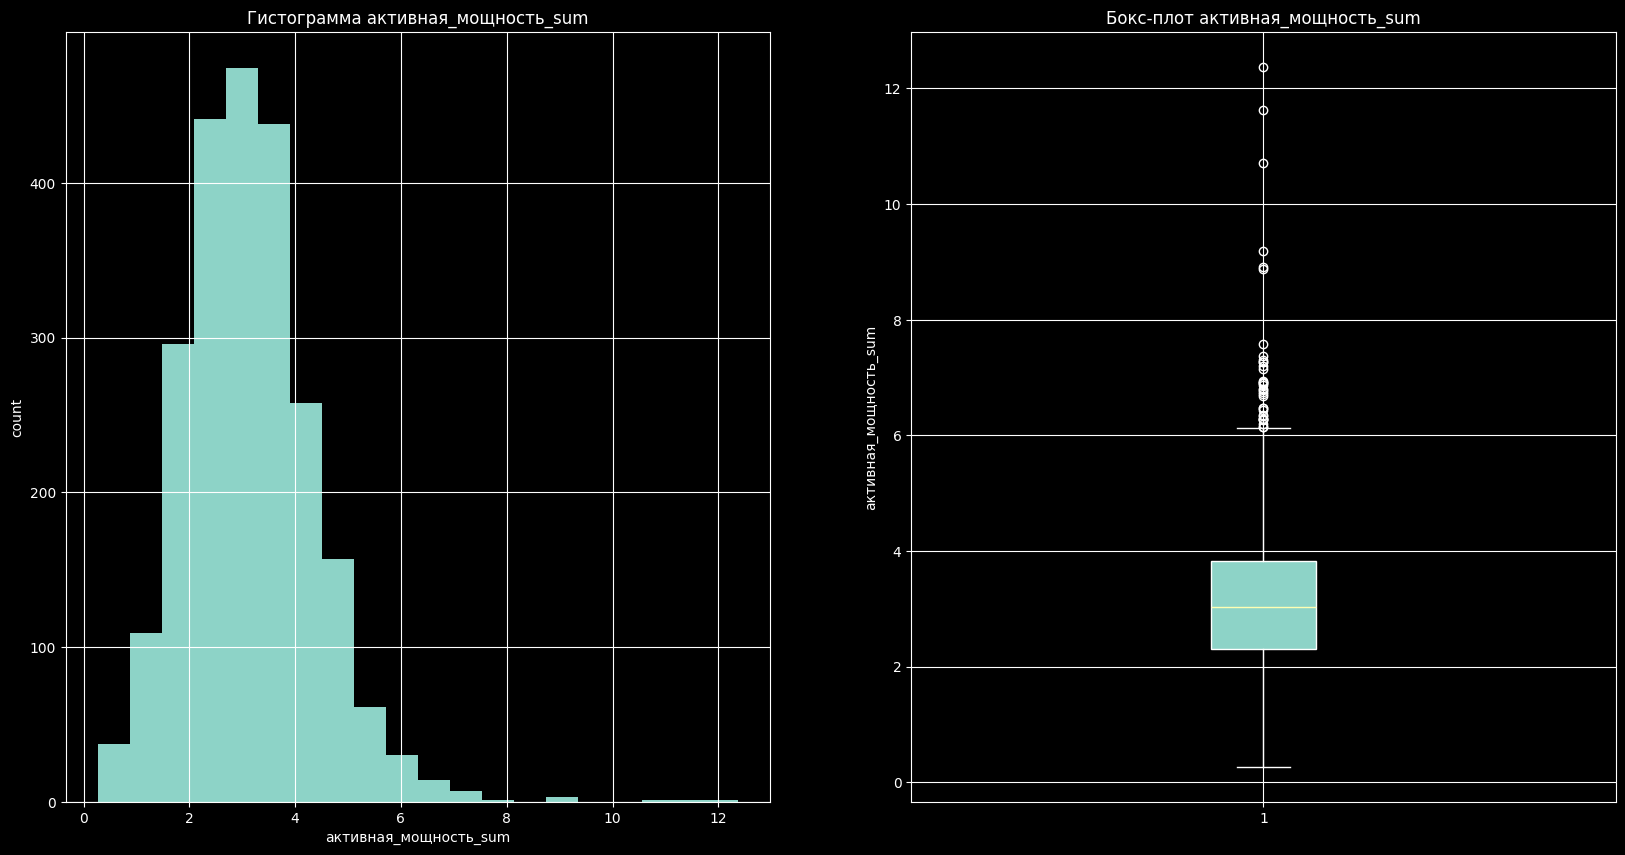


реактивная_мощность_sum
count    2329.000000
mean        2.300745
std         0.903839
min         0.196228
25%         1.670519
50%         2.225398
75%         2.829159
max         8.949049
Name: реактивная_мощность_sum, dtype: float64


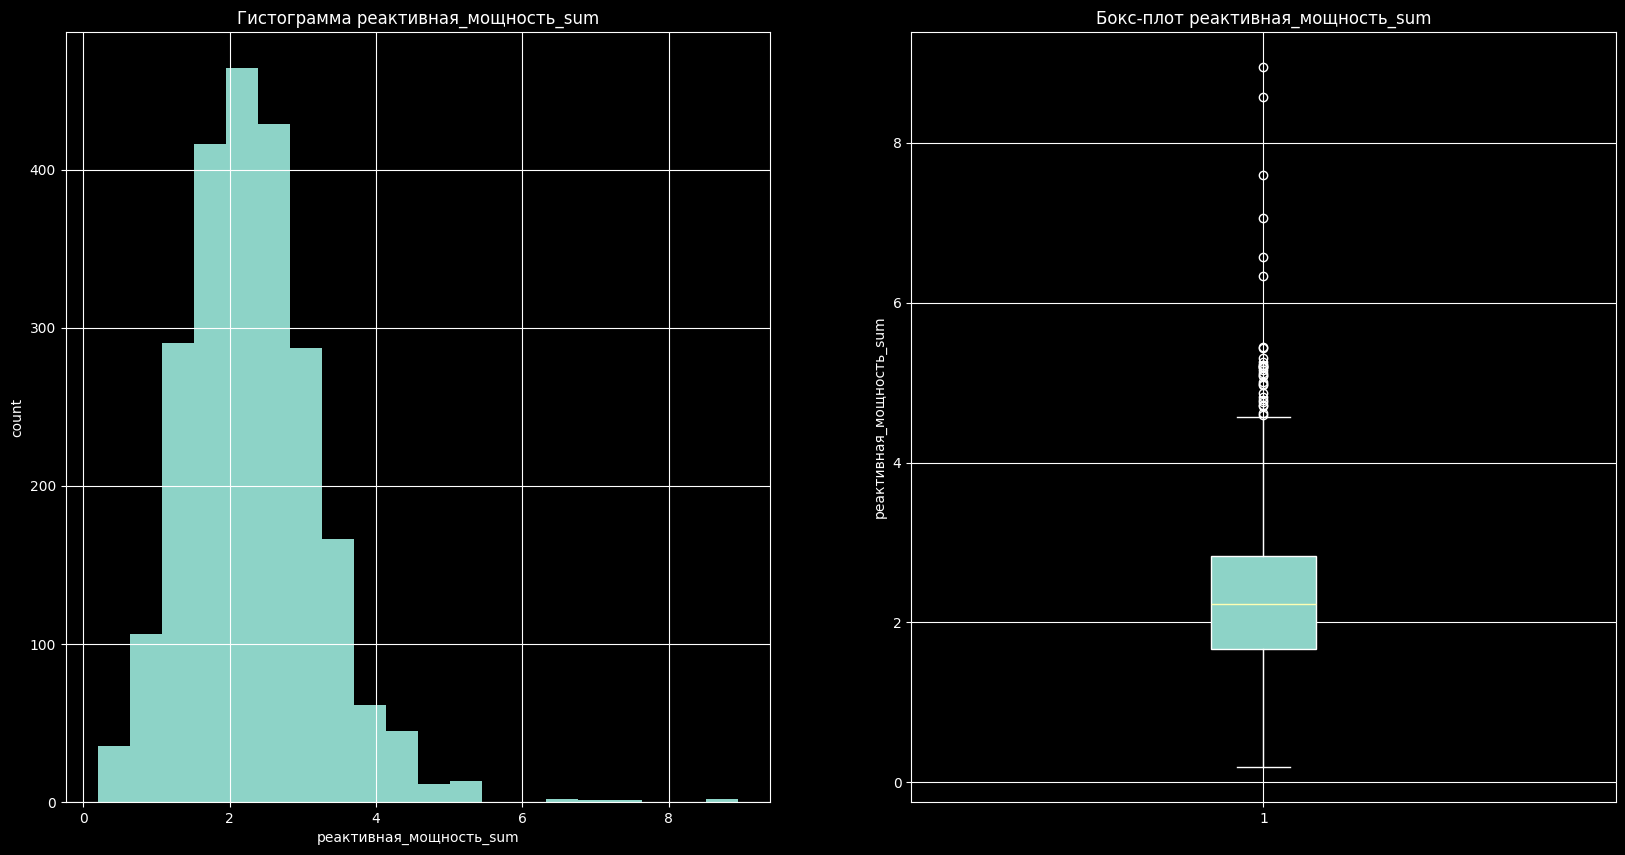


длительность_нагрева_sum
count    2329.000000
mean      807.647488
std       340.838388
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: длительность_нагрева_sum, dtype: float64


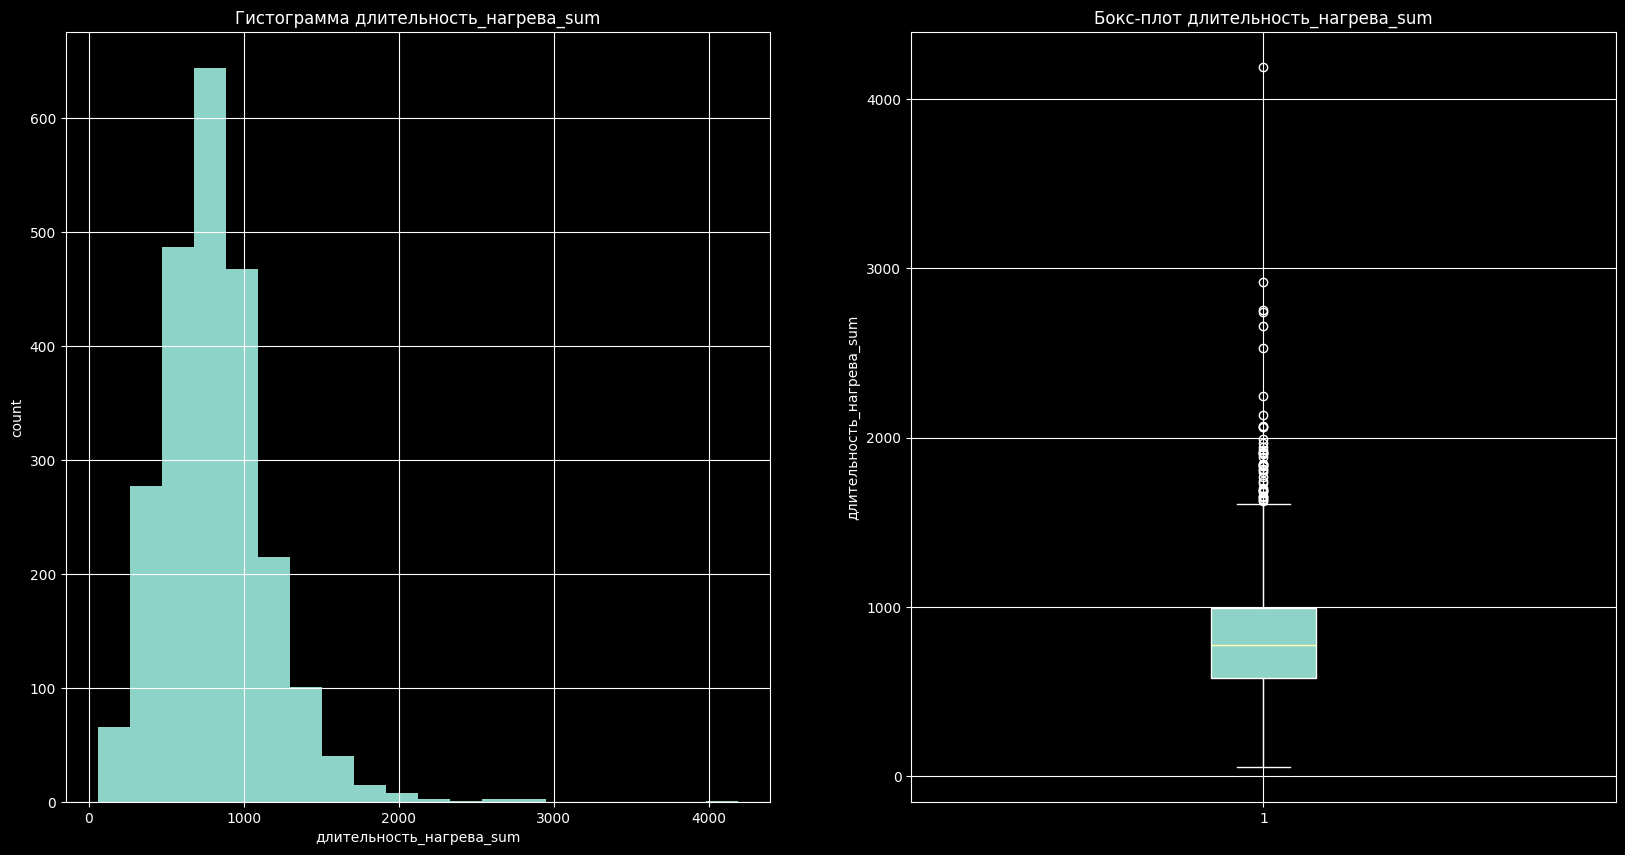


полная_мощность_sum
count    2329.000000
mean        3.885030
std         1.517912
min         0.331897
25%         2.844193
50%         3.767499
75%         4.769421
max        15.288271
Name: полная_мощность_sum, dtype: float64


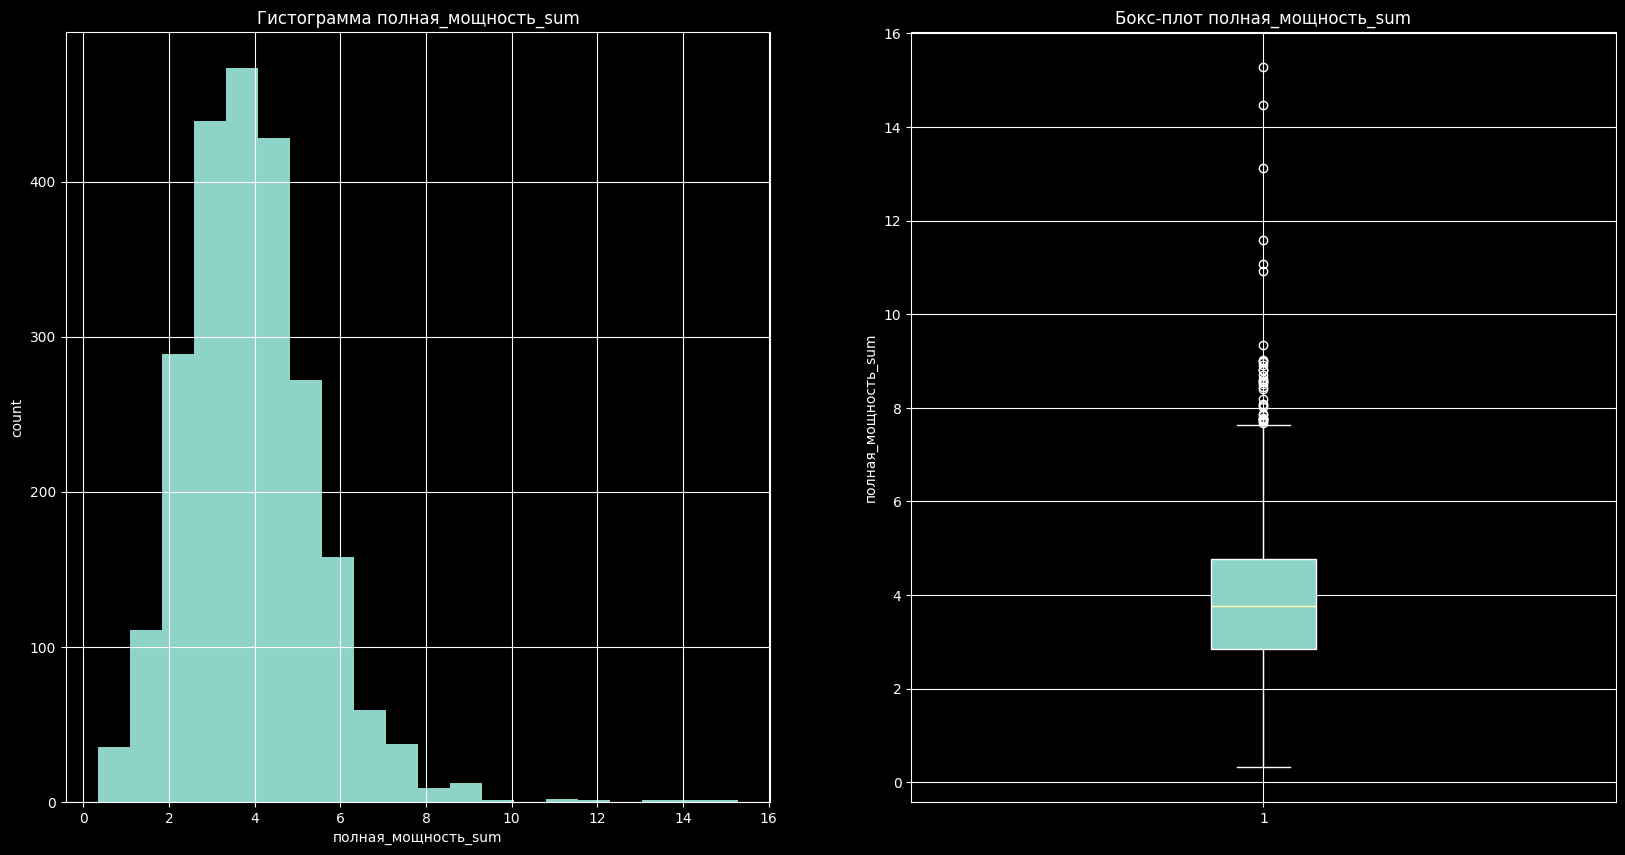


акт/реакт_мощность_sum
count    2329.000000
mean        6.439364
std         2.227453
min         1.112383
25%         5.198727
50%         6.395123
75%         7.861281
max        22.770854
Name: акт/реакт_мощность_sum, dtype: float64


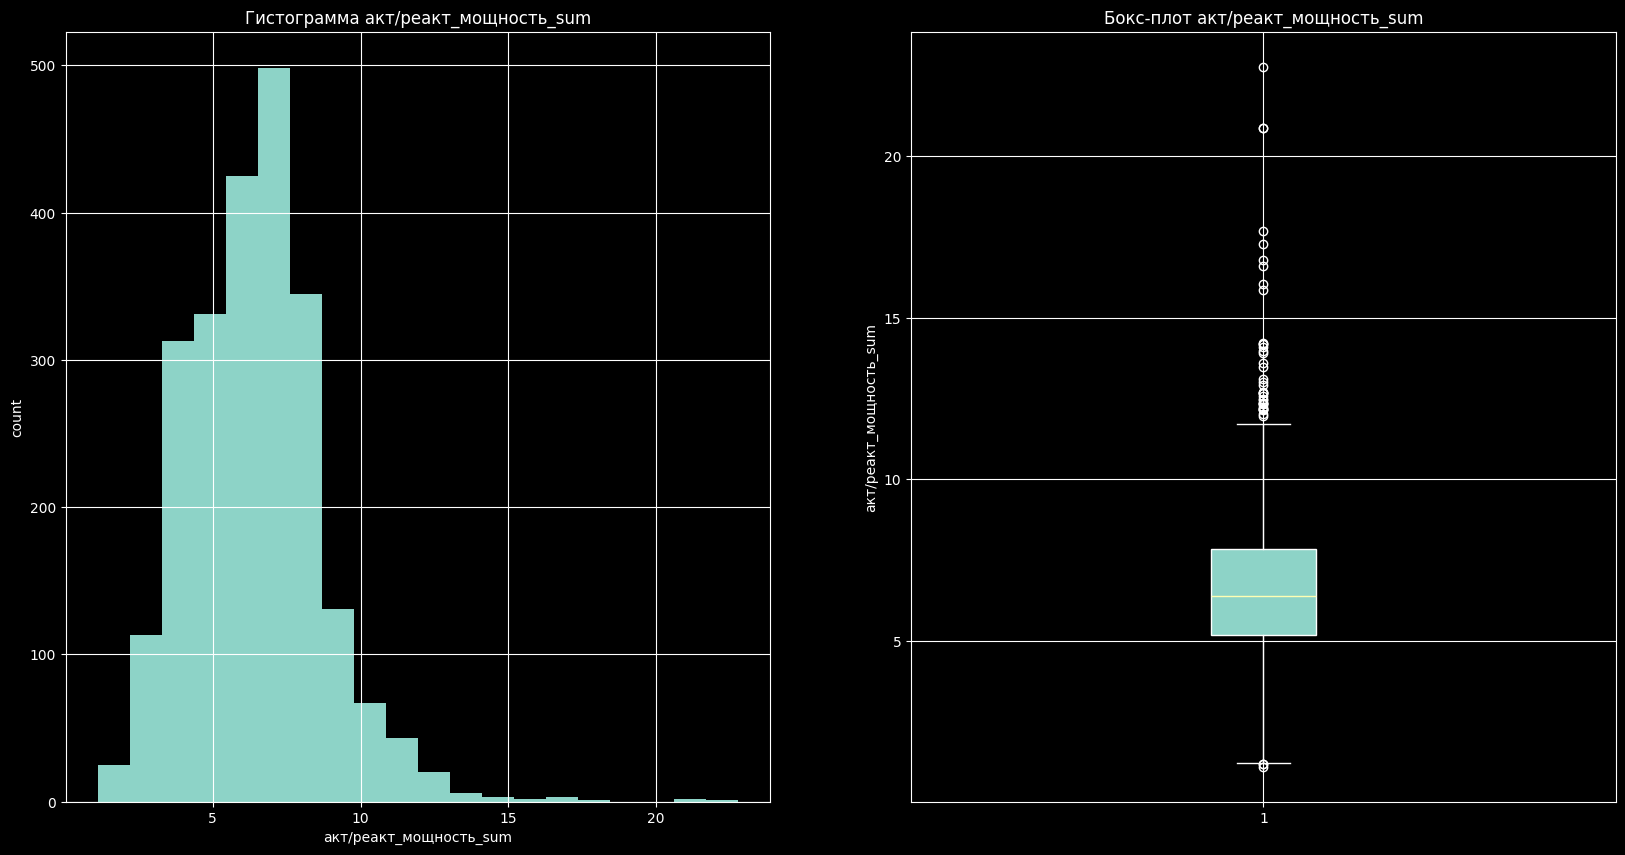


bulk_1
count    2329.000000
mean        3.427651
std        12.412132
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       185.000000
Name: bulk_1, dtype: float64


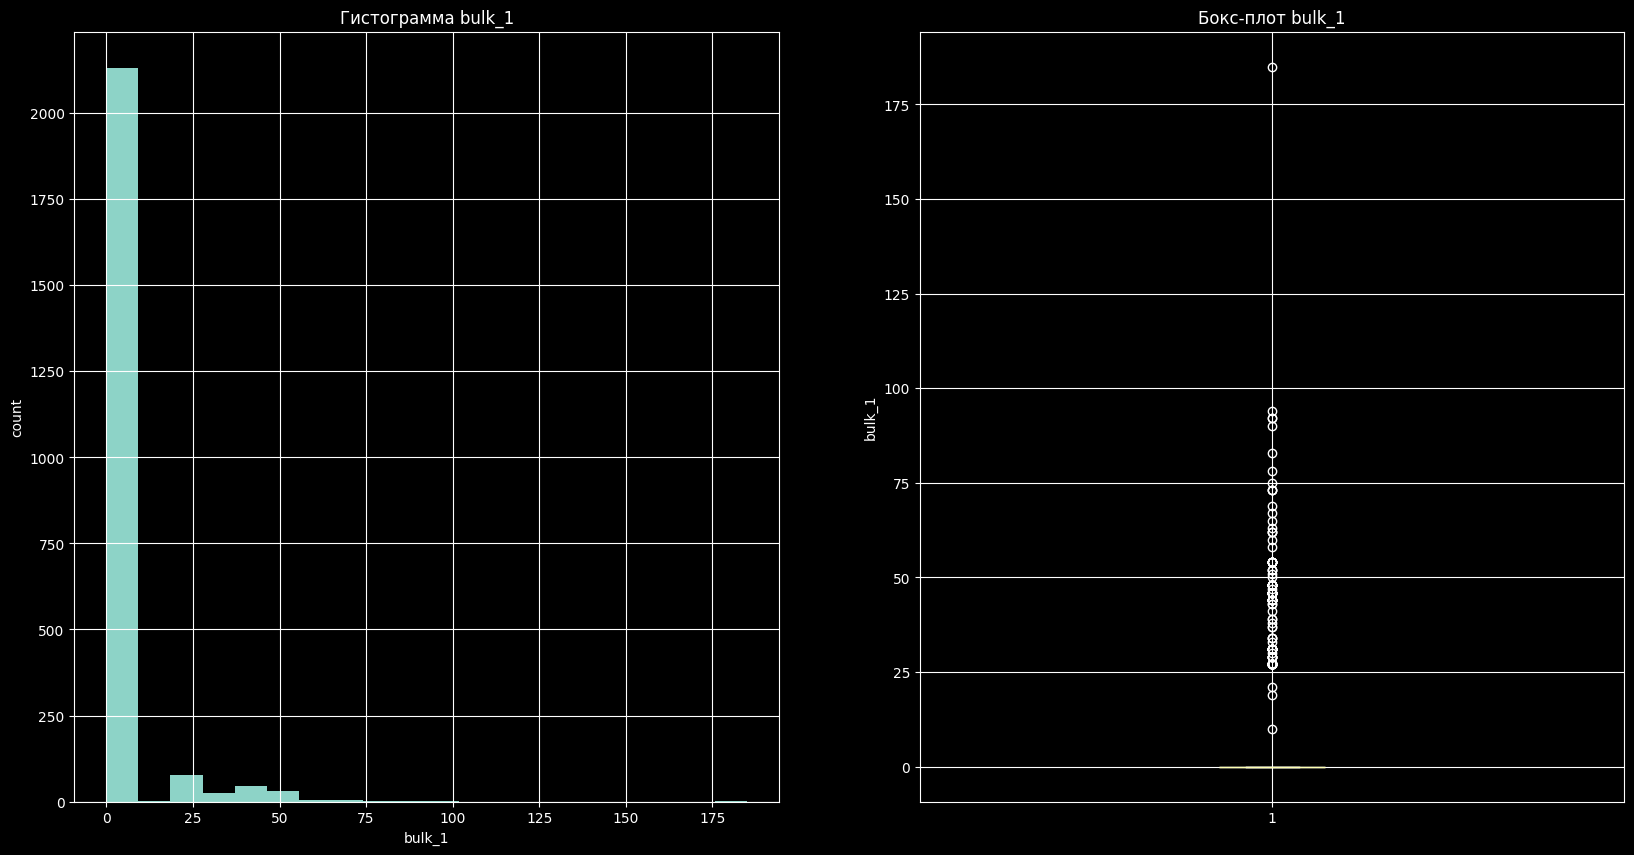


bulk_2
count    2329.000000
mean        1.422499
std        19.082119
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       325.000000
Name: bulk_2, dtype: float64


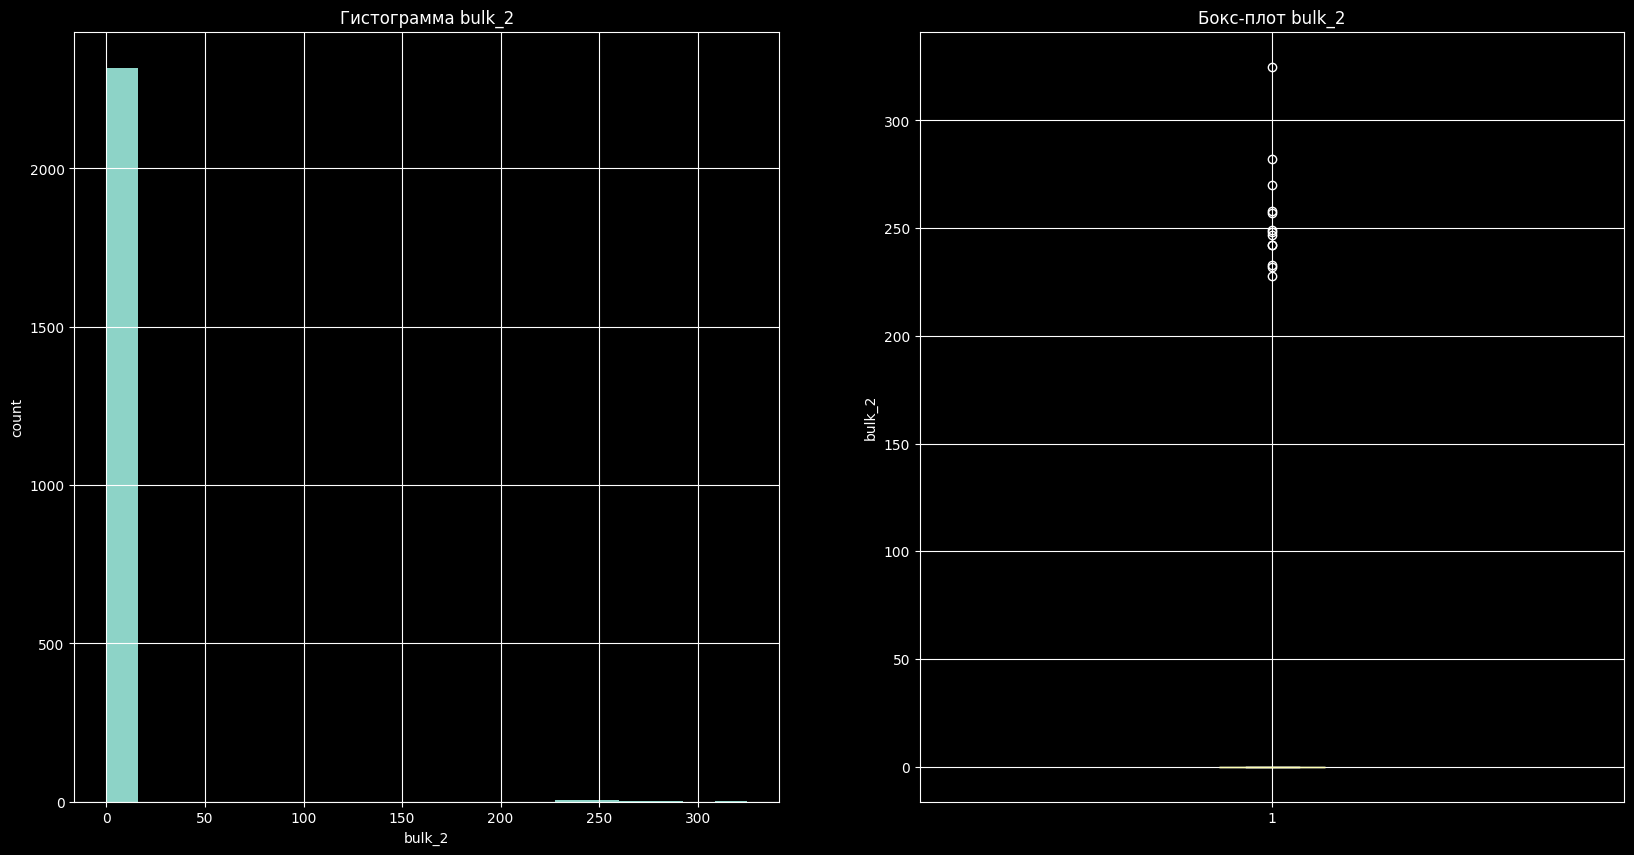


bulk_3
count    2329.000000
mean       47.348218
std        75.310430
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: bulk_3, dtype: float64


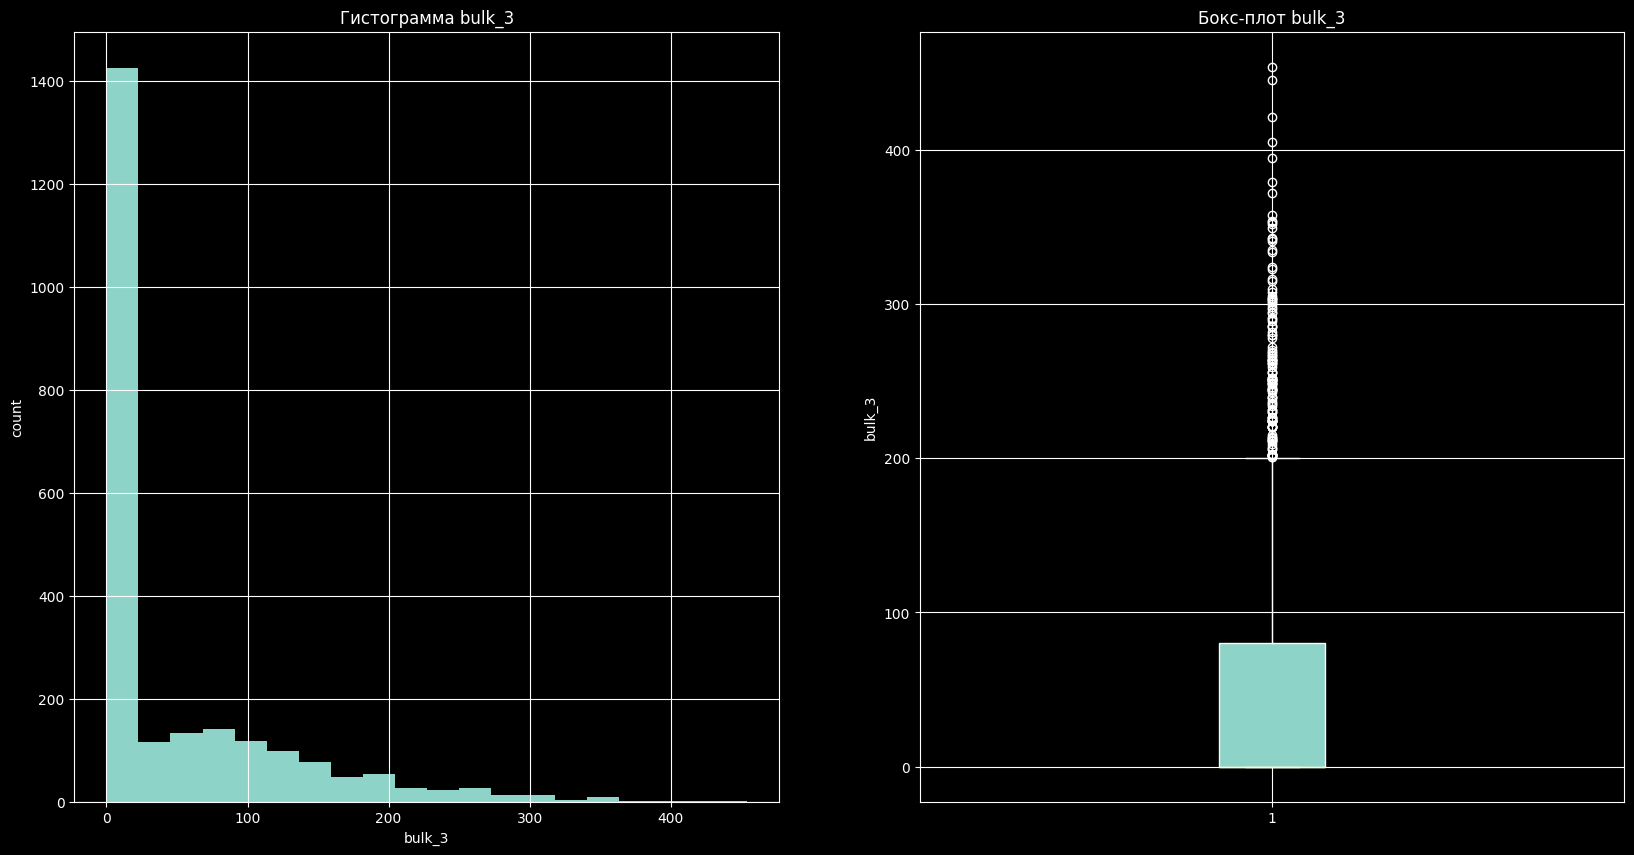


bulk_4
count    2329.000000
mean       37.303564
std        58.643238
min         0.000000
25%         0.000000
50%         0.000000
75%        77.000000
max       281.000000
Name: bulk_4, dtype: float64


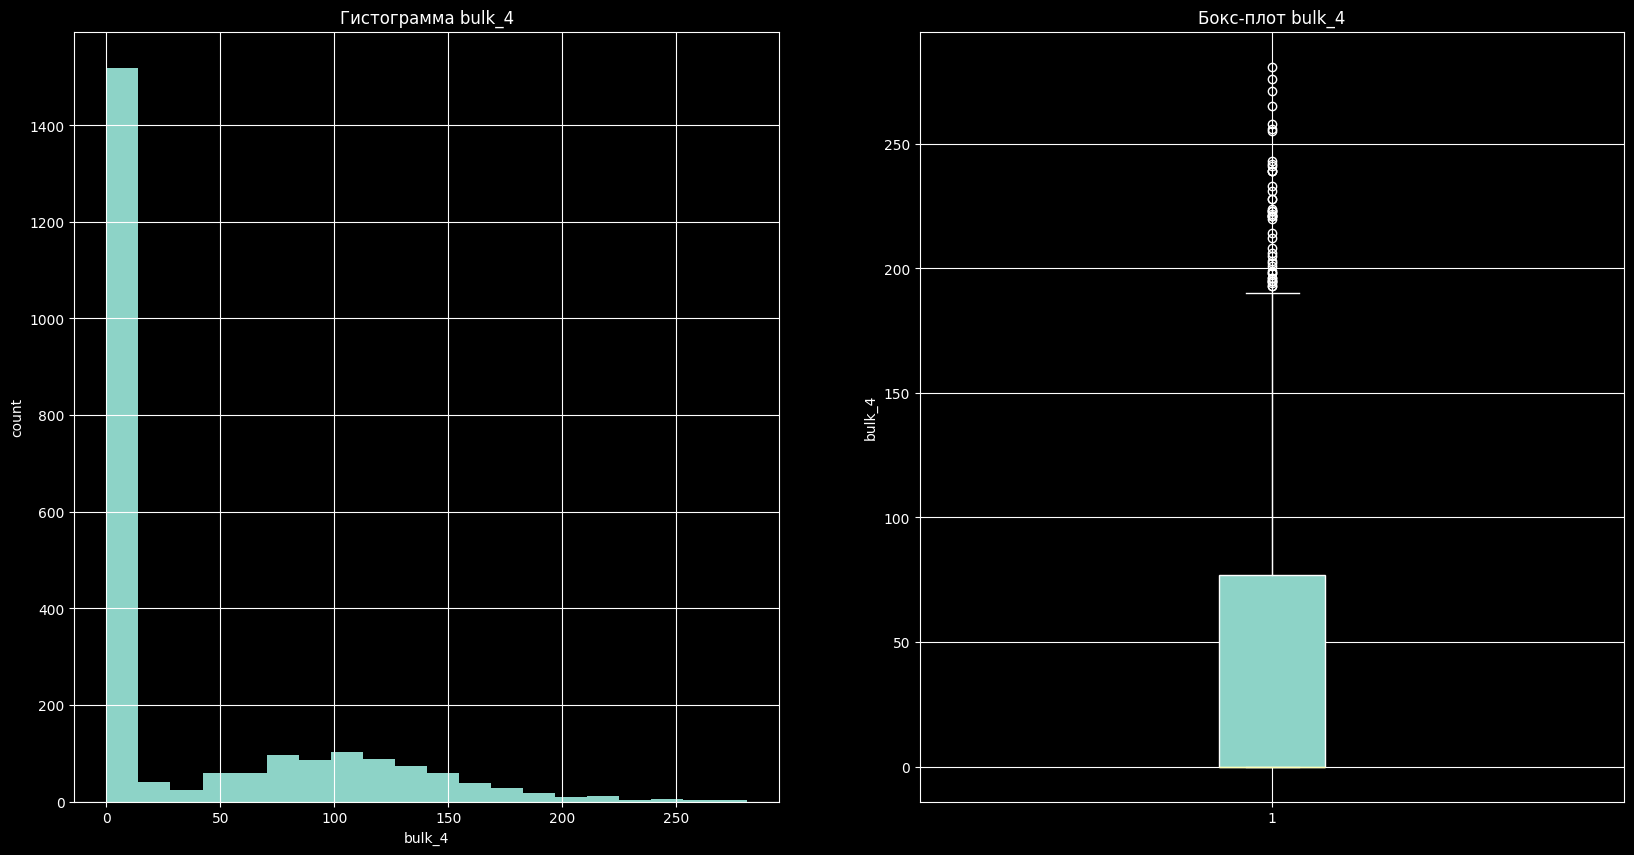


bulk_5
count    2329.000000
mean        2.640189
std        22.402293
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       603.000000
Name: bulk_5, dtype: float64


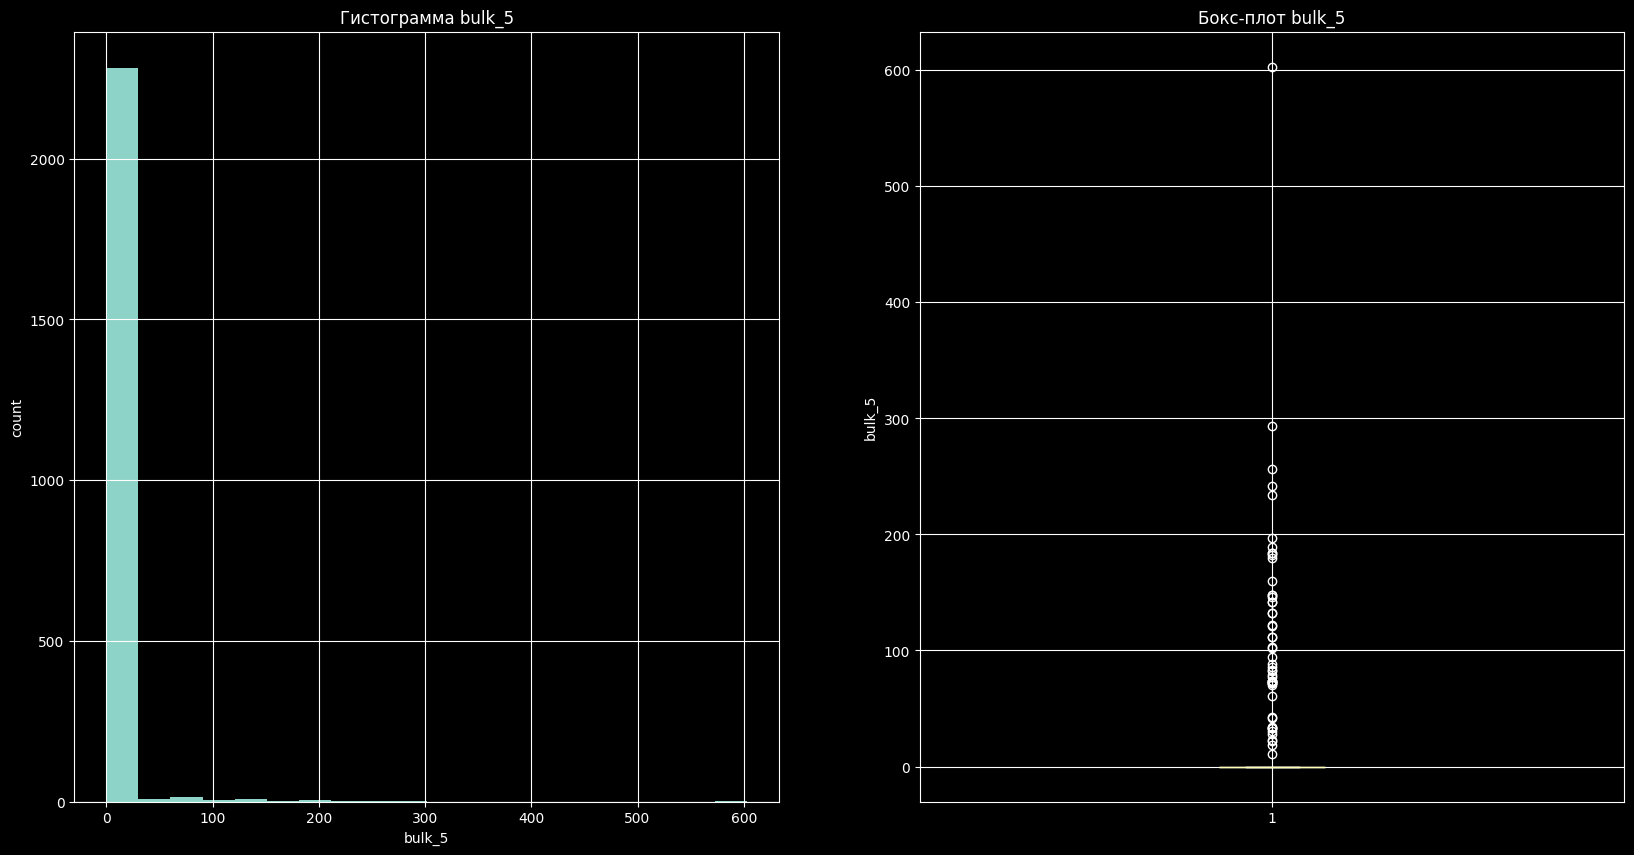


bulk_6
count    2329.000000
mean       22.430228
std        55.790873
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       503.000000
Name: bulk_6, dtype: float64


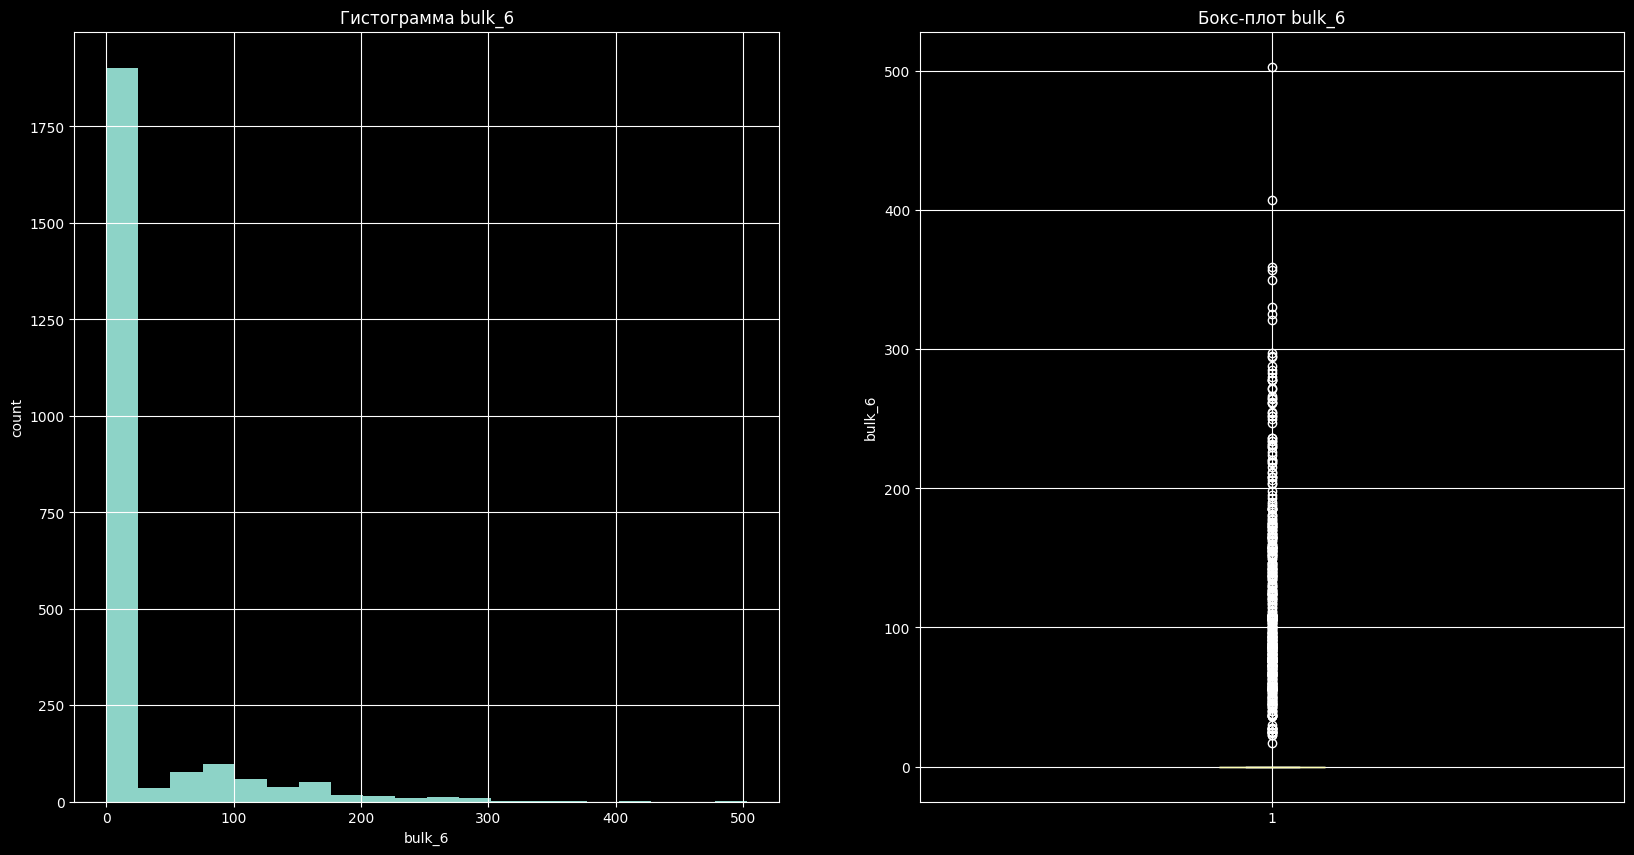


bulk_7
count    2329.000000
mean        2.004723
std        30.676234
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       772.000000
Name: bulk_7, dtype: float64


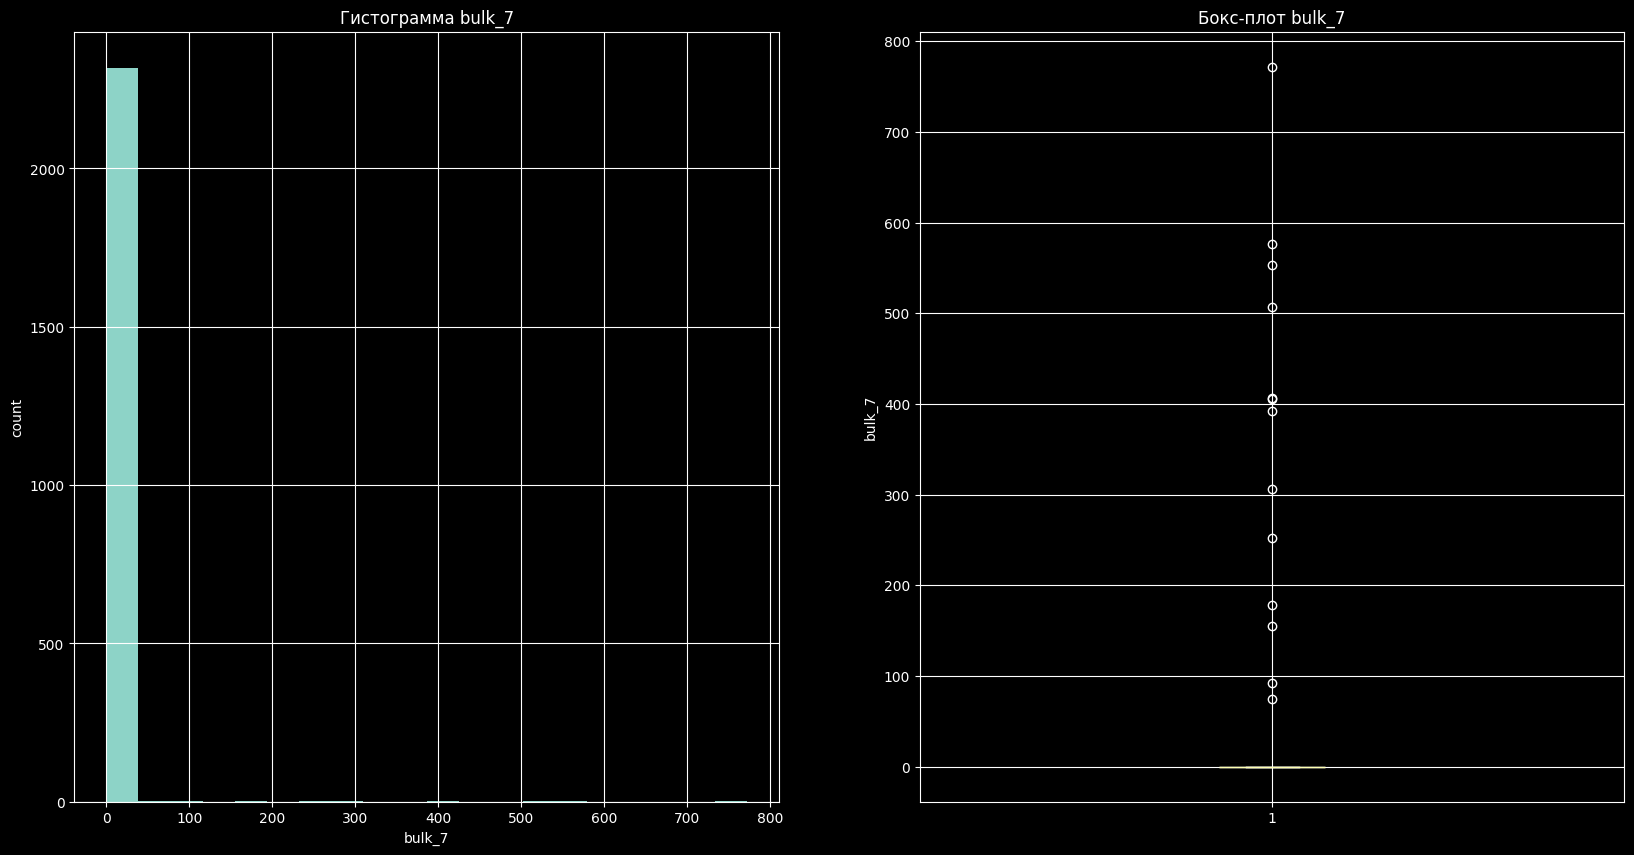


bulk_8
count    2329.000000
mean        0.021039
std         1.015340
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        49.000000
Name: bulk_8, dtype: float64


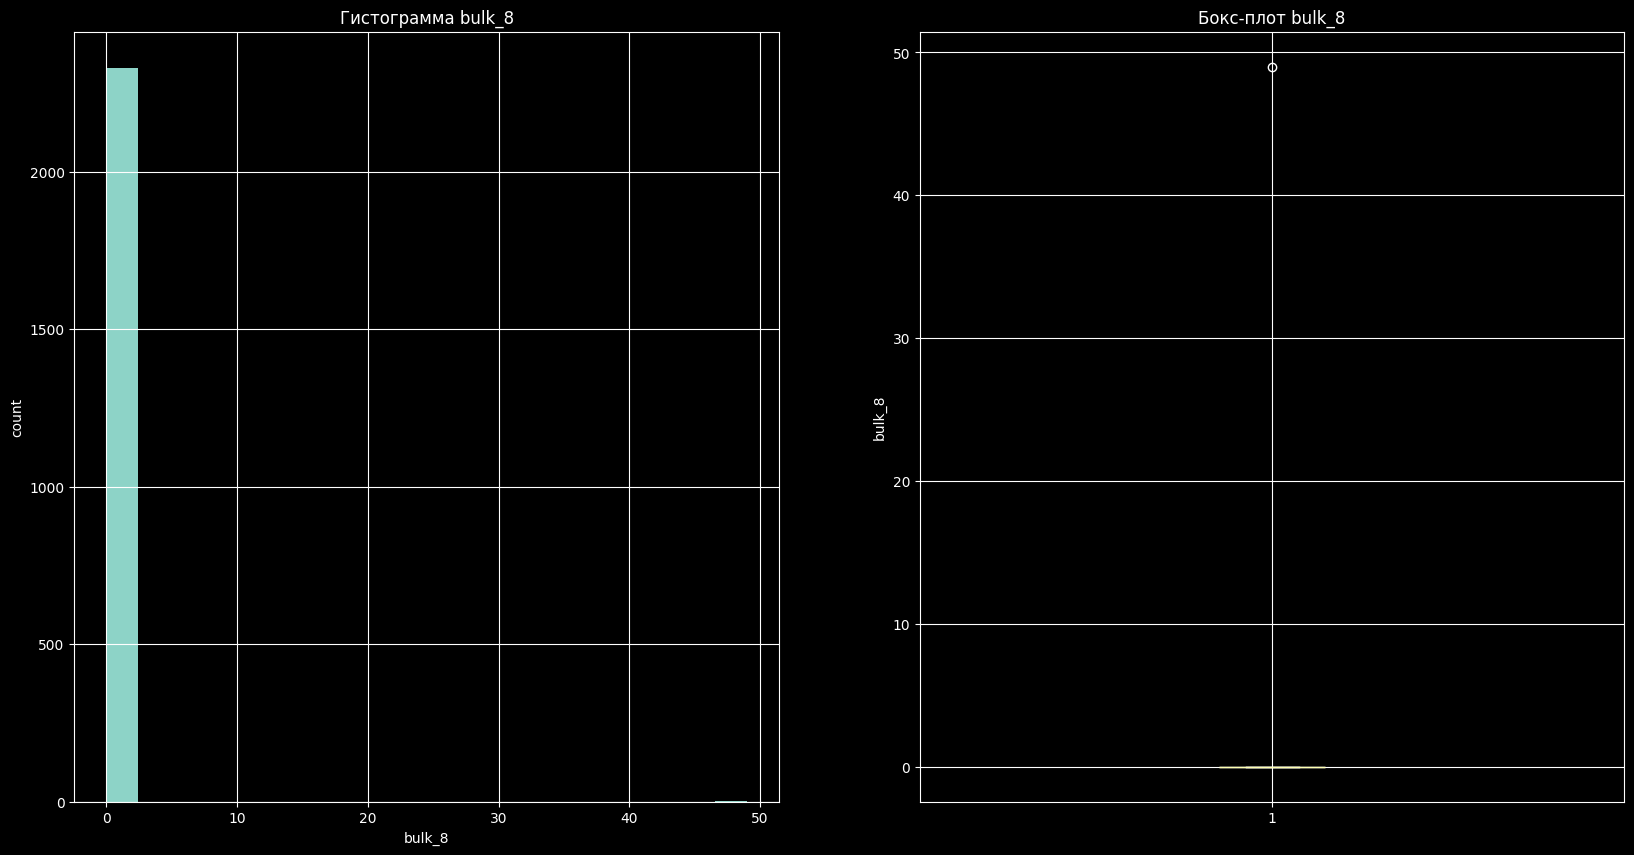


bulk_9
count    2329.000000
mean        0.444826
std         6.220641
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       147.000000
Name: bulk_9, dtype: float64


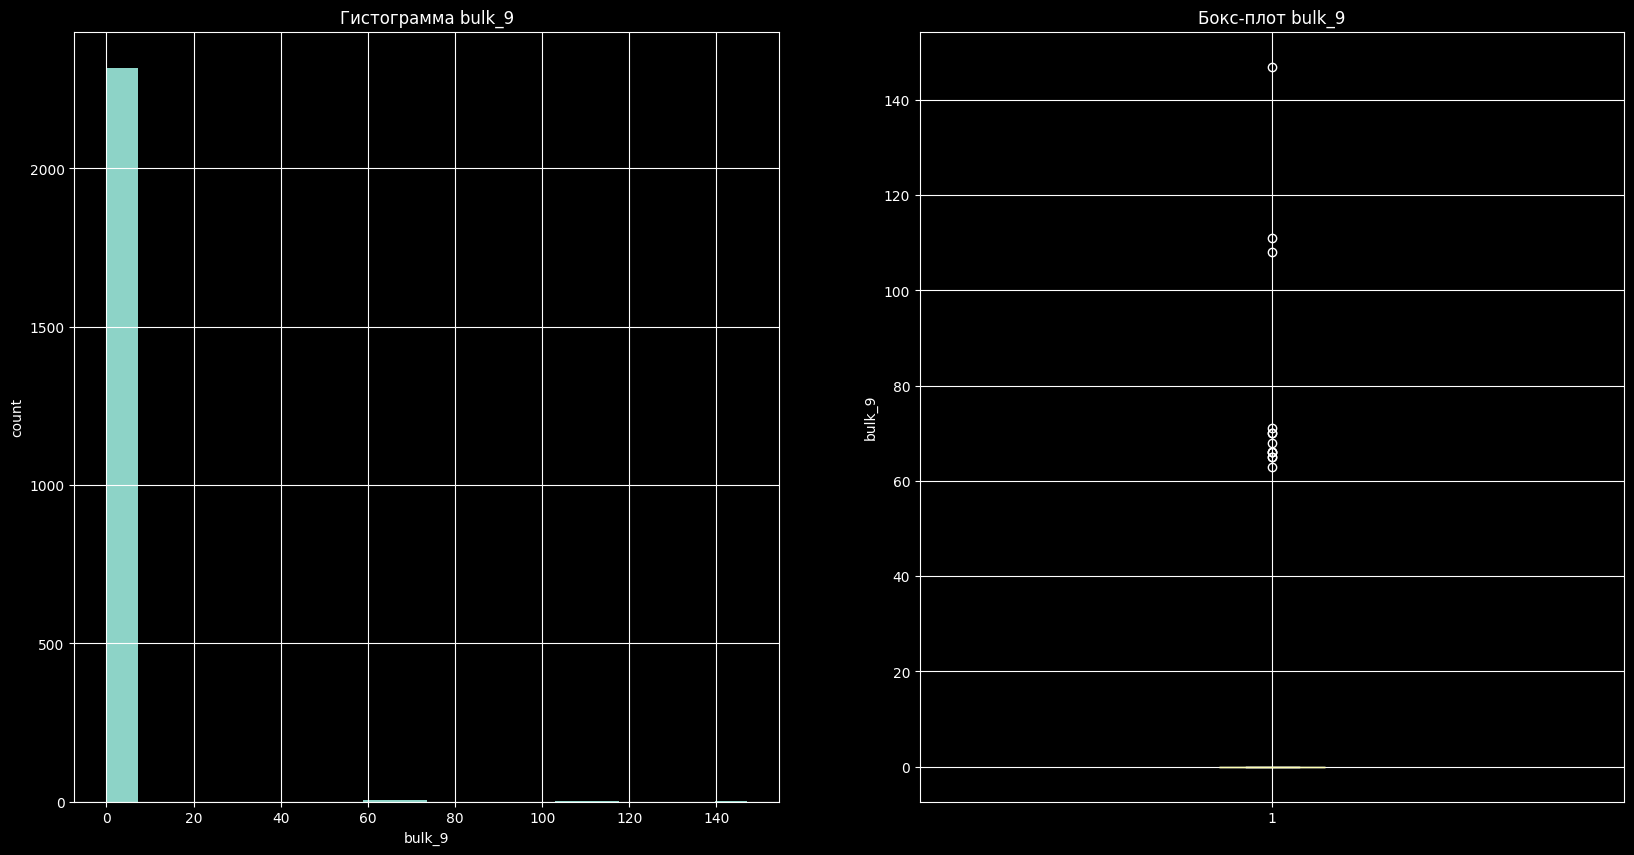


bulk_10
count    2329.000000
mean        5.052812
std        20.917800
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       159.000000
Name: bulk_10, dtype: float64


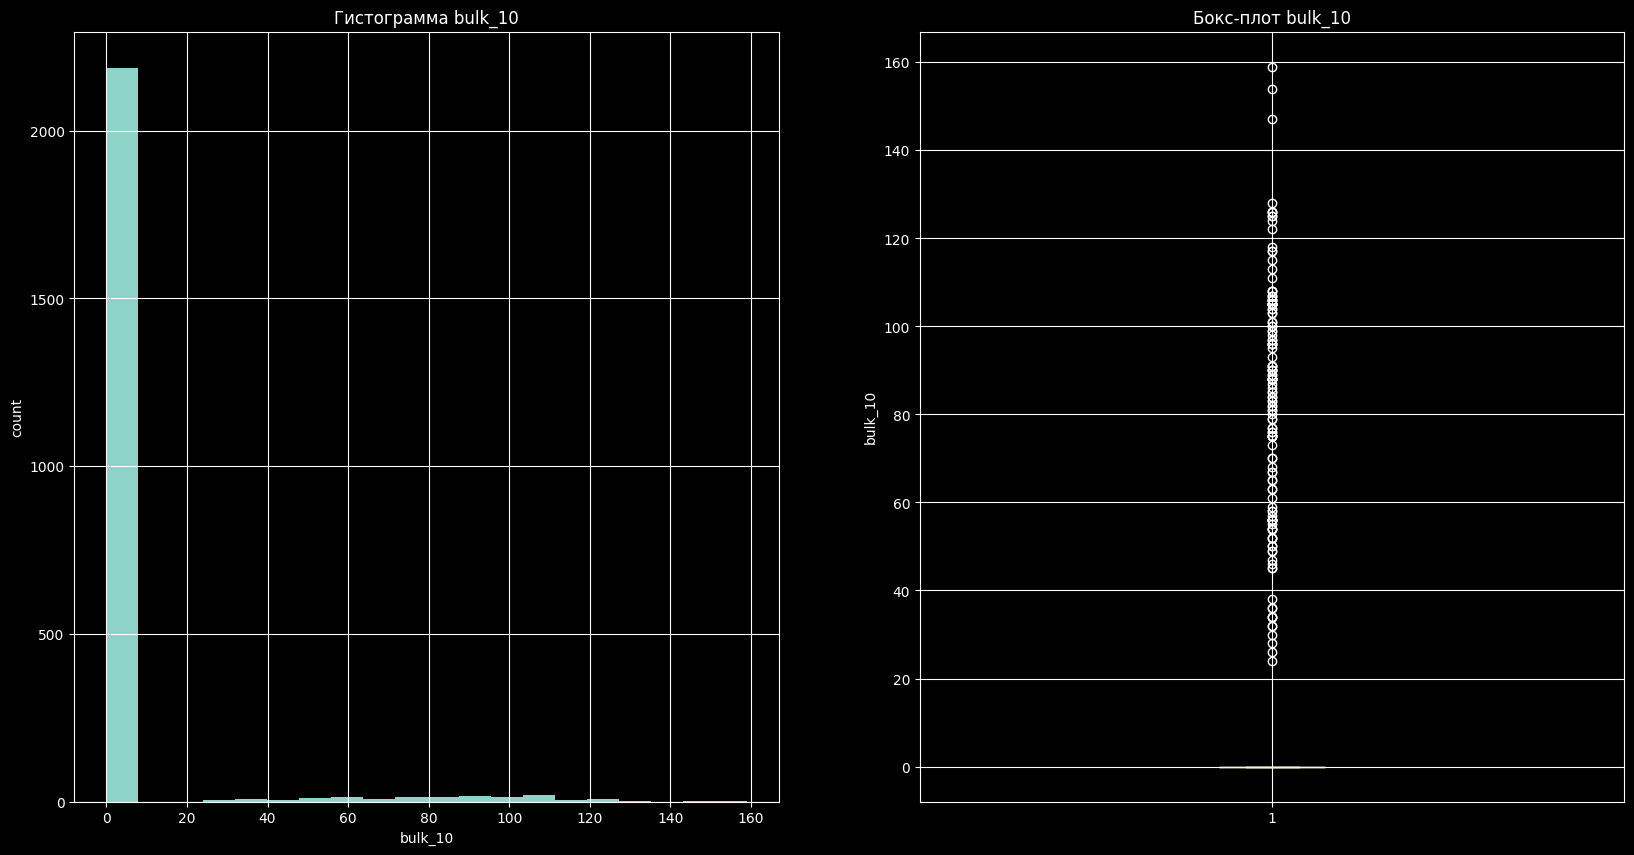


bulk_11
count    2329.000000
mean        4.245170
std        22.515487
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       313.000000
Name: bulk_11, dtype: float64


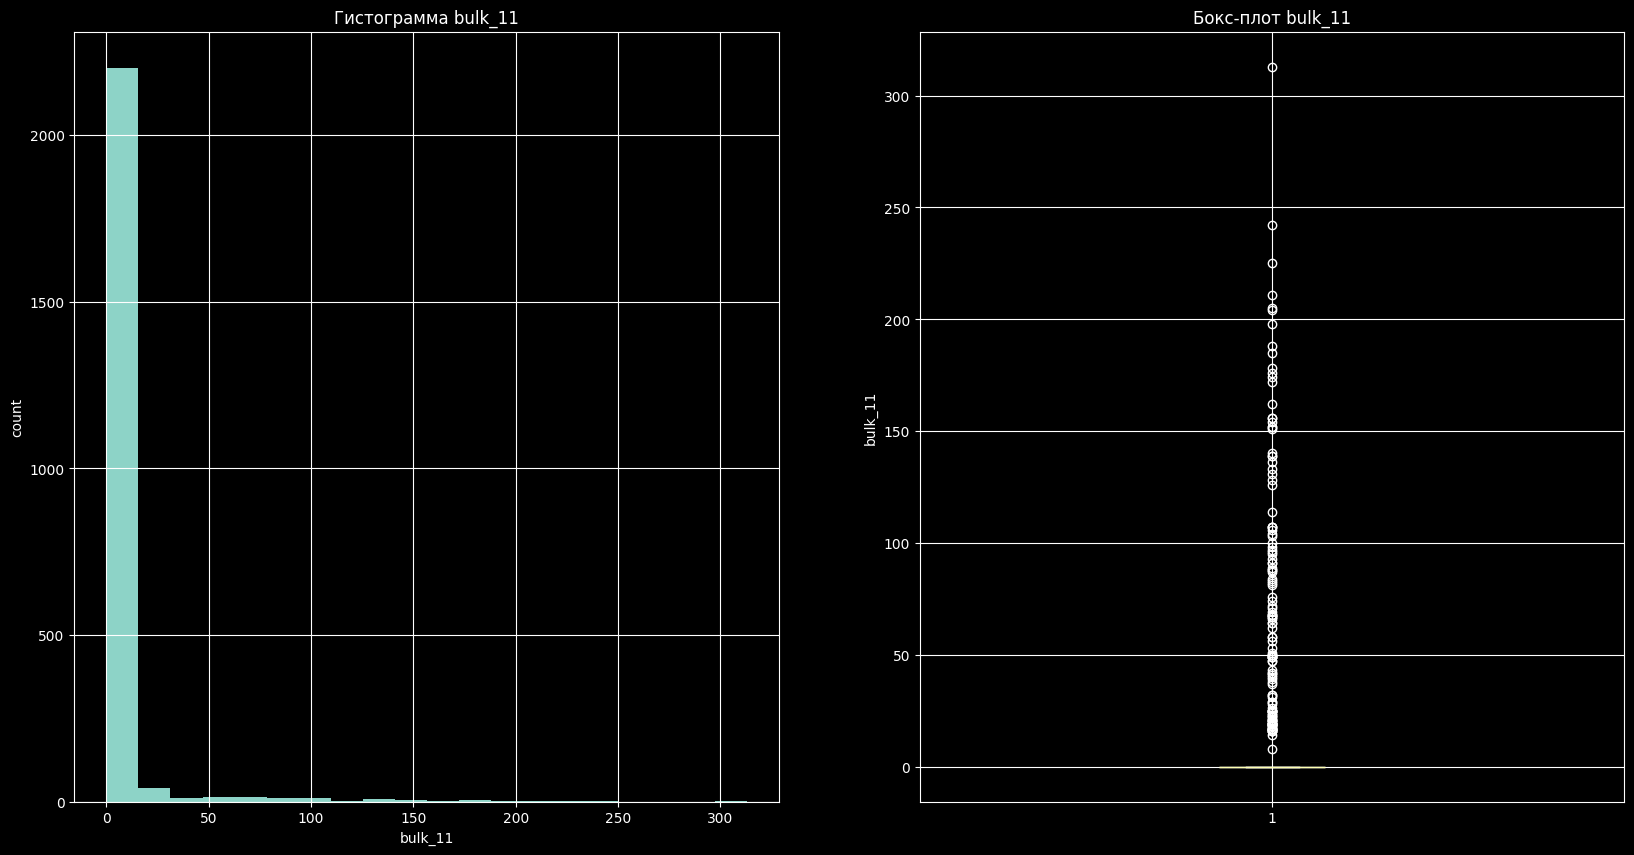


bulk_12
count    2329.000000
mean      208.415629
std       157.062272
min         0.000000
25%       105.000000
50%       206.000000
75%       282.000000
max      1849.000000
Name: bulk_12, dtype: float64


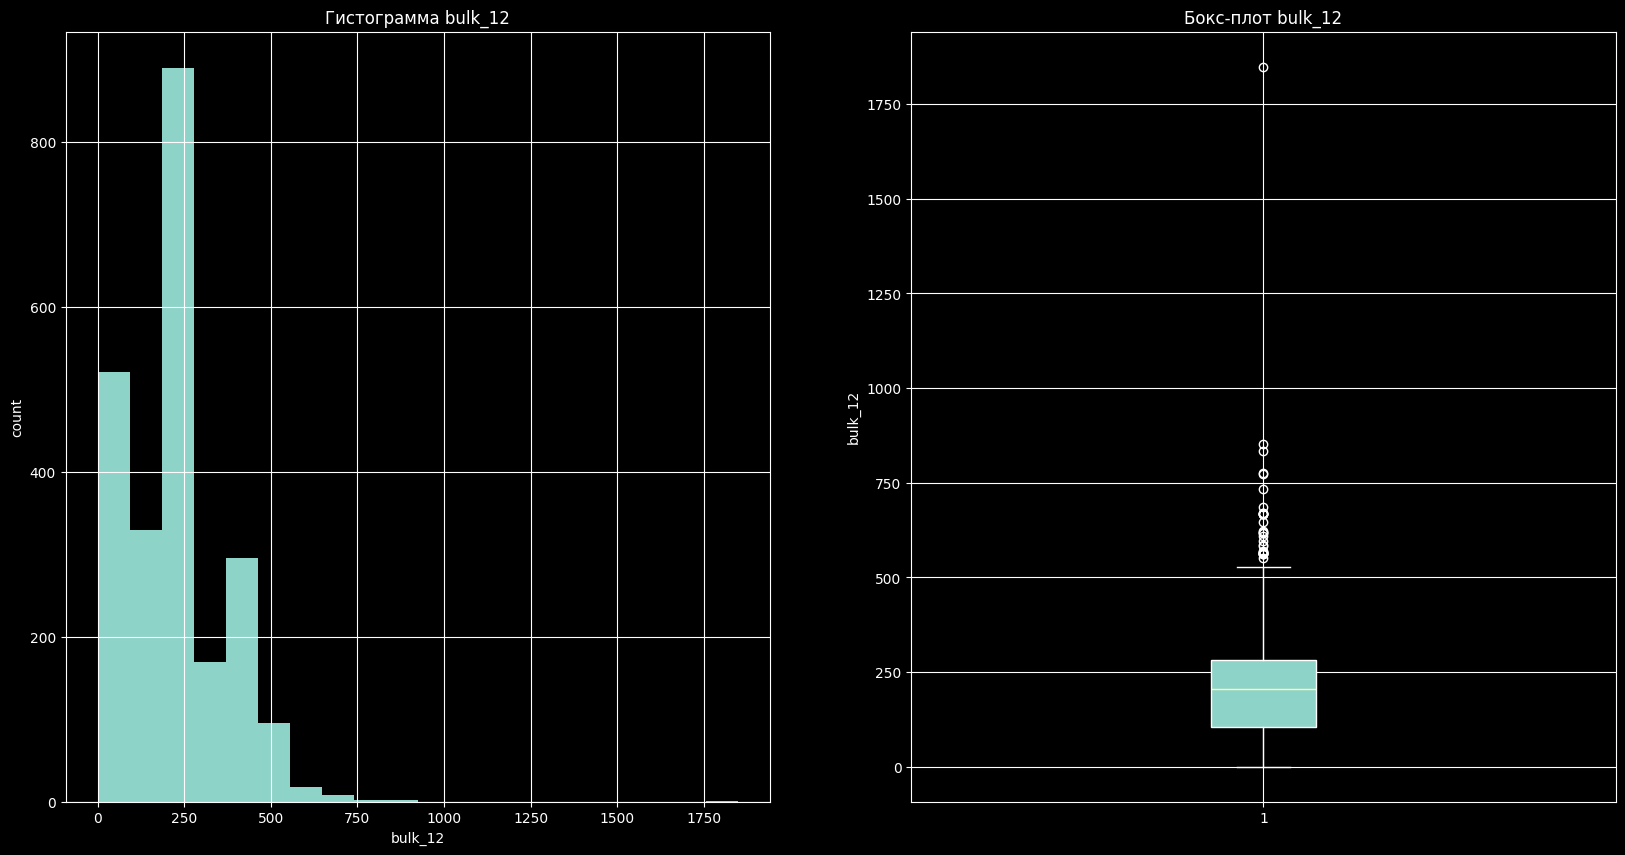


bulk_13
count    2329.000000
mean        1.067411
std        14.235055
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       305.000000
Name: bulk_13, dtype: float64


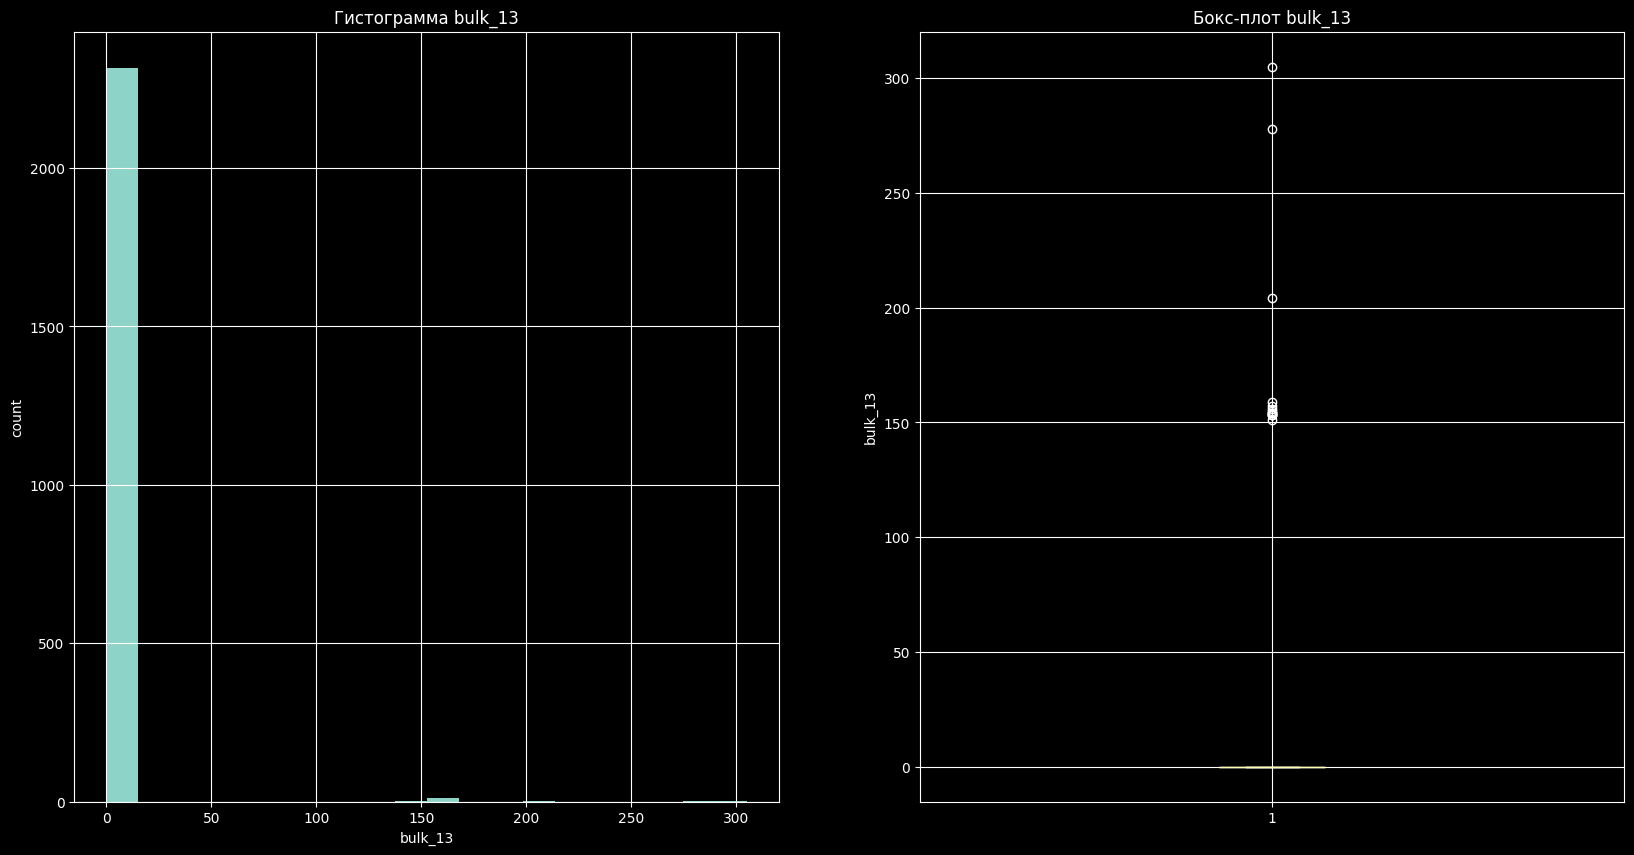


bulk_14
count    2329.000000
mean      153.853585
std        81.404354
min         0.000000
25%       105.000000
50%       149.000000
75%       204.000000
max       636.000000
Name: bulk_14, dtype: float64


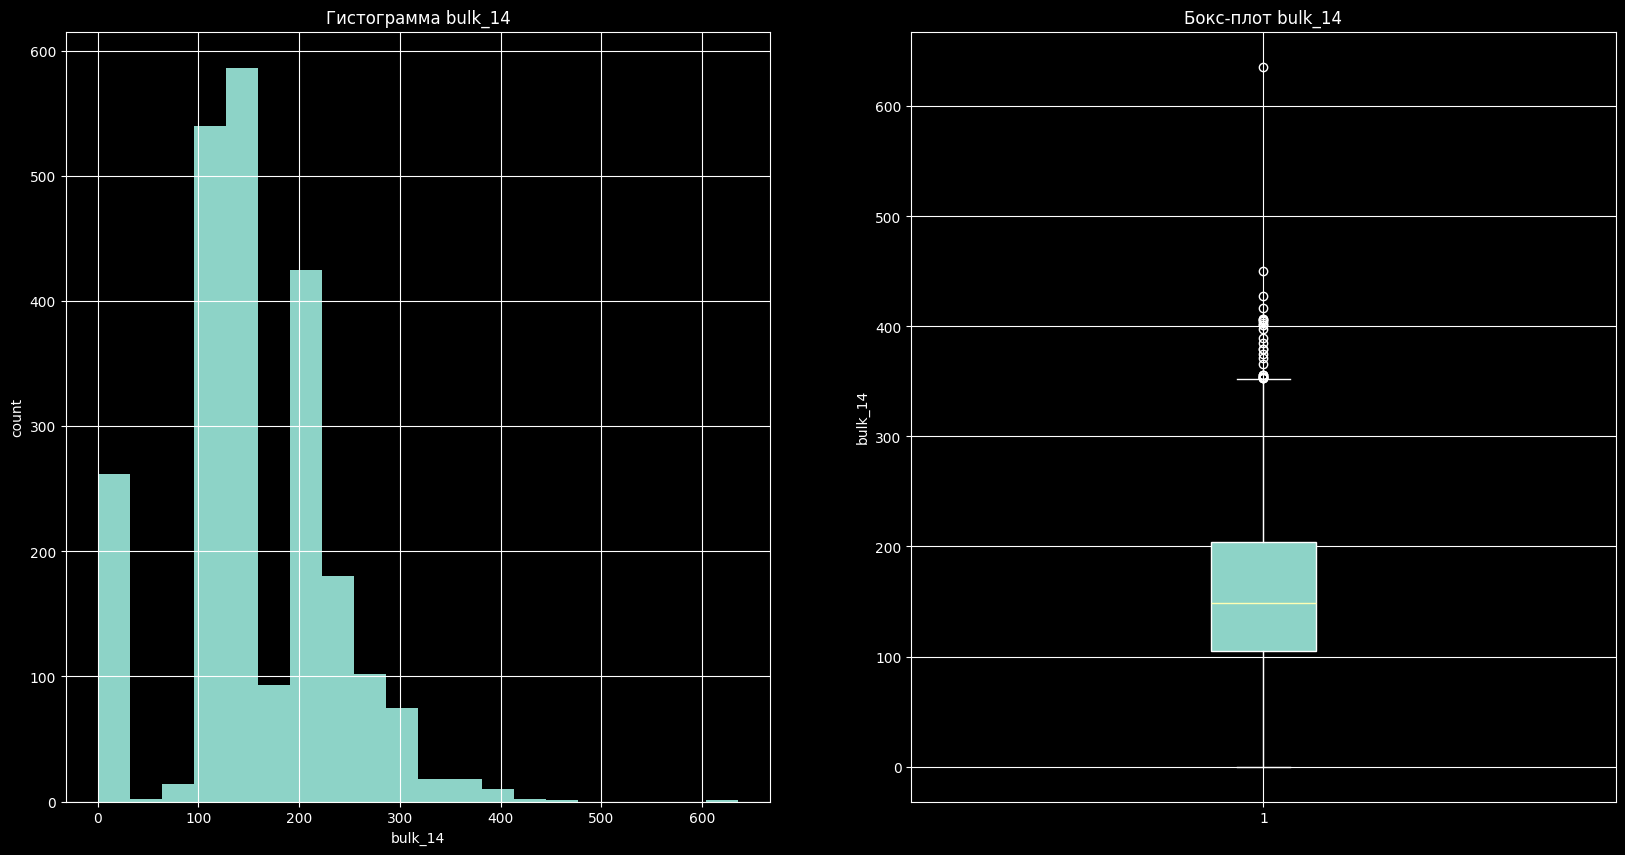


bulk_15
count    2329.000000
mean      119.952769
std        84.640443
min         0.000000
25%         0.000000
50%       107.000000
75%       204.000000
max       405.000000
Name: bulk_15, dtype: float64


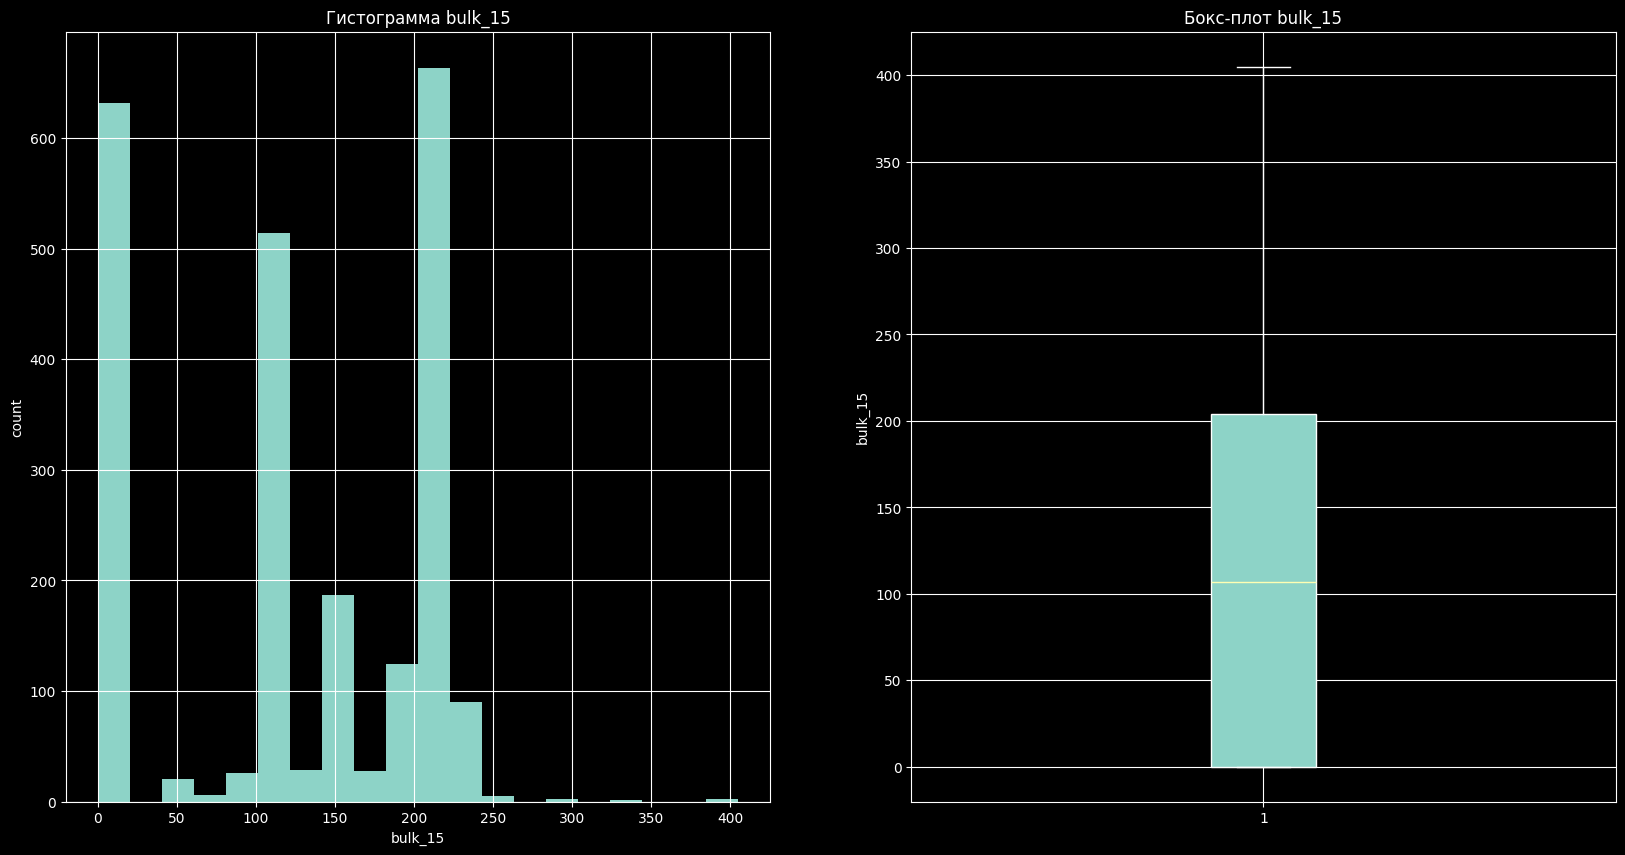


wire_1
count    2329.000000
mean      102.443601
std        43.539993
min         0.000000
25%        73.207679
50%       101.119201
75%       128.091599
max       330.314424
Name: wire_1, dtype: float64


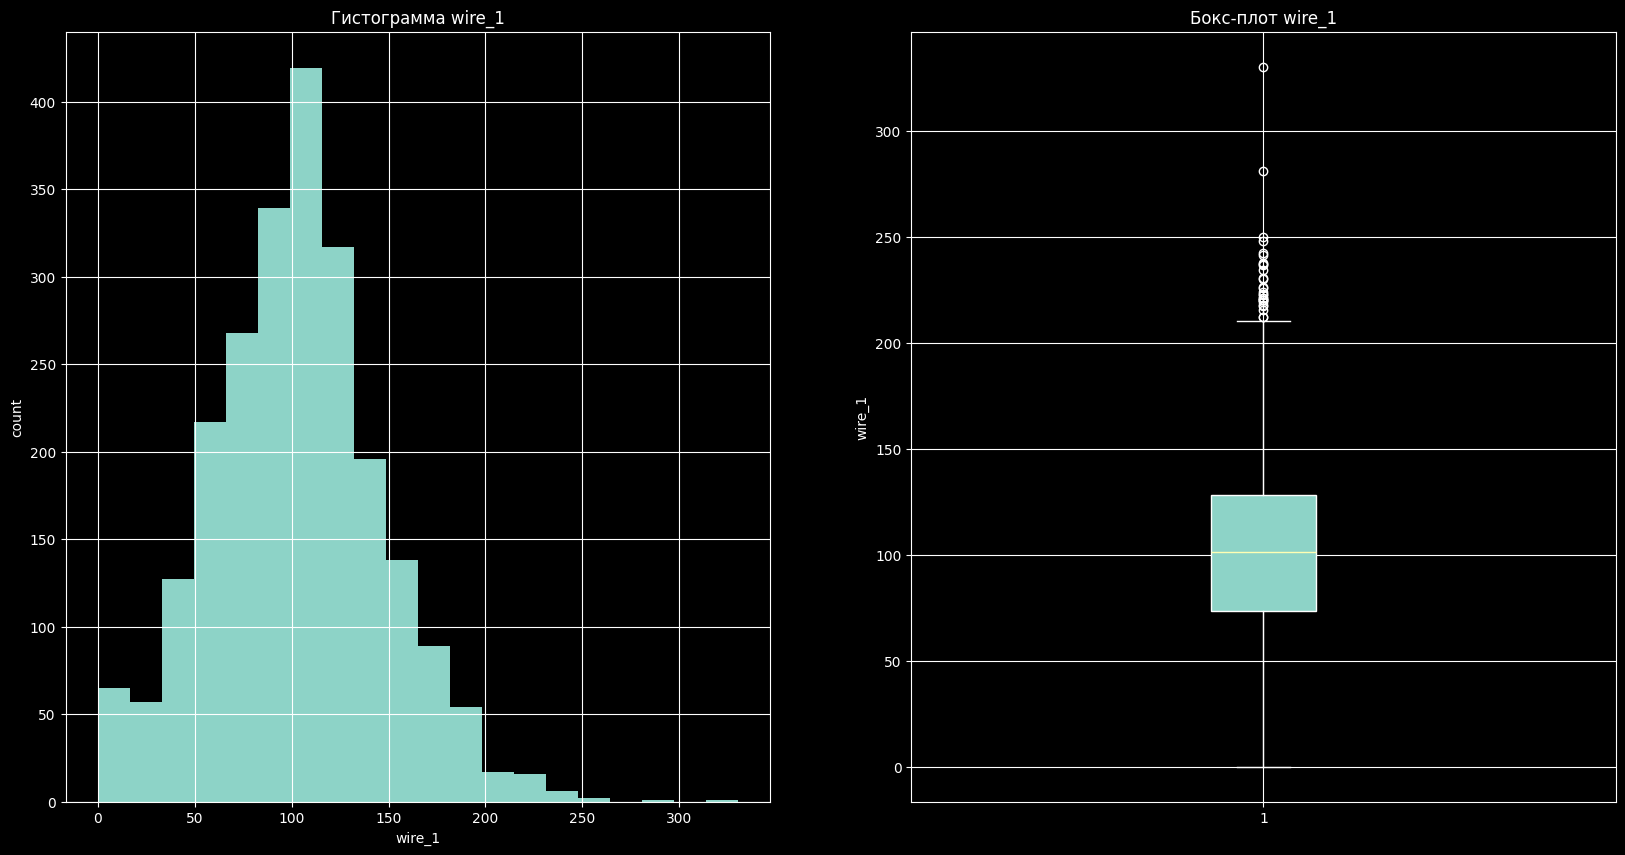


wire_2
count    2329.000000
mean       17.609859
std        33.624771
min         0.000000
25%         0.000000
50%         0.000000
75%        23.102560
max       282.780152
Name: wire_2, dtype: float64


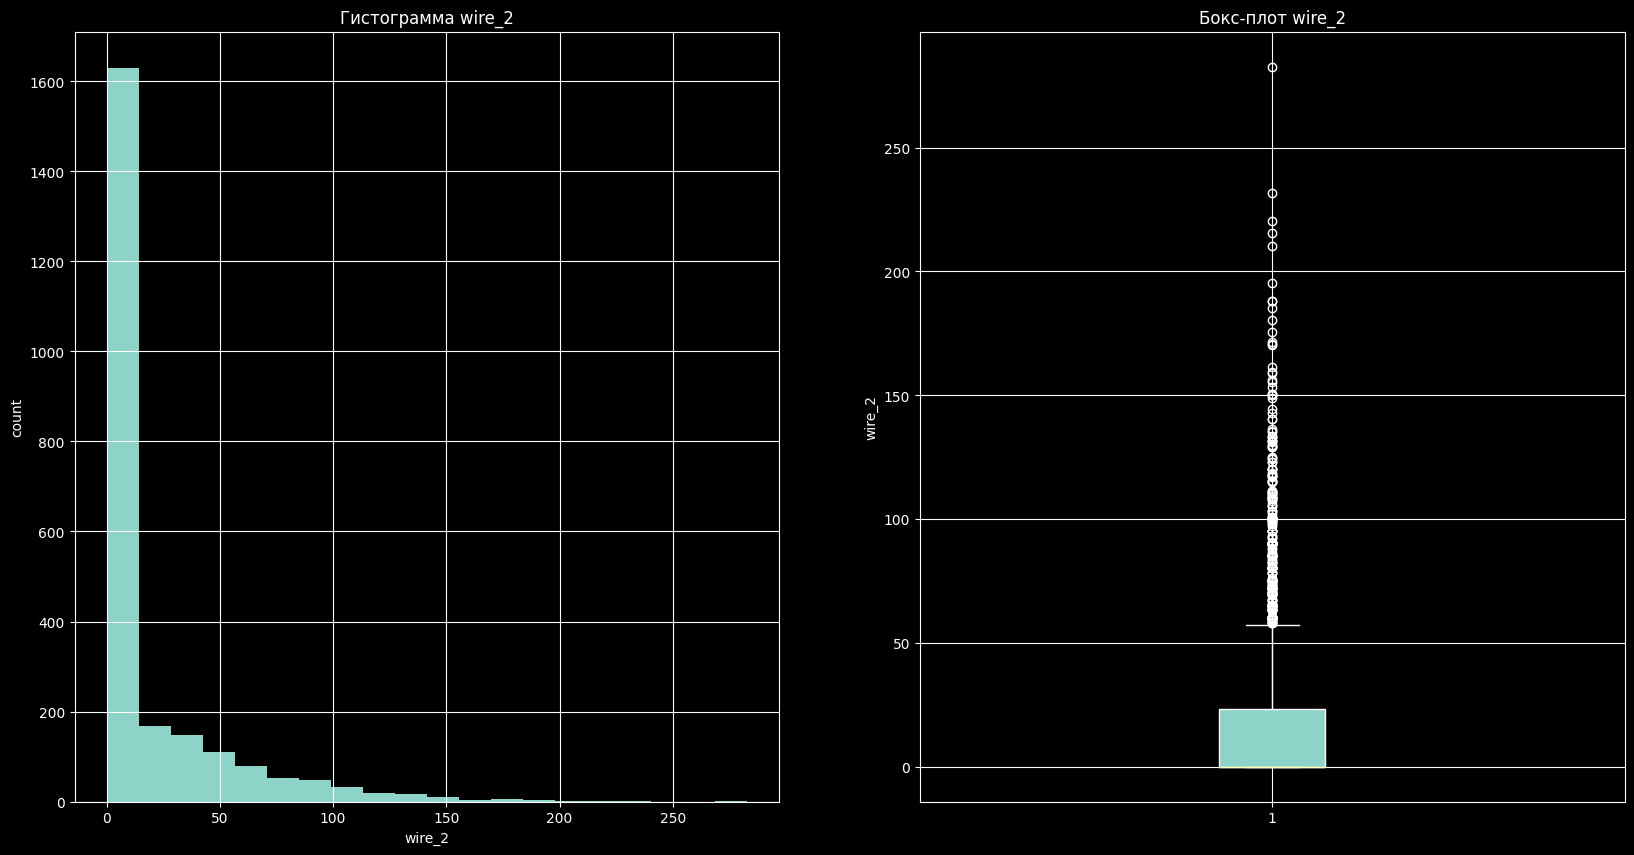


wire_3
count    2329.000000
mean        3.234916
std        27.942871
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       385.008668
Name: wire_3, dtype: float64


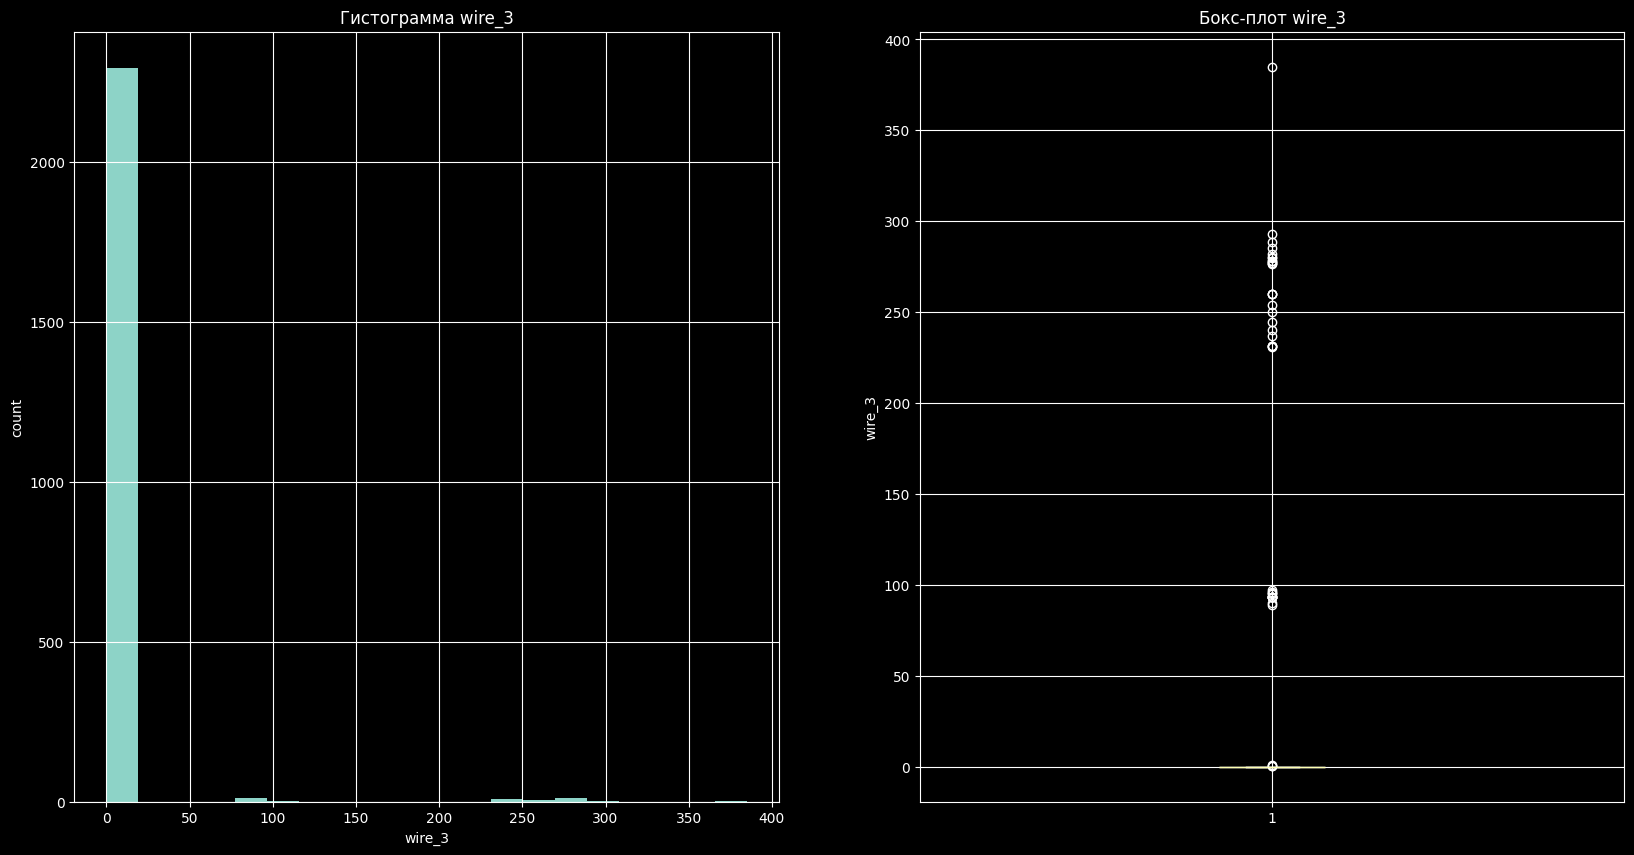


wire_4
count    2329.000000
mean        0.306550
std         4.757746
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       113.231044
Name: wire_4, dtype: float64


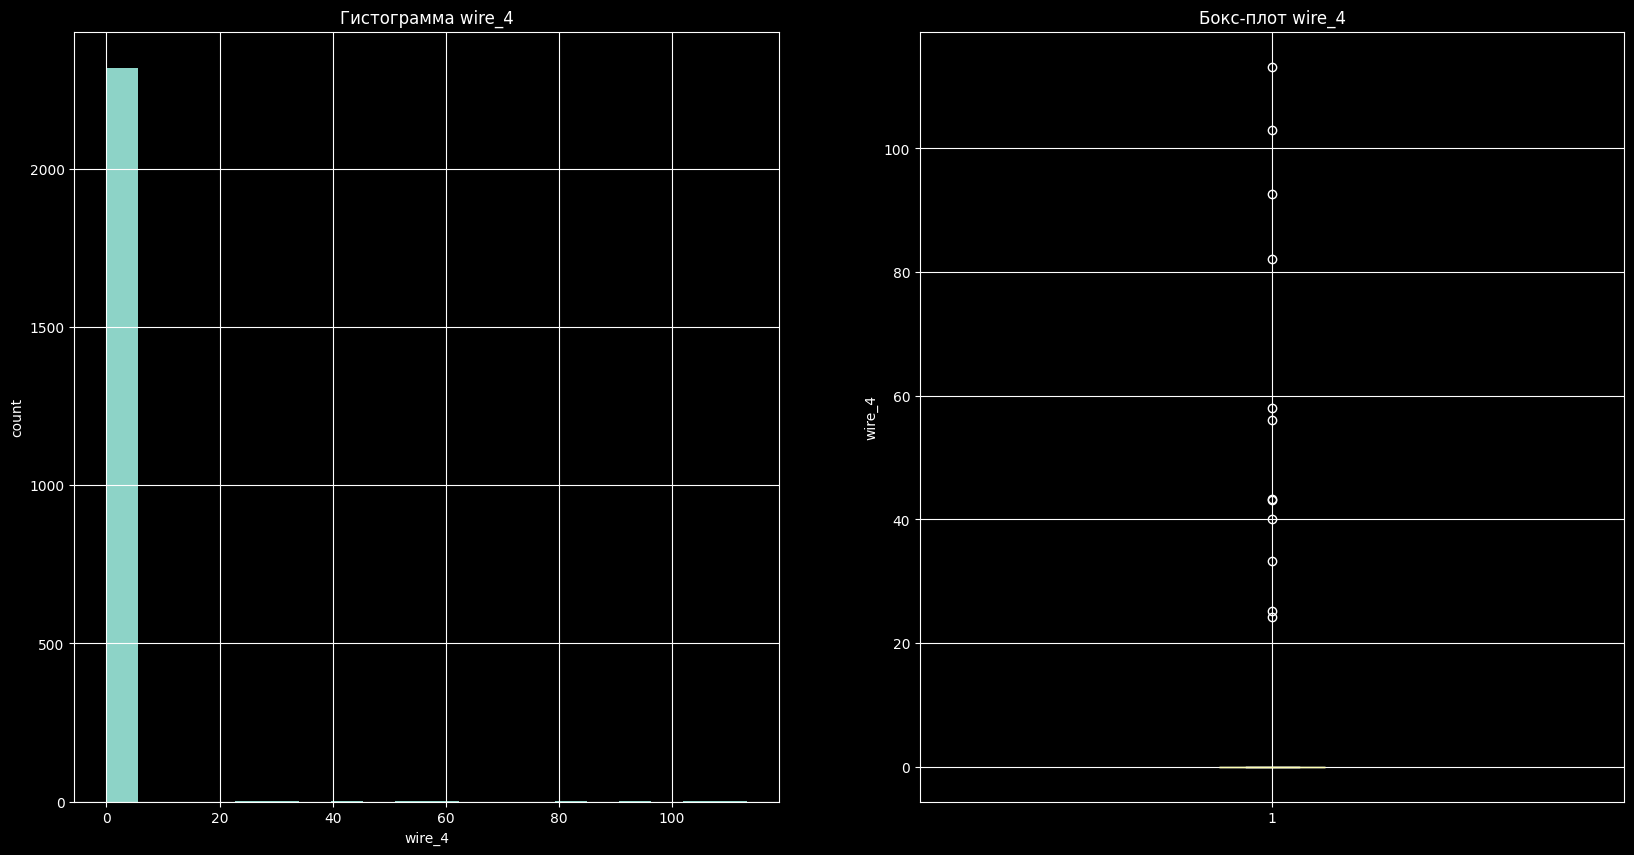


wire_5
count    2329.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: wire_5, dtype: float64


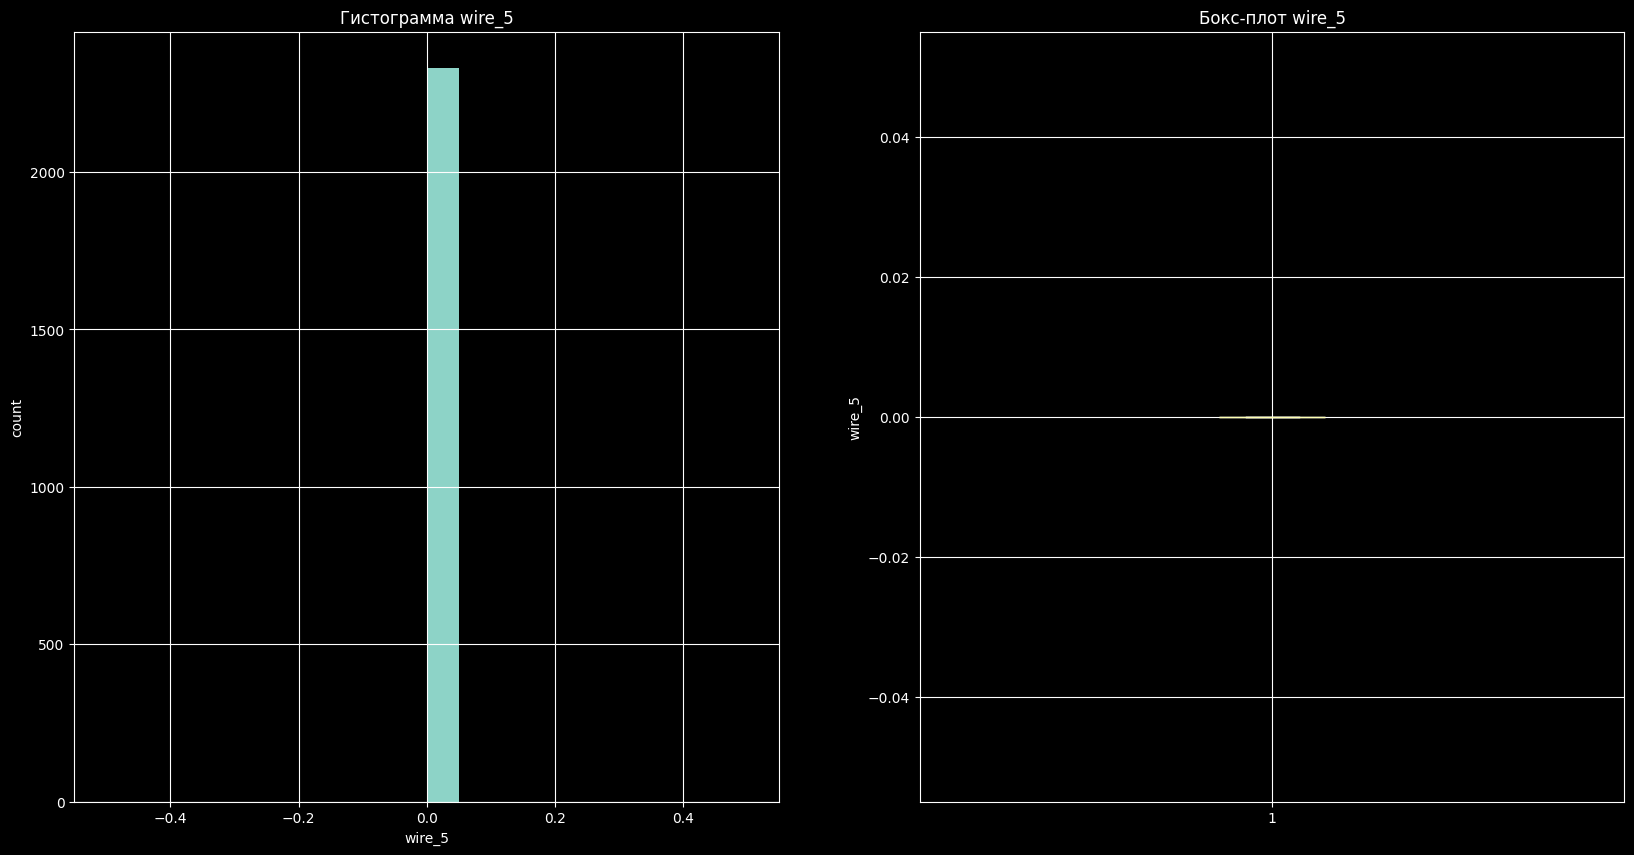


wire_6
count    2329.000000
mean        0.978820
std         8.693299
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       180.454575
Name: wire_6, dtype: float64


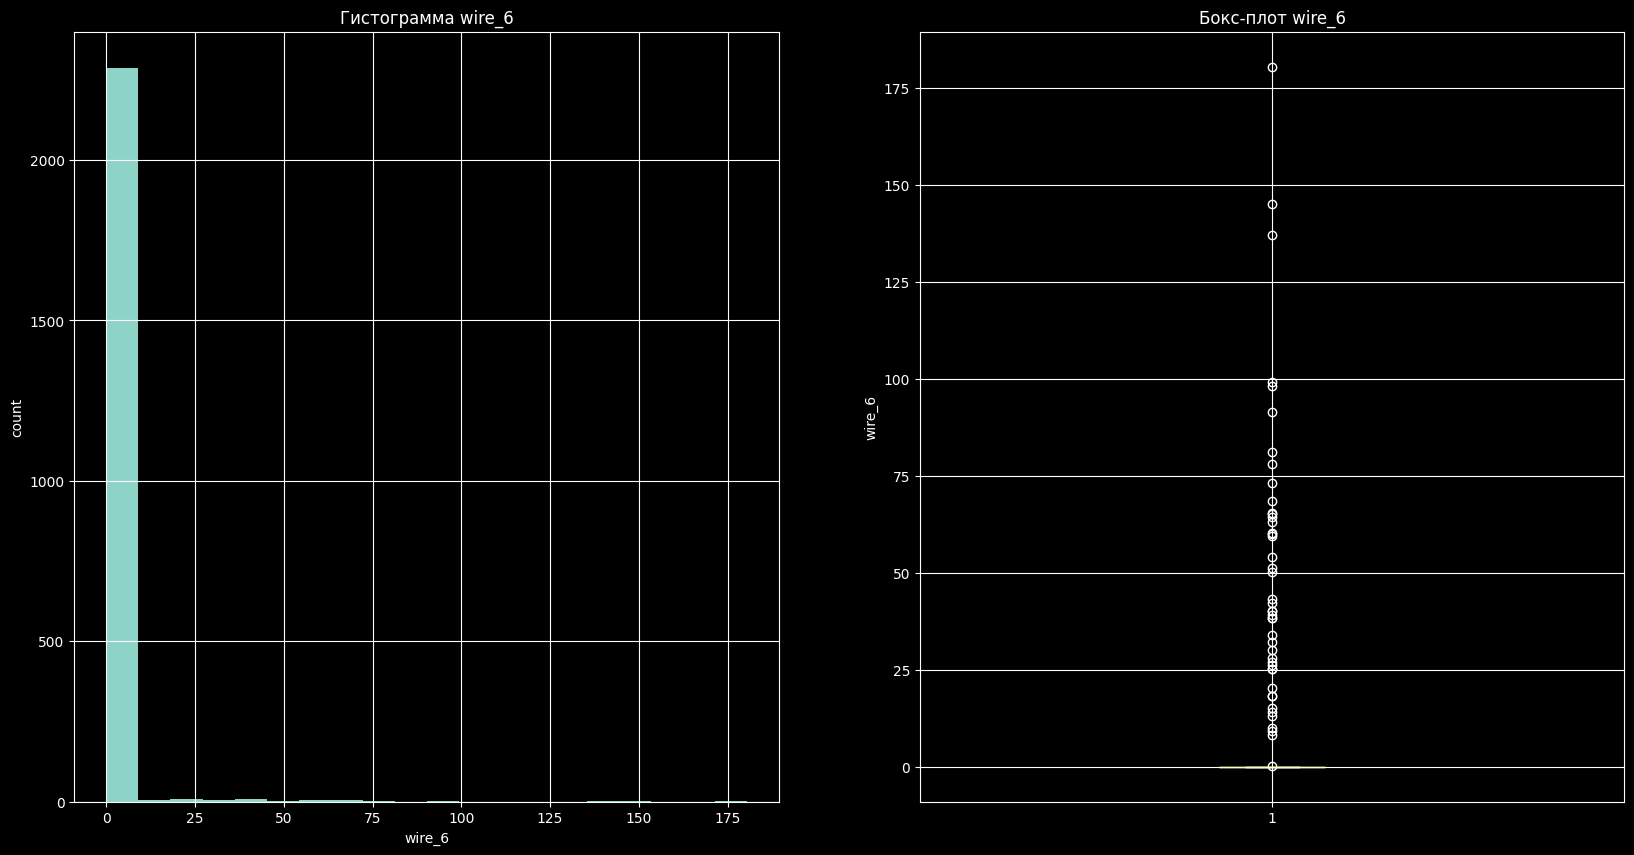


wire_7
count    2329.000000
mean        0.006361
std         0.205705
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.490040
Name: wire_7, dtype: float64


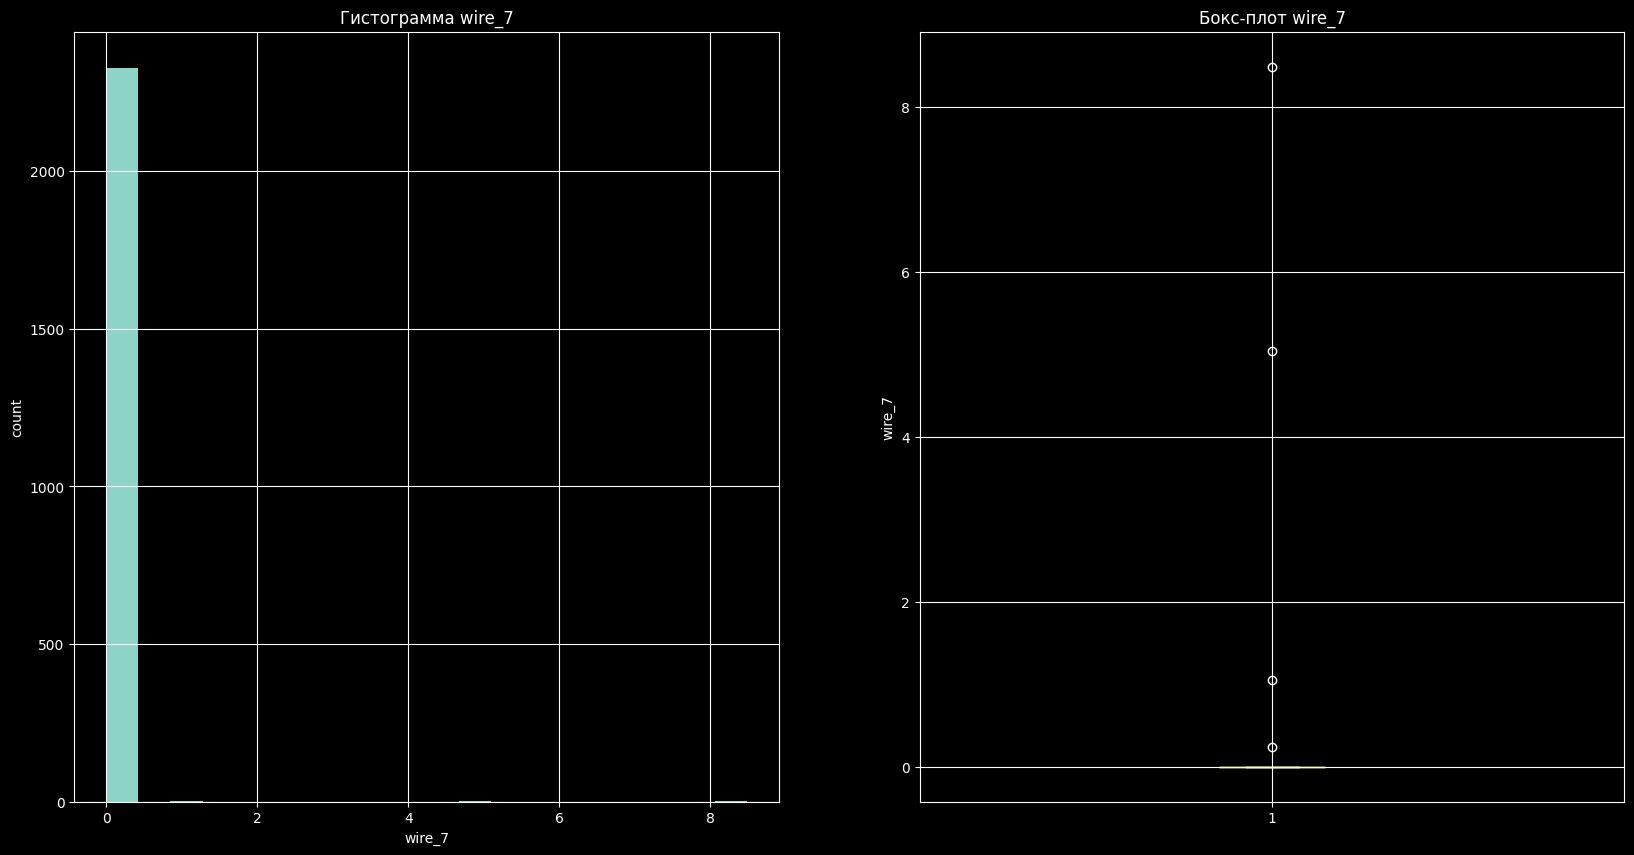


wire_8
count    2329.000000
mean        0.311311
std         4.402707
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       102.762401
Name: wire_8, dtype: float64


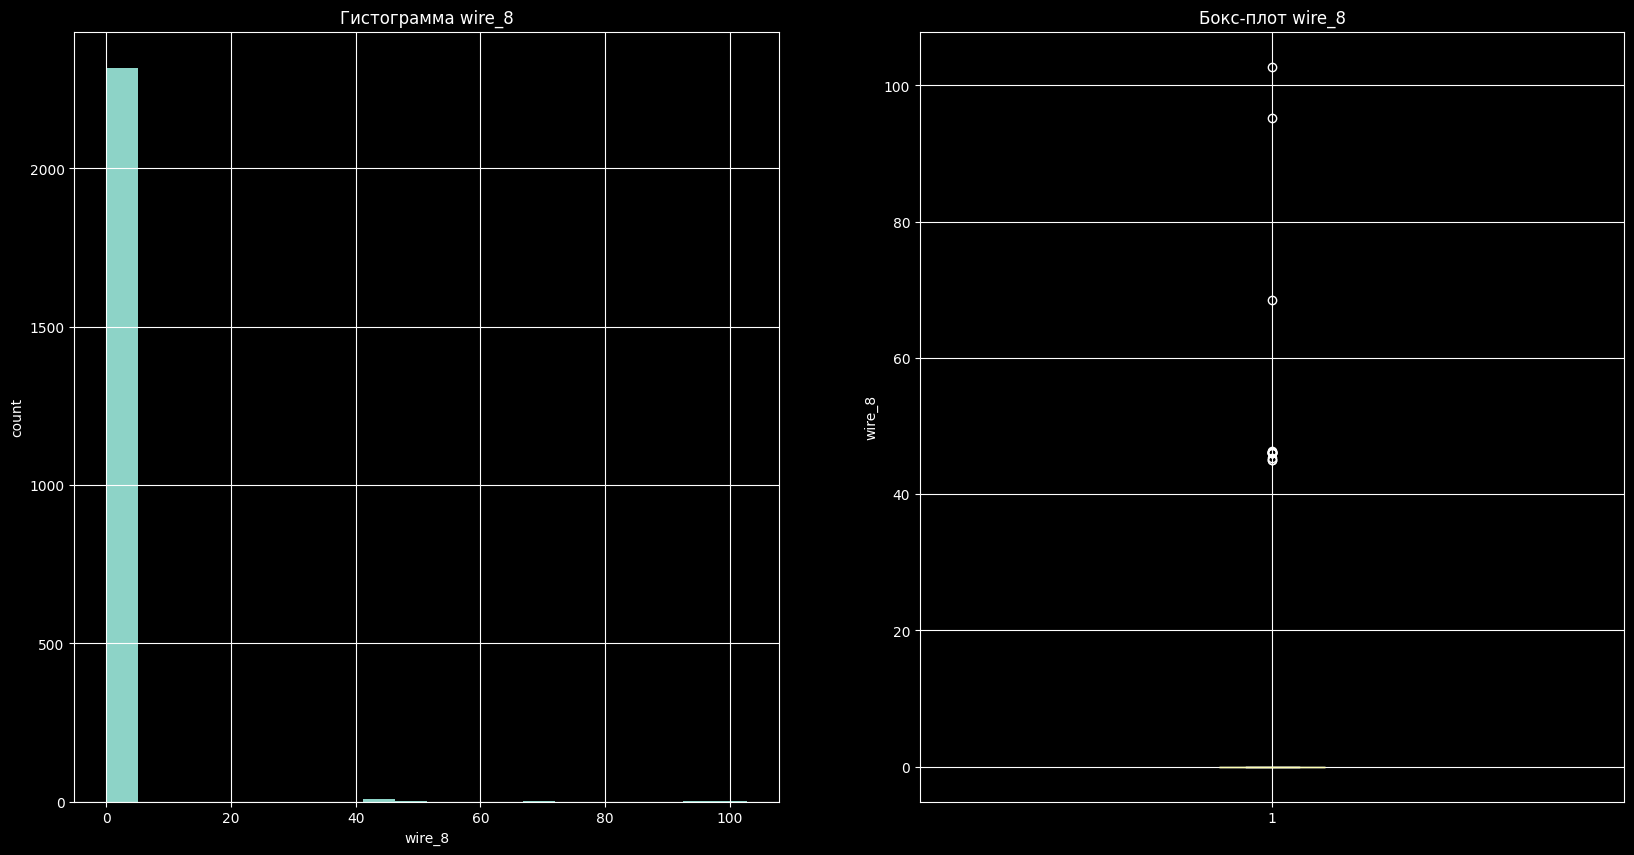


wire_9
count    2329.000000
mean        0.317113
std         3.456561
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        62.025600
Name: wire_9, dtype: float64


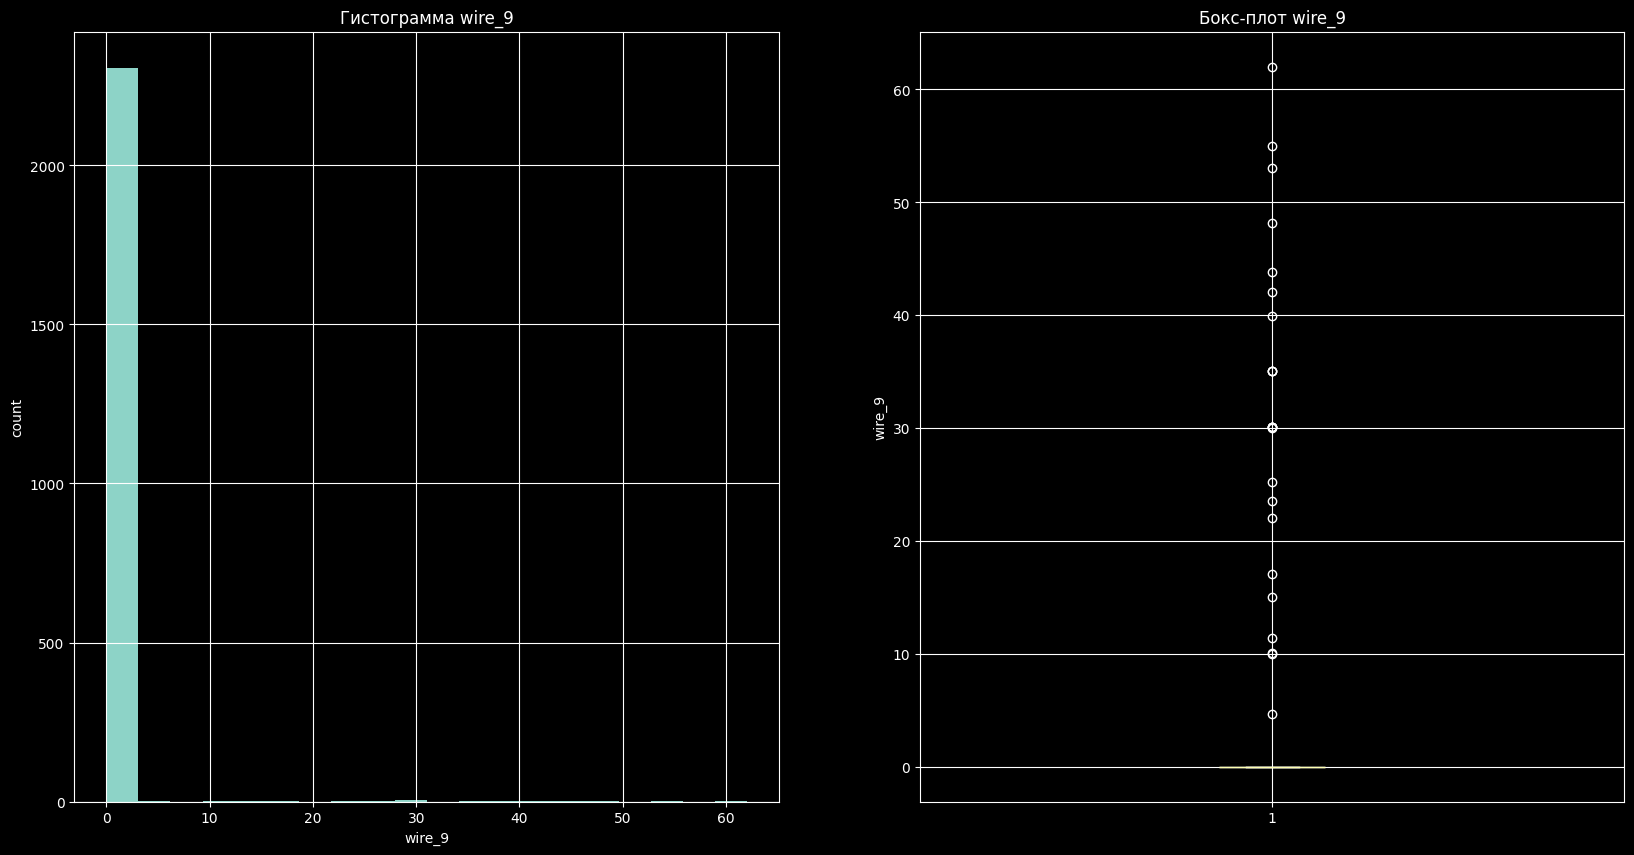


газ_1
count    2329.000000
mean       11.375600
std         6.392041
min         0.008399
25%         7.282948
50%        10.100950
75%        14.216688
max        77.995040
Name: газ_1, dtype: float64


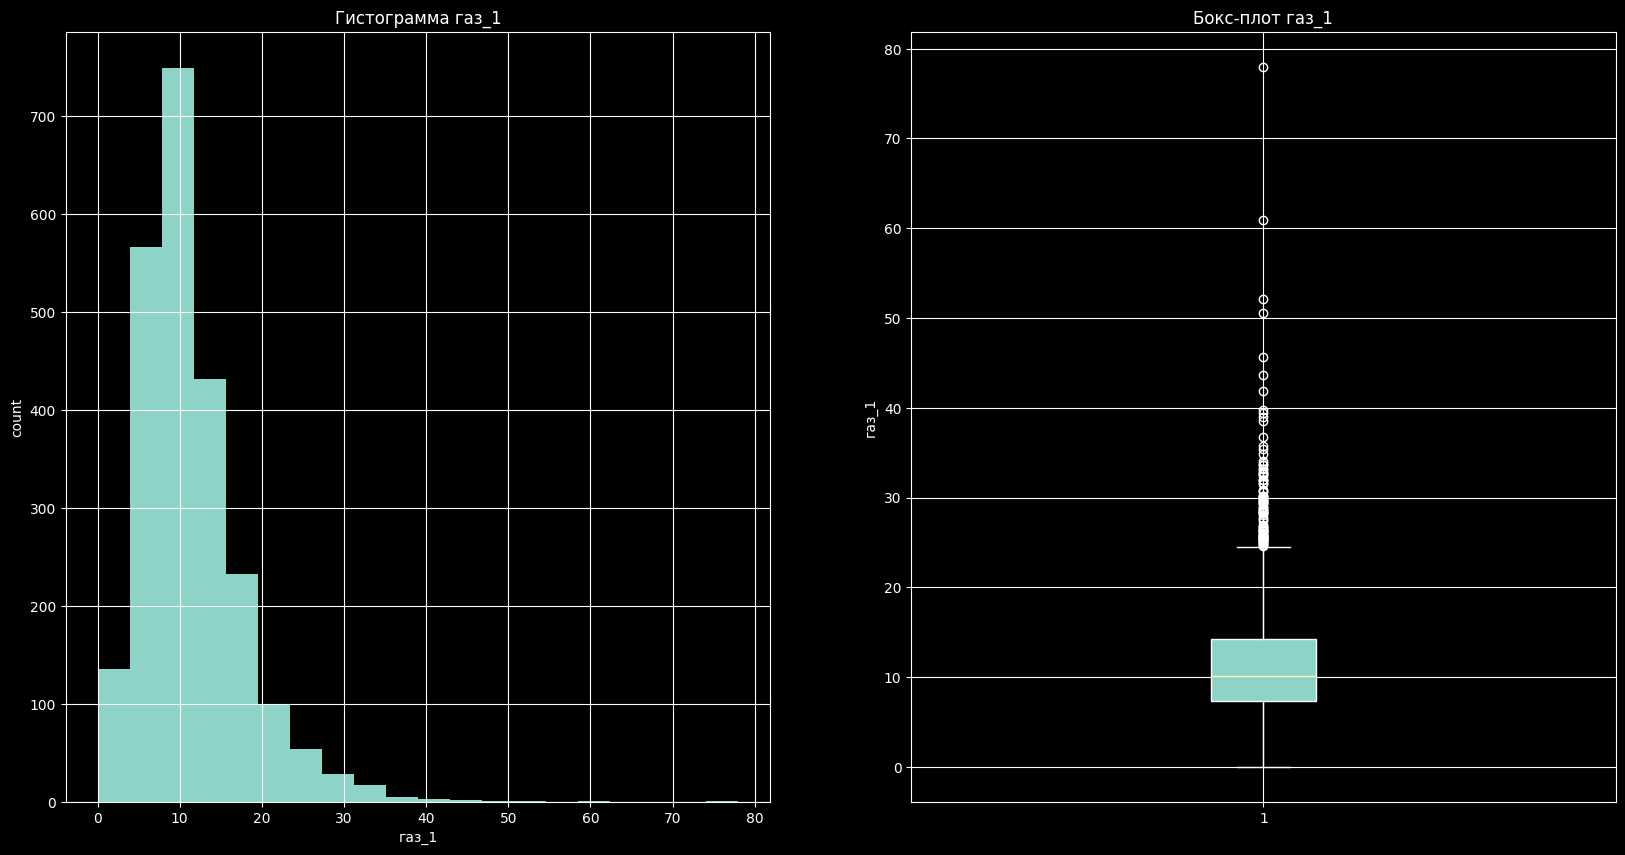

In [ ]:
for colum in df_full.columns:
    if colum not in 'key':
        print(colum)
        print(df_full[colum].describe())
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

        ax[0].hist(df_full[colum], bins=20)
        ax[0].set_title('Гистограмма ' + colum)
        ax[0].set_xlabel(colum)
        ax[0].set_ylabel('count')
        ax[0].grid(True)

        ax[1].boxplot(df_full[colum], patch_artist=True)
        ax[1].set_ylabel(colum)
        ax[1].set_title('Бокс-плот ' + colum)
        ax[1].grid(True)
        plt.show()
        print()

-**'последняя_температура'** (целевой признак) напоминает нормальное распределение смещенное к центру, разброс варьируется от 1541 до 1653, в среднем 1593

Присутсвуют слегка выбивающиеся значения по краям распределения

-**'количество_запуска_нагрева_электродами'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 1 до 16, в среднем 5

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'активная_мощность_sum'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 0.26 до 12.3, в среднем 3.12

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'реактивная_мощность_sum'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 0.19 до 8.94, в среднем 2.3

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'длительность_нагрева_sum'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 57 до 4189, в среднем 807

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'полная_мощность_sum'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 0.33 до 15.28, в среднем 3.88

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'акт/реакт_мощность_sum'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 1.11 до 22.77, в среднем 6.43

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'газ_1'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 0.01 до 77.99, в среднем 11.37

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-касательно **'bulk и wire'** фундоментально анализ остался неизменным

В большинстве колонок bulk наблюдаем сильно смещенную гистограмму к левому краю из за большого наличия 0-ых значений, максимальные значения ~500.

Везде наблюдаем аномальные значения по правому краю распределения кроме bulk_15

В большинстве колонок wire наблюдаем сильно смещенную гистограмму к левому краю из за большого наличия 0-ых значений, максимальные значения ~200.

Везде наблюдаем аномальные значения по правому краю распределения кроме wire_1 (выглядит как нормальное распределение)



#### Корреляционный анализ

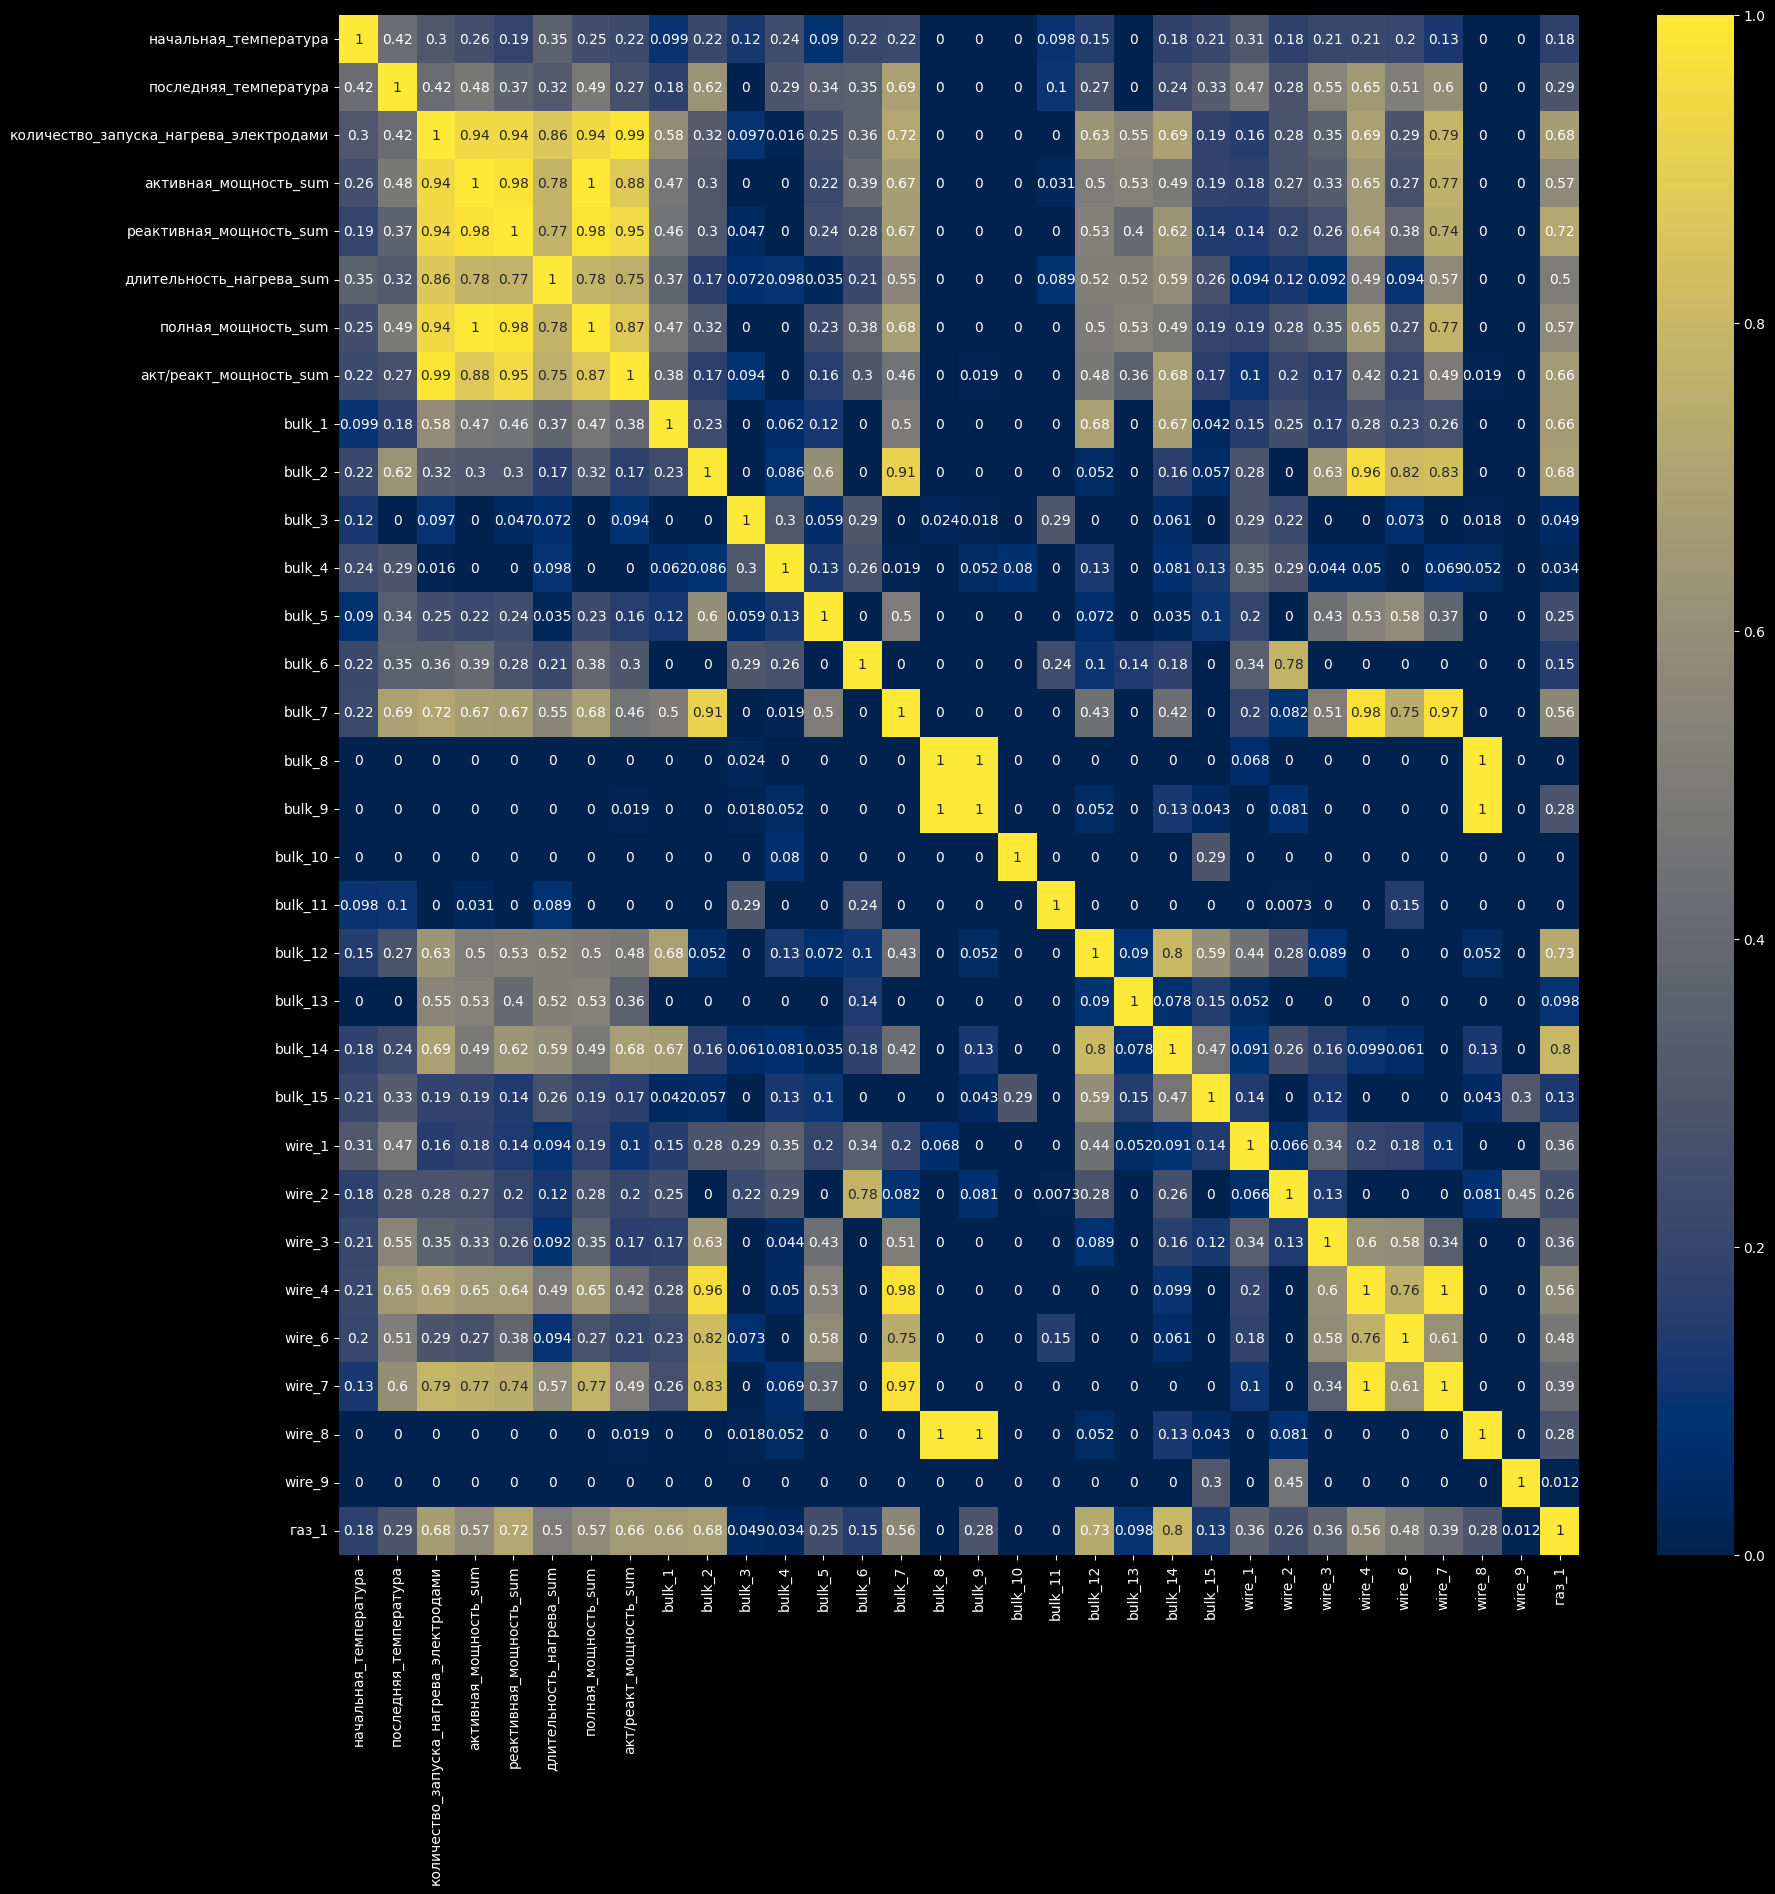

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df_full.drop('key', axis=1
                                ).phik_matrix(
                                    interval_cols = [col for col in df_full.columns if col not in ['key' ,'количество_запуска_нагрева_электродами']]
                                    ),annot=True, cmap='cividis').legend = False

Наблюдаем высоку корреляцию (>0.8):

количество_запуска_нагрева_электродами и ['wire_7', 'акт/реакт_мощность_sum', 'полная_мощность', 'длительность_нагрева', 'реактивная_мощность', 'активная_мощность'];

активная_мощность и ['wire_7', 'акт/реакт_мощность_sum', 'длительность_нагрева', 'реактивная_мощность'];

реактивная_мощность и ['акт/реакт_мощность_sum', 'полная_мощность', 'длительность_нагрева'];

полная_мощность и 'акт/реакт_мощность_sum'

bulk_2 и ['wire_7', 'wire_6', 'wire_4', 'bulk_7'];

bulk_6 и wire_7;

bulk_7 и ['wire_7', 'wire_6', 'wire_4'];

Наблюдается мультиколлинеарность (корреляция == 1)  активная_мощность и полная мощность, bulk_8 и wire_8, bulk_9 и wire_8,  bulk_9 и bulk_8, wire_7 и wire_4. В качестве улучшения метрики модели можно будет попробовать удалить лишние признаки с мультиколлинеарностью.



#### Подготовка выборки для обучения

Разделим данные на обучающую и тренировочную выборки:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(['key', 'последняя_температура'], axis=1),
    df_full['последняя_температура'],
    test_size = 0.25,
    random_state = RANDOM_STATE)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1746 entries, 121 to 340
Data columns (total 32 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   начальная_температура                   1746 non-null   float64
 1   количество_запуска_нагрева_электродами  1746 non-null   int64  
 2   активная_мощность_sum                   1746 non-null   float64
 3   реактивная_мощность_sum                 1746 non-null   float64
 4   длительность_нагрева_sum                1746 non-null   float64
 5   полная_мощность_sum                     1746 non-null   float64
 6   акт/реакт_мощность_sum                  1746 non-null   float64
 7   bulk_1                                  1746 non-null   float64
 8   bulk_2                                  1746 non-null   float64
 9   bulk_3                                  1746 non-null   float64
 10  bulk_4                                  1746 non-null   float64


In [ ]:
y_train

121     1596.0
1354    1588.0
2174    1593.0
574     1595.0
2066    1596.0
         ...  
885     1600.0
1320    1600.0
2167    1591.0
125     1594.0
340     1597.0
Name: последняя_температура, Length: 1746, dtype: float64

Масштабируем признаки

In [ ]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
X_train_scale

array([[-1.13406673,  0.18192596,  0.10077401, ..., -0.06366737,
        -0.09030648,  0.82260666],
       [-1.43034657, -0.43366071, -0.86485159, ..., -0.06366737,
        -0.09030648, -0.29287091],
       [-0.49918135, -0.43366071, -0.33627615, ..., -0.06366737,
        -0.09030648, -0.93792275],
       ...,
       [-0.03359875, -0.43366071, -0.92039528, ..., -0.06366737,
        -0.09030648, -0.54254004],
       [ 0.68593802,  0.18192596,  0.3113323 , ..., -0.06366737,
        -0.09030648, -0.82280019],
       [-0.20290151,  0.18192596,  0.03106623, ..., -0.06366737,
        -0.09030648,  0.01816836]])

In [ ]:
X_train_scale

array([[-1.13406673,  0.18192596,  0.10077401, ..., -0.06366737,
        -0.09030648,  0.82260666],
       [-1.43034657, -0.43366071, -0.86485159, ..., -0.06366737,
        -0.09030648, -0.29287091],
       [-0.49918135, -0.43366071, -0.33627615, ..., -0.06366737,
        -0.09030648, -0.93792275],
       ...,
       [-0.03359875, -0.43366071, -0.92039528, ..., -0.06366737,
        -0.09030648, -0.54254004],
       [ 0.68593802,  0.18192596,  0.3113323 , ..., -0.06366737,
        -0.09030648, -0.82280019],
       [-0.20290151,  0.18192596,  0.03106623, ..., -0.06366737,
        -0.09030648,  0.01816836]])

## Шаг 3. Обучение моделей

### RandomForest

In [ ]:
# param_grid = {
#         'min_samples_leaf': distributions.IntDistribution(1, 20),
#         'max_depth': distributions.IntDistribution(2, 300),
#         'min_samples_split': distributions.IntDistribution(2, 20),
#         'max_features': distributions.IntDistribution(2, 100),
#         'n_estimators': distributions.IntDistribution(10, 101),
#         }

# optuna_search_rf = OptunaSearchCV(
#     RandomForestRegressor(random_state=RANDOM_STATE),
#     param_grid,
#     cv=3,
#     n_trials=15,
#     scoring='neg_mean_absolute_error',
#     random_state=RANDOM_STATE,
#     n_jobs=-1
# )

# optuna_search_rf.fit(X_train_scale, y_train)
# print('Лучшая модель и её параметры:\n\n', optuna_search_rf.best_estimator_)
# print('Метрика лучшей модели на кросс-валидации:', abs(optuna_search_rf.best_score_))

Обучим алгоритм 'случайного леса':

In [ ]:
param_grid = {
        'min_samples_leaf': range(1, 20),
        'max_depth': range(2, 300),
        'min_samples_split': range(2, 20),
        'max_features': range(2, 100),
        'n_estimators': range(10, 101),
        }

random_search_rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE),
    param_grid,
    cv=3,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search_rf.fit(X_train_scale, y_train)
print('Лучшая модель и её параметры:\n\n', random_search_rf.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', -1*random_search_rf.best_score_)

Лучшая модель и её параметры:

 RandomForestRegressor(max_depth=36, max_features=73, min_samples_leaf=3,
                      min_samples_split=16, n_estimators=85,
                      random_state=171224)
Метрика лучшей модели на кросс-валидации: 6.309174232910467


### Catboost

Обучим алгоритм 'бустинга':

In [ ]:
param_grid = {
        'learning_rate': [_*1e-2 for _ in range(1, 11)],
        'max_depth': range(2, 8),
        'n_estimators': range(10, 1301)
        }

random_search_cat = RandomizedSearchCV(
    CatBoostRegressor(random_state=RANDOM_STATE),
    param_grid,
    cv=3,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search_cat.fit(X_train_scale, y_train, verbose=False)
print('Лучшая модель и её параметры:\n\n', random_search_cat.best_estimator_.get_params())
print('Метрика лучшей модели на кросс-валидации:', -1*random_search_cat.best_score_)

Лучшая модель и её параметры:

 {'loss_function': 'RMSE', 'random_state': 171224, 'n_estimators': 501, 'max_depth': 5, 'learning_rate': 0.08}
Метрика лучшей модели на кросс-валидации: 6.2229609004894035


### NN

Обучим алгоритм 'нейронной сети':

In [ ]:
if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Выделим валидацию на которой будем учится:

In [ ]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train_scale,
    y_train,
    test_size = 0.20,
    random_state = RANDOM_STATE)
X_train_nn.shape

(1396, 32)

Сохраняем тензоры:

In [ ]:
X_train_nn = torch.FloatTensor(X_train_nn).to(device)
X_val_nn = torch.FloatTensor(X_val_nn).to(device)
y_train_nn = torch.FloatTensor(y_train_nn.values).squeeze().to(device)
y_val_nn = torch.FloatTensor(y_val_nn.values).squeeze().to(device)

Лосс-функция, способ инициализации, параметры для перебора сети:

In [ ]:
loss = nn.MSELoss()

In [ ]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight, 0.5, 2)
        nn.init.normal_(layer.bias, -0.5, 1)

In [ ]:
n_in_neurons = X_train_nn.shape[1]
n_out_neurons = 1

In [ ]:
lr = [1e-2 ,5e-2, 1e-1, 5e-1]
batch_sizes = [256, 512, 1024]
p_drop = [0, 0.2, 0.5]
af = [nn.Tanh(), nn.ReLU(), nn.Sigmoid()]
n_iter = 50
num_epochs = 10001
l1 = [1e-3, 1e-2, 0]
l2 = [1e-3, 1e-2, 0]
h = list(range(300,5001, 50))

Обучение сети:

In [ ]:
best_result = []
n_hidden_neurons_1_result = []
n_hidden_neurons_2_result = []
epoch_result = []
af1_result = []
af2_result = []
lr_result = []
bs_result = []
p_drop_1_result = []
p_drop_2_result = []
l1_result = []
l2_result = []
result = []

for i in range(n_iter):
    print(f'{i+1} итерация')
    print()

    n_hidden_neurons_1 = h[np.random.randint(0, len(h))]
    n_hidden_neurons_2 = h[np.random.randint(0, len(h))]
    af1 = af[np.random.randint(0, len(af))]
    af2 = af[np.random.randint(0, len(af))]
    lr_net = lr[np.random.randint(0, len(lr))]
    batch_size = batch_sizes[np.random.randint(0, len(batch_sizes))]
    drop_1 = p_drop[np.random.randint(0, len(p_drop))]
    drop_2 = p_drop[np.random.randint(0, len(p_drop))]
    l_reg_1 = l1[np.random.randint(0, len(l1))]
    l_reg_2 = l2[np.random.randint(0, len(l2))]
    f = [1500, 1500, 1500]

    data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_nn, y_train_nn),
                                              batch_size=batch_size, shuffle=True)

    net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.BatchNorm1d(n_hidden_neurons_1),
    af1,
    nn.Dropout(p=drop_1),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.BatchNorm1d(n_hidden_neurons_2),
    af2,
    nn.Dropout(p=drop_2),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
    )
    net.apply(init_weights)

    net = net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        for X_batch, y_batch in data_loader:

            preds = net.forward(X_batch).flatten()
            loss_value = loss(preds, y_batch)

            l1_reg = l_reg_1 * sum(param.abs().sum() for param in net.parameters())
            l2_reg = l_reg_2 * sum(param.pow(2).sum() for param in net.parameters())

            total_loss = loss_value + l1_reg + l2_reg
            total_loss.backward()
            optimizer.step()

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            net.eval().to(device)

            with torch.no_grad():
                preds_valid_prob = net.forward(X_val_nn).flatten().to(device)
                result_ = torch.mean(torch.abs(preds_valid_prob - y_val_nn)).to(device)
            f.append(result_)


            print(f'кол-во нейронов в 1-ом слое: {n_hidden_neurons_1}, кол-во нейронов в 2-ом слое: {n_hidden_neurons_2},  номер эпохи: {epoch}, MAE: {result_}')
            print(f'функция активации 1-го слоя: {af1}, функция активации 2-го слоя: {af2},  скорость обучения: {lr_net}')
            print(f'размер батча: {batch_size}, dropout 1-го слоя: {drop_1}, dropout 2-го слоя: {drop_2}')
            print(f'регуляризация l1: {l_reg_1}, регуляризация l2: {l_reg_2}')
            print()
            if f[-1] > f[-2] > f[-3]:
                print('обучение сети прервано')
                print()
                break

            best_result.append(result)
            n_hidden_neurons_1_result.append(n_hidden_neurons_1)
            n_hidden_neurons_2_result.append(n_hidden_neurons_2)
            epoch_result.append(epoch)
            af1_result.append(af1)
            af2_result.append(af2)
            lr_result.append(lr_net)
            bs_result.append(batch_size)
            p_drop_1_result.append(drop_1)
            p_drop_2_result.append(drop_2)
            l1_result.append(l_reg_1)
            l2_result.append(l_reg_2)
            result.append(result_)

1 итерация

кол-во нейронов в 1-ом слое: 2900, кол-во нейронов в 2-ом слое: 1750,  номер эпохи: 0, MAE: 1733.515380859375
функция активации 1-го слоя: Tanh(), функция активации 2-го слоя: ReLU(),  скорость обучения: 0.05
размер батча: 1024, dropout 1-го слоя: 0.2, dropout 2-го слоя: 0.2
регуляризация l1: 0, регуляризация l2: 0.01

кол-во нейронов в 1-ом слое: 2900, кол-во нейронов в 2-ом слое: 1750,  номер эпохи: 100, MAE: 28.02409553527832
функция активации 1-го слоя: Tanh(), функция активации 2-го слоя: ReLU(),  скорость обучения: 0.05
размер батча: 1024, dropout 1-го слоя: 0.2, dropout 2-го слоя: 0.2
регуляризация l1: 0, регуляризация l2: 0.01

кол-во нейронов в 1-ом слое: 2900, кол-во нейронов в 2-ом слое: 1750,  номер эпохи: 200, MAE: 74.25841522216797
функция активации 1-го слоя: Tanh(), функция активации 2-го слоя: ReLU(),  скорость обучения: 0.05
размер батча: 1024, dropout 1-го слоя: 0.2, dropout 2-го слоя: 0.2
регуляризация l1: 0, регуляризация l2: 0.01

кол-во нейронов в 1-о

In [ ]:
best_result_ = min(result)
best_id = result.index(best_result_)
best_id

189

In [ ]:
best_model_2_hidden = []
best_model_2_hidden.append(f"МАЕ: {result[best_id]}")
best_model_2_hidden.append(f"Нейроны 1 слой: {n_hidden_neurons_1_result[best_id]}")
best_model_2_hidden.append(f"Нейроны 2 слой: {n_hidden_neurons_2_result[best_id]}")
best_model_2_hidden.append(f"Функ. акт. 1 слоя: {af1_result[best_id]}")
best_model_2_hidden.append(f"Функ. акт. 2 слоя: {af2_result[best_id]}")
best_model_2_hidden.append(f"learning rate: {lr_result[best_id]}")
best_model_2_hidden.append(f"Номер эпохи: {epoch_result[best_id]}")
best_model_2_hidden.append(f"dropout 1 слоя: {p_drop_1_result[best_id]}")
best_model_2_hidden.append(f"dropout 2 слоя: {p_drop_2_result[best_id]}")
best_model_2_hidden.append(f"размер батча: {bs_result[best_id]}")
best_model_2_hidden.append(f"регуляризация l1: {l1_result[best_id]}")
best_model_2_hidden.append(f"регуляризация l2: {l2_result[best_id]}")

print('лучшие параметры сети с 2-мя скр. слоями:')
best_model_2_hidden

лучшие параметры сети с 2-мя скр. слоями:


['RMSE: 6.105488300323486',
 'Нейроны 1 слой: 1650',
 'Нейроны 2 слой: 450',
 'Функ. акт. 1 слоя: Tanh()',
 'Функ. акт. 2 слоя: Tanh()',
 'learning rate: 0.01',
 'Номер эпохи: 800',
 'dropout 1 слоя: 0.2',
 'dropout 2 слоя: 0.2',
 'размер батча: 256',
 'регуляризация l1: 0.001',
 'регуляризация l2: 0']

## Шаг 4. Тестирование модели

Лучшей по итогу показала себя модель нейронной сети, ее и используем для тестирования

In [ ]:
n_hidden_neurons_1 = n_hidden_neurons_1_result[best_id]
n_hidden_neurons_2 = n_hidden_neurons_2_result[best_id]
af1 = af1_result[best_id]
af2 = af2_result[best_id]
lr_net = lr_result[best_id]
batch_size = bs_result[best_id]
drop_1 = p_drop_1_result[best_id]
drop_2 = p_drop_2_result[best_id]
l_reg_1 = l1_result[best_id]
l_reg_2 = l2_result[best_id]
num_epochs = epoch_result[best_id]

data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    torch.cat([X_train_nn, X_val_nn], dim=0), torch.cat([y_train_nn, y_val_nn], dim=0)
    ), batch_size=batch_size, shuffle=True)

net = nn.Sequential(
nn.Linear(n_in_neurons, n_hidden_neurons_1),
nn.BatchNorm1d(n_hidden_neurons_1),
af1,
nn.Dropout(p=drop_1),
nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
nn.BatchNorm1d(n_hidden_neurons_2),
af2,
nn.Dropout(p=drop_2),
nn.Linear(n_hidden_neurons_2, n_out_neurons)
)
net.apply(init_weights)

net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    for X_batch, y_batch in data_loader:
        preds = net.forward(X_batch).flatten().to(device)
        loss_value = loss(preds, y_batch)

        l1_reg = l_reg_1 * sum(param.abs().sum() for param in net.parameters())
        l2_reg = l_reg_2 * sum(param.pow(2).sum() for param in net.parameters())

        total_loss = loss_value + l1_reg + l2_reg
        total_loss.backward()
        optimizer.step()

In [ ]:
X_test_nn = torch.FloatTensor(X_test_scale).to(device)

In [ ]:
net.eval()
with torch.no_grad():
    pred = net.forward(X_test_nn).flatten().cpu().numpy()
print(f'MAE на тесте: {mean_absolute_error(y_test, pred)}')

MAE на тесте: 6.398561664142903


In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_scale, y_train)

y_test_dummy = dummy_regr.predict(X_test_scale)

print ('Метрика Dummy модели на тестовой выборке:', mean_absolute_error(y_test, y_test_dummy))

Метрика Dummy модели на тестовой выборке: 7.854012798673355


Проанализируем важность основных признаков:

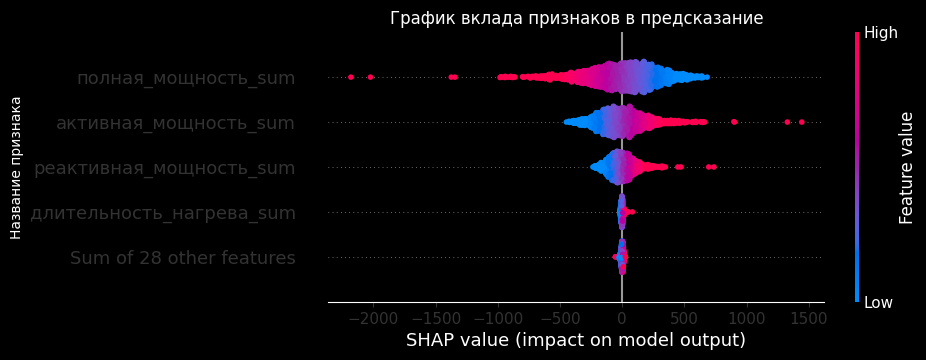

In [ ]:
model = LinearRegression()
model.fit(X_train_scale, y_train)
explainer = shap.LinearExplainer(model, pd.DataFrame(X_train_scale, columns=list(X_train.columns)))
shap_values = explainer(pd.DataFrame(X_train_scale, columns=list(X_train.columns)))

plt.title('График вклада признаков в предсказание')
plt.ylabel('Название признака')
shap.plots.beeswarm(shap_values, max_display=5)

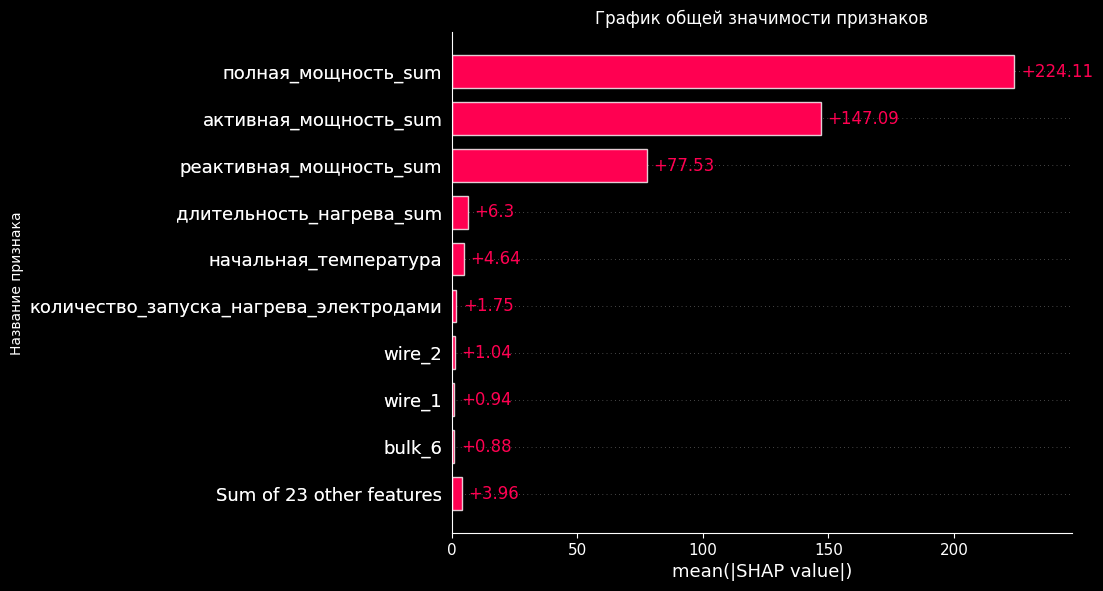

In [ ]:
plt.title('График общей значимости признаков')
plt.ylabel('Название признака')

shap.plots.bar(shap_values, max_display=10)

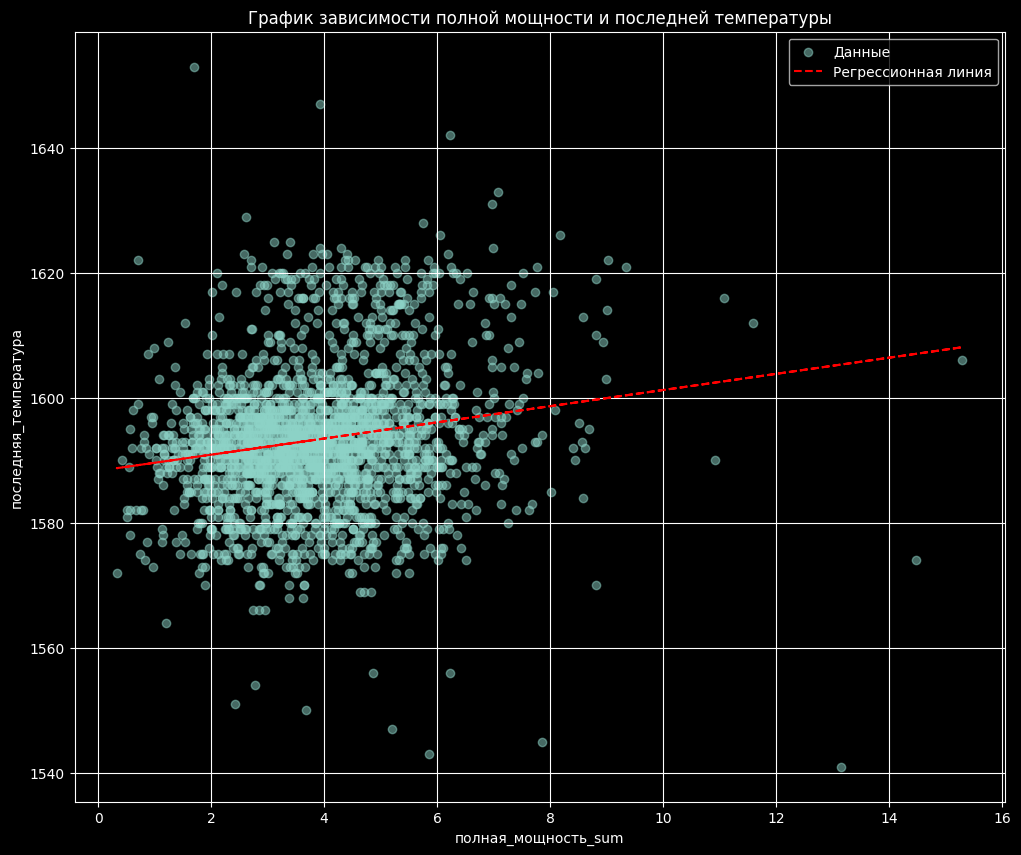

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
y = df_full['последняя_температура']
x = df_full['полная_мощность_sum']

plt.scatter(x, y, label='Данные', alpha=0.5)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label='Регрессионная линия')
plt.xlabel('полная_мощность_sum')
plt.ylabel('последняя_температура')
plt.title('График зависимости полной мощности и последней температуры')
plt.grid(True)
plt.legend()
plt.show()

Анализируя результаты, мы видим, что признак полной_мощности имеет наибольшее влияние на решение модели. Кроме того, этот признак имеет пропорциональную связь с изменением температуры, то есть чем больше значение полной_мощности, тем выше итоговая температура.

## Шаг 5. Общий вывод по работе

В проделанной работе есть промежуточные выводы, в общем выводе я бы хотел обобщить их и подвести итог по работе с данными

<h4>EDA итоговой таблицы:</h4>

-**'последняя_температура'** (целевой признак) напоминает нормальное распределение смещенное к центру, разброс варьируется от 1541 до 1653, в среднем 1593

Присутсвуют слегка выбивающиеся значения по краям распределения

-**'количество_запуска_нагрева_электродами'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 1 до 16, в среднем 5

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'активная_мощность_sum'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 0.26 до 12.3, в среднем 3.12

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'реактивная_мощность_sum'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 0.19 до 8.94, в среднем 2.3

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'длительность_нагрева_sum'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 57 до 4189, в среднем 807

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'полная_мощность_sum'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 0.33 до 15.28, в среднем 3.88

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'акт/реакт_мощность_sum'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 1.11 до 22.77, в среднем 6.43

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'газ_1'** напоминает нормальное распределение смещенное к левому, разброс варьируется от 0.01 до 77.99, в среднем 11.37

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-касательно **'bulk и wire'** фундоментально анализ остался неизменным

В большинстве колонок bulk наблюдаем сильно смещенную гистограмму к левому краю из за большого наличия 0-ых значений, максимальные значения ~500.

Везде наблюдаем аномальные значения по правому краю распределения кроме bulk_15

В большинстве колонок wire наблюдаем сильно смещенную гистограмму к левому краю из за большого наличия 0-ых значений, максимальные значения ~200.

Везде наблюдаем аномальные значения по правому краю распределения кроме wire_1 (выглядит как нормальное распределение)

<h4>Корреляционный анализ</h4>

-Наблюдаем высокую корреляцию (>0.8):

количество_запуска_нагрева_электродами и ['wire_7', 'акт/реакт_мощность_sum', 'полная_мощность', 'длительность_нагрева', 'реактивная_мощность', 'активная_мощность'];

активная_мощность и ['wire_7', 'акт/реакт_мощность_sum', 'длительность_нагрева', 'реактивная_мощность'];

реактивная_мощность и ['акт/реакт_мощность_sum', 'полная_мощность', 'длительность_нагрева'];

полная_мощность и 'акт/реакт_мощность_sum'

bulk_2 и ['wire_7', 'wire_6', 'wire_4', 'bulk_7'];

bulk_6 и wire_7;

bulk_7 и ['wire_7', 'wire_6', 'wire_4'];

-Наблюдается мультиколлинеарность (корреляция == 1)  активная_мощность и полная мощность, bulk_8 и wire_8, bulk_9 и wire_8,  bulk_9 и bulk_8, wire_7 и wire_4

<h4>Обучение моделей</h4>

-Были обучены модели случайного леса, бустинга, нейронной сети.

Лучшей себя показала нейронная сеть архитектурой 2х2, ее параметры:

['МАЕ: 6.105488300323486',
 'Нейроны 1 слой: 1650',
 'Нейроны 2 слой: 450',
 'Функ. акт. 1 слоя: Tanh()',
 'Функ. акт. 2 слоя: Tanh()',
 'learning rate: 0.01',
 'Номер эпохи: 800',
 'dropout 1 слоя: 0.2',
 'dropout 2 слоя: 0.2',
 'размер батча: 256',
 'регуляризация l1: 0.001',
 'регуляризация l2: 0']



<h4>Тестирование модели</h4>

-Результат лучшей модели на тесте:

MAE = 6.398561664142903,

в сравнении с константной моделью:

MAE Dummy модели = 7.854012798673355

-Проведен анализ входных признаков. Признак полной_мощности имеет наибольшее влияние на решение модели. Кроме того, этот признак имеет пропорциональную связь с изменением температуры, то есть чем больше значение полной_мощности, тем выше итоговая температура

